# import 

In [47]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import requests
from bs4 import BeautifulSoup
import re
import time
import urllib.request
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from graphviz import *
from sklearn.preprocessing import LabelEncoder
import optuna.integration.xgboost as xgb_o
import optuna.integration.lightgbm as lgb_o
import scipy as sp
import lightgbm as lgb
import optuna
import sklearn
from scipy.special import comb
from itertools import combinations
import copy
from sklearn.metrics import r2_score

# funcs

In [175]:
def load_csv(load_path):
    df = pd.read_csv(load_path, index_col=0)
    return df

def make_data(data_):
    x_ = data_.drop(['rank','date','tansho','ninki'],axis=1)
    y_ = data_['rank']

    test_rate = int(0.8*len(x_))
    x_train, x_test = x_.iloc[:test_rate],x_.iloc[test_rate:]
    y_train, y_test = y_.iloc[:test_rate],y_.iloc[test_rate:]

    rus = RandomUnderSampler(random_state=0)
    x_resampled, y_resampled = rus.fit_resample(x_train, y_train)
    return x_resampled, y_resampled, x_test, y_test

def make_check_data(data_):
    x_ = data_.drop(['rank','date','ninki'],axis=1)
    y_ = data_['rank']

    test_rate = int(0.8*len(x_))
    x_train, x_check = x_.iloc[:test_rate],x_.iloc[test_rate:]
    y_train, y_check = y_.iloc[:test_rate],y_.iloc[test_rate:]

    return x_check,y_check

def learn_xgb(data_):
    x_resampled, y_resampled, x_test, y_test = make_data(data_)
    
    xgb_model, y_pred = xgb_pred(x_resampled, y_resampled, x_test, y_test)
    return xgb_model, y_pred
    
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic',
                  'n_estimators':14,
                  'use_label_encoder':False,
                 'max_depth':4,
                 'random_state':100}
    
    best_params = {'booster': 'gbtree', 
                   'objective': 'binary:logistic',
                   'eval_metric': 'rmse', 
                   'random_state': 100, 
                   'use_label_encoder':False,
                   'eta': 0.13449222415941048,
                   'max_depth': 3,
                   'lambda': 0.7223936363734638, 
                   'n_estimators': 14, 
                   'reg_alpha': 0.7879044553842869,
                   'reg_lambda': 0.7780344172793093,
                   'importance_type': 'gain'}
    xgb_model = xgb.XGBClassifier(**best_params)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    plot_importances(xgb_model, x_test)
    return xgb_model

def lgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {
        'objective' : 'binary',
          'random_state':100,
                 }
    best_params = {
    'objective': 'binary',
    'random_state': 100,
    'feature_pre_filter': False,
    'lambda_l1': 4.693572572985162e-07,
    'lambda_l2': 0.8052948126650886,
    'num_leaves': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9783720284106503,
    'bagging_freq': 7,
    'min_child_samples': 50
    }

    lgb_model = lgb.LGBMClassifier(**best_params)
    hr_pred = lgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = lgb_model.predict_proba(x_train.astype(float))[:,1]
    y_proba = lgb_model.predict_proba(x_test.astype(float))[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    lgb.plot_importance(lgb_model) 
    plot_importances(lgb_model, x_test)
    return lgb_model

def plot_importances(xgb_model, x_test):
    importances = pd.DataFrame(
    {'features' : x_test.columns, 'importances' : xgb_model.feature_importances_})
    print(importances.sort_values('importances', ascending=False)[:20])
    
def eval_proba(x_test, y_test, xgb_model):
    predict_proba = xgb_model.predict_proba(x_test.astype(float))
    df = pd.DataFrame(columns = ['alpha','score','Up precision','Down precision','Up recall','Down recall','num'])
    j=0
    
    
    for alpha in [0.70,0.80,0.90]:
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        if denom==0:continue
            
            
        TU = acc_dict['TU']
        FU = acc_dict['FU']
        TD = acc_dict['TD']
        FD = acc_dict['FD']
        score = (TU + TD)/(denom)
        prec_u = TU/(TU + FU)
        prec_d = TD/(TD + FD)
        recall_u = TU/(TU + FD)
        recall_d = TD/(TD + FU)
        col_list = [alpha,score,prec_u,prec_d,recall_u,recall_d,denom]
        df.loc[j] = col_list
        j+=1
    return df
    
def process_category(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
        
#      get dummy
    for column in target_columns:
        df2[column] = df2[column].astype('category')

    return df2

def gain(return_func, x_, n_samples=100,lower=3,t_range=[0.5,3.5]):
    gain = {}
    for i in range(n_samples):
        threshold = t_range[1] * (i/n_samples) + t_range[0] *(1-i/n_samples)
        n_bets, return_rate, n_hits,std = return_func(x_, threshold)
        if n_bets > lower:
            gain[threshold] = {'return_rate':return_rate,'n_hits':n_hits,'std':std,'n_bets':n_bets}
    return pd.DataFrame(gain).T

place_dict = {
    '札幌':'01', '函館':'02', '福島':'03', '新潟':'04', '東京':'05',
    '中山':'06', '中京':'07', '京都':'08', '阪神':'09', '小倉':'10'
}

race_type_dict = {
    '芝':'shiba', 'ダ':'dirt', '障':'shou'
}

def plot(g,label=''):
    plt.fill_between(g.index,y1 = g['return_rate'] - g['std'],y2=g['return_rate']+g['std'],alpha=0.3)
    plt.plot(g.index,g['return_rate'],label=label)
    plt.grid(True)

# classes

In [183]:
class HorseResults():
    
    
    def __init__(self, horse_results):
        self.place_dict = {
            '札幌':'01', '函館':'02', '福島':'03', '新潟':'04', '東京':'05',
            '中山':'06', '中京':'07', '京都':'08', '阪神':'09', '小倉':'10'
        }
        self.race_type_dict = {
            '芝':'shiba', 'ダ':'dirt', '障':'shou'
        }
        self.horse_results = horse_results[['日付','着順','賞金','着差','通過','開催','距離']]
        self.preprocessing()
        
        
    @classmethod
    def read_csv(cls):
        pass
    
    @staticmethod
    def scrape(horse_id_list):
        pass


    def preprocessing(self):
        df = self.horse_results.copy()
        df['rank'] = pd.to_numeric(df['着順'],errors='coerce')
        df.dropna(subset=['rank'],inplace=True)
        df['rank'] = df['rank'].astype(int)
        df['date'] = pd.to_datetime(df['日付'])
        df['prize'] = df['賞金']
        df['prize'].fillna(0, inplace=True)
        df['chakusa'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x:corner(x,1))
        df['final_corner'] = df['通過'].map(lambda x:corner(x,4))
        df['final_to_rank'] = df['final_corner'] - df['rank']
        df['first_to_rank'] = df['first_corner'] - df['rank']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(self.place_dict).fillna('11')
        df['race_type'] =  df['距離'].str.extract(r'(\D+)')[0].map(self.race_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) //100
        df = df.drop(['日付','着順','賞金','着差','通過','開催','距離'],axis=1)
        
        df.index.name = 'horse_id'
        self.horse_results = df
        self.target_list = ['rank','prize','chakusa','first_corner'
                            ,'final_corner','final_to_rank'
                            ,'first_to_rank','first_to_final'
                           ]
    
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        if n_samples=='all':
            filtered_df = target_df[target_df['date']<date]
        elif n_samples>0:
            filtered_df = target_df[target_df['date']<date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be positive number.')
            
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean()\
        .add_suffix('_{}R'.format(n_samples))
        
        
        for column in ['race_type','course_len','place']:
            self.average_dict[column] = filtered_df.groupby(['horse_id',column])\
        [self.target_list].mean().add_suffix('_{}_{}R'.format(column,n_samples))
    
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list,date,n_samples)
        merged_df = df.merge(self.average_dict['non_category'],left_on='horse_id',right_index=True,how='left')
        
        
        for column in ['race_type','course_len','place']:
            merged_df = merged_df.merge(self.average_dict[column],left_on=['horse_id',column],
                                   right_index=True,how='left')
        return merged_df
    
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results,date,n_samples) for date in date_list])
        return merged_df
    
class Peds():
    
    
    def __init__(self,peds):
        self.peds = peds
        
        
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
       
        self.peds_e = df.astype('category')
        
class DataProcessor():
    
    
    def __init__(self):
        self.data = pd.DataFrame()
        self.data_p = pd.DataFrame()
        self.data_h = pd.DataFrame()
        self.data_pe = pd.DataFrame()
        self.data_c = pd.DataFrame()
        
        
    def merge_horse_results(self, hr, n_samples_list=[5,9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h,n_samples=n_samples)
        self.data_h.drop(['place'],axis=1,inplace=True)
        
    def merge_peds(self,peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id',right_index=True,how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds" ')
            
            
    def process_categorical(self,le_horse, le_jockey):
        df = self.data_pe.copy()
        
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
                                               
        self.data_c = df
        
class ShutubaTable(DataProcessor):
    
    
    def __init__(self):
        super(ShutubaTable,self).__init__()
        
    def scrape(self, race_id_list, date):
        for race_id in race_id_list:
        
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find('div', attrs={'class':'RaceData01'}).text
            texts = re.findall(r'\w+',texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df['weather'] = [text] * len(df)
                if text in ["良","稍重","重","不良"]:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)

            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(horse_id)

            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            self.data = self.data.append(df)
                
                       
    def preprocessing(self):
        df = self.data.copy()
        df['horse_id'] = df['horse_id'].astype(int)
        df['jockey_id'] = df['jockey_id'].astype(int)
        df['性'] = df['性齢'].map(lambda x:str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x:str(x)[1:]).astype(int)
        
        df = df[df["馬体重(増減)"]!='--']
        df['体重'] = df['馬体重(増減)'].str.split("(",expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split("(",expand=True)[1].str[:-1].astype(int)
        df['date'] = pd.to_datetime(df['date'])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df = df[['枠','馬番','斤量','course_len','weather','race_type',
                'ground_state','date','horse_id','jockey_id','性','年齢','体重','体重変化']]
        
        self.data_p = df.rename(columns={'枠':'枠番'})
            
   
    def process_categorical(self,le_horse, le_jockey):
        df = self.data_pe.copy()
        
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
                                               
        self.data_c = df
        
class Results(DataProcessor):
    
    
    def __init__(self, results):
        super(Results,self).__init__()
        self.data = results
                           
   
    def preprocessing(self):
        df = self.data.copy()
        df['date'] = pd.to_datetime(df['date'],format='%Y年%m月%d日')
        df.sort_values('date', ascending=True,inplace=True)
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])
        df['old'] = df['性齢'].map(lambda x: str(x)[1]).astype(int)
        df = df[~(df['着順'].astype(str).str.contains('\D'))]
        df['rank'] = df['着順'].astype(int).map(lambda x:1 if x<4 else 0)
        
        df['weight'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['weight_diff'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)
        df['tansho'] = df['単勝'].astype(float)
        df['ninki'] = df['人気'].astype(int)
        df = df.drop(['馬名','着差','騎手','調教師','性齢','着順','馬体重','単勝','人気','タイム'],axis=1)
        df['course_len'] = df['course_len'].astype(float) //100
        df = df.rename(columns={'着順':'rank','枠番':'wakuban','馬番':'umaban','斤量':'kinryou'})
#         雪, 小雪もあるでよ
        df['weather'] = df['weather'].map({'小雨':0, '雨':1,'曇':2, '晴':3, '雪':4,'小雪':5})
#         df['race_type'] = df['race_type'].map({'芝':0, 'ダート':1, '障害':2})
        df['sex'] = df['sex'].map({'牝':0, '牡':1, 'セ':2})
        df['ground_state'] = df['ground_state'].map({'良':0, '稍重':1, '重':2, '不良':3})
        df['place'] =  df.index.map(lambda x: str(x)[4:6])
#         馬の数
        df['n_horse'] = df.index.map(lambda x: len(df.loc[x]))
        
        self.data_p = df
            
            
    def process_categorical(self):
        self.data_pe['race_type'] = self.data_pe['race_type'].map({'芝':0, 'ダート':1, '障害':2})
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse,self.le_jockey)
        
class Return():
    
    def __init__(self, return_tables):
        self.return_tables = return_tables
        self.return_tables.columns = self.return_tables.columns.astype(int)
        
        
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    @classmethod
    def read_csv(cls):
        pass

        
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]] 
        wins = fukusho[1].str.split('br',expand=True)[[0,1,2]]
        wins.columns = ['wins_0','wins_1','wins_2']
        returns = fukusho[2].str.split('br',expand=True)[[0,1,2]]
        returns.columns = ['returns_0','returns_1','returns_2']
        df = pd.concat([wins,returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        
        return df.fillna(0).astype(int)
    
    
    @property 
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2]] 
        tansho.columns = ['win','return']
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return  tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]] 
        wins = umaren[1].str.split('-',expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')
        df = pd.concat([wins,return_],axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))     
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]] 
        wins = umatan[1].str.split('→',expand=True)[[0,1]].add_prefix('win_')
        return_ = umatan[2].rename('return')
        df = pd.concat([wins,return_],axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))   
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]] 
        wins = wide[1].str.split('br',expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-',expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br',expand=True)[[0,1,2]]
        return_ = return_.stack().rename('return')
        df = pd.concat([wins, return_], axis=1)
        df['return'] = df['return'].apply(lambda x: pd.to_numeric(x.replace(',',''), errors='coerce'))
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))    
    
    
    @property
    def sanrenpuku(self):
        sanrenpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]] 
        wins = sanrenpuku[1].str.split('-',expand=True)[[0,1,2]].add_prefix('win_')
        return_ = sanrenpuku[2].rename('return')
        df = pd.concat([wins,return_],axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))     
    
    @property
    def sanrentan(self):
        sanrentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]] 
        wins = sanrentan[1].str.split('→',expand=True)[[0,1,2]].add_prefix('win_')
        return_ = sanrentan[2].rename('return')
        df = pd.concat([wins,return_],axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))     
          
class ModelEvaluater():
    
    
    def __init__(self, model, return_tables):
        self.model = model
        self.rt = Return(return_tables)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrenpuku = self.rt.sanrenpuku
        self.sanrentan = self.rt.sanrentan

    
    def predict_proba(self, x_,std=True,minmax=False):
        proba = pd.Series(self.model.predict_proba(x_.drop(['tansho'],axis=1).values)[:,1],index=x_.index)
        if std:
            standard_scaler = lambda x: (x -x.mean())/x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
        if minmax:
            proba = (proba - proba.min())/(proba.max() - proba.min())
            
        return proba
        
    
    def predict(self,x_, threshold=0.5):
        y_pred = self.predict_proba(x_)
        return [0 if p<threshold else 1 for p in y_pred]
        
        
    def pred_table(self, x_, threshold=0.5, bet_only=True):
        pred_table = x_.copy()[['umaban','tansho']]
        pred_table['pred'] = self.predict(x_,threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['umaban', 'tansho']]
        else:
            return pred_table
        
        
    def bet(self,race_id, kind, umaban, amount):
        if kind=='tansho':
            rt_1R = self.tansho.loc[race_id]
            return_ = (rt_1R['win'] == umaban) * amount/100 * rt_1R['return']
        if kind=='fukusho':
            rt_1R = self.fukusho.loc[race_id ]
            return_ = ((rt_1R[['wins_0','wins_1','wins_2']]== umaban).values * \
            rt_1R[['returns_0','returns_1','returns_2']]).sum() * amount/100
        if kind=='umaren':
            rt_1R = self.umaren.loc[race_id]
            return_ = (set(rt_1R[['win_0','win_1']]) == set(umaban)) * rt_1R['return']\
            *amount/100
        if kind =='umatan':
            rt_1R = self.umatan.loc[race_id]
            return_ = (list(rt_1R[['win_0','win_1']]) == list(umaban)) * rt_1R['return']\
            *amount/100
        if kind =='wide':
            rt_1R = self.wide.loc[race_id]
            return_ = rt_1R.apply(
                lambda x:(set(x[['win_0','win_1']])==set(umaban)) * x['return'],axis=1
            ).sum() * amount/100
        if kind=='sanrenpuku':
            rt_1R = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_1R[['win_0','win_1','win_2']]) == set(umaban)) * rt_1R['return']\
            *amount/100
        if kind=='sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            return_ = (list(rt_1R[['win_0','win_1','win_2']]) == list(umaban)) * rt_1R['return']\
            *amount/100
        if not return_ >=0:
            return_ = amount
        
        return return_
        
    
    def fukusho_return(self,x_,threshold=0.5):
        pred_table = self.pred_table(x_,threshold)
    
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append((preds['umaban'].map(lambda x:self.bet(race_id,'fukusho',x,1))).sum()
                              )
            n_bets += len(preds)
        return_rate = np.sum(return_list) / n_bets
        n_hits = np.sum(np.array(return_list)>0)
        std = np.sqrt(len(return_list)) * np.std(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    
    def tansho_return(self,x_,threshold=0.5):
        pred_table = self.pred_table(x_,threshold)
    
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append((preds['umaban'].map(lambda x:self.bet(race_id,'tansho',x,1))).sum()
                              )
            n_bets += len(preds)
        return_rate = np.sum(return_list) / n_bets
        n_hits = np.sum(np.array(return_list)>0)
        std = np.sqrt(len(return_list)) * np.std(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    
    def tansho_return_proper(self, x_, threshold=0.5):
        pred_table = self.pred_table(x_, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.tansho.copy()
        df = df.merge(pred_table,left_index=True, right_index=True,how='right')
        bet_money = (1 /pred_table['tansho']).sum()
        
        std = ((df['win'] == df['umaban']).astype(int)).groupby(level=0).sum().std() \
             * np.sqrt(n_races) / bet_money
        
        n_hits = len(df.query('win==umaban'))
        return_rate = n_hits/bet_money
        return n_bets,return_rate,n_hits ,std
    
    
    def umaren_box(self,x_,threshold=0.5):
        pred_table = self.pred_table(x_,threshold)
    
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            # 一頭しかいない時は単勝でかける
            if len(preds)==1:
#                 return_ = self.bet(race_id,'tansho',preds['umaban'].values[0],1)
#                 return_list.append(return_)
#                 n_bets+=1
                continue
            else:
                for combi in combinations(preds['umaban'],2):
                    return_ = self.bet(race_id,'umaren',combi,1)
                    return_list.append(return_)
                    n_bets+=1
        return_rate = np.sum(return_list) / n_bets
        n_hits = np.sum(np.array(return_list)>0)
        std = np.sqrt(len(return_list)) * np.std(return_list) / n_bets
        return n_bets, return_rate, n_hits, std

    
    def umatan_box(self):
        pass

# load Data

In [150]:
path_20_21 = '/Users/rince/Desktop/Horse/Data/20_21/'

return_tables = load_csv(path_20_21+'return_tables.csv')
results = load_csv(path_20_21+'results.csv')
peds = load_csv(path_20_21+'peds.csv')
horse_results = load_csv(path_20_21+'horse_results.csv')

# 学習データ作成

In [151]:
# hr作成
hr = HorseResults(horse_results)

# pedsデータカテゴリ化
p = Peds(peds)
p.encode()

#  学習データ作成
r = Results(race_data)
r.preprocessing()
r.merge_horse_results(hr) 
r.merge_peds(p.peds_e)
r.process_categorical()


In [157]:
x_train

,wakuban,umaban,kinryou,course_len,weather,race_type,ground_state,horse_id,jockey_id,sex,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
0,2,2,56.0,18.0,3,1,0,6104,99,1,...,141,217,144,109,442,177,281,358,604,2436
1,7,14,57.0,12.0,3,1,0,875,0,1,...,275,181,114,243,483,448,287,515,407,1532
2,1,1,56.0,18.0,2,1,1,3980,7,1,...,182,327,197,376,483,944,281,568,538,3272
3,1,1,56.0,17.0,3,1,0,3140,110,1,...,215,171,119,344,414,242,340,492,1245,2494
4,3,6,56.0,18.0,3,1,0,4856,93,1,...,366,269,68,393,293,433,503,1239,1419,2854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13185,3,5,54.0,12.0,3,1,0,5611,104,1,...,363,621,114,243,351,225,297,553,580,927
13186,6,6,52.0,18.0,3,0,0,9012,122,1,...,368,680,157,85,173,589,369,950,692,2134
13187,1,1,52.0,20.0,2,0,0,4905,19,0,...,356,303,162,202,96,719,515,1108,225,1552
13188,6,6,55.0,20.0,2,0,0,3423,65,0,...,29,73,94,144,8,547,332,735,869,2712


# 学習

In [156]:
# st.data_c.info()
x_train,y_train, x_test,y_test = make_data(r.data_c)


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9783720284106503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783720284106503
[LightGBM] [Warning] lambda_l2 is set=0.8052948126650886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8052948126650886
[LightGBM] [Warning] lambda_l1 is set=4.693572572985162e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.693572572985162e-07
---------------------
AUC train: 0.7618994218171347
AUC test : 0.6962781446988753
              precision    recall  f1-score   support

           0       0.87      0.56      0.68      5876
           1       0.32      0.72      0.44      1692

    accuracy                           0.60      7568
   macro avg       0.60      0.64      0.56     

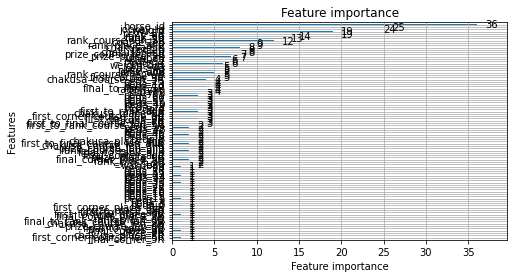

In [167]:
lgb_model = lgb_pred(x_train,y_train,x_test,y_test)

---------------------
AUC train: 0.7309230520743942
AUC test : 0.6848614973438453
              precision    recall  f1-score   support

           0       0.87      0.59      0.71      5876
           1       0.33      0.68      0.44      1692

    accuracy                           0.61      7568
   macro avg       0.60      0.64      0.57      7568
weighted avg       0.75      0.61      0.65      7568

                         features  importances
13                        rank_5R     0.202781
14                       prize_5R     0.126012
45                        rank_9R     0.096661
61             rank_course_len_9R     0.064314
77                      rank_allR     0.048925
15                     chakusa_5R     0.039104
93           rank_course_len_allR     0.035109
79                   chakusa_allR     0.030844
101               rank_place_allR     0.030552
8                       jockey_id     0.029524
78                     prize_allR     0.028184
29             rank_course_

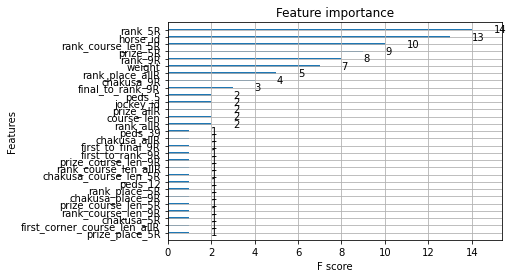

In [168]:
xgb_model = xgb_pred(x_train,y_train,x_test,y_test)

# 出馬表作成 & データ整形

In [32]:
st = ShutubaTable()
st.scrape(['202004020601','202004020605'],'2020/08/09')
st.preprocessing()
st.merge_horse_results(hr)
st.merge_peds(p.peds_e)
st.process_categorical(r.le_horse,r.le_jockey)

scrape peds at horse_id_list "no_peds" 


In [35]:
st.data_c.head()

,枠番,馬番,斤量,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202004020601,1,1,51,1800,雨,芝,不良,2020-08-09,5250,144,...,283,519,121,275,246,631,260,686,453,2170
202004020601,1,2,54,1800,雨,芝,不良,2020-08-09,4913,144,...,127,570,106,169,450,865,458,1104,1188,2492
202004020601,2,3,54,1800,雨,芝,不良,2020-08-09,7161,144,...,337,233,74,304,176,576,249,792,1145,2780
202004020601,2,4,54,1800,雨,芝,不良,2020-08-09,4864,144,...,181,274,106,234,166,607,329,1022,272,1308
202004020601,3,5,54,1800,雨,芝,不良,2020-08-09,4888,144,...,51,480,194,192,59,430,232,573,443,768


# 学習モデルの評価

In [71]:
me = ModelEvaluater(lgb_model, return_tables)

# 単勝適正回収値
常に払い戻しが一定になるように単勝でかけた場合の回収値


# apply は列ごと, mapは行ごとみたいな

In [79]:
lgb_model.predict_proba(x_train.values)
type(x_check)

pandas.core.frame.DataFrame

In [ ]:
x_check.drop()

In [85]:
me = ModelEvaluater(lgb_model,return_tables)
# me.umaren_return(x_test)
x_check, y_check = make_check_data(r.data_c)
df = me.pred_table(x_check)

In [116]:
race_results

NameError: name 'race_results' is not defined

In [84]:
df

,umaban,tansho
202110040309,3,3.3
202110040309,4,10.1
202110040310,5,1.5
202110040310,4,5.1
202110040311,2,7.5
...,...,...
202104050409,8,40.7
202104050409,2,19.9
202104050409,1,54.2
202104050409,7,4.2


In [180]:
me.predict_proba(x_check,std=False,minmax=False)

202110040309    0.631657
202110040309    0.414717
202110040309    0.421383
202110040309    0.413096
202110040309    0.434132
                  ...   
202104050409    0.692148
202104050409    0.709679
202104050409    0.648975
202104050409    0.721798
202109040410    0.520495
Length: 7568, dtype: float32

<AxesSubplot:>

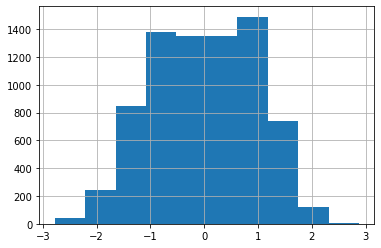

In [87]:
me.predict_proba(x_check,std=True,minmax=False).hist()

In [88]:
me.predict_proba(x_check,std=True,minmax=False).max()

2.8756082534293177

<AxesSubplot:>

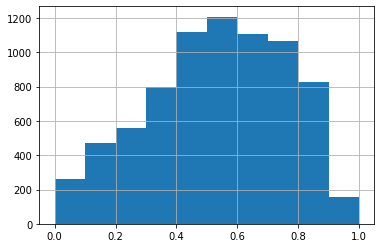

In [89]:
me.predict_proba(x_check,std=False,minmax=True).hist()

# XGBoostだと馬連めっちゃ回収率いい
他はlightgbm の方が上？
データが少ない中では唯一xgbが勝った

In [20]:
g = gain(me.tansho_return, x_check)


<ipython-input-8-9d2df8ddcd63>:469: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


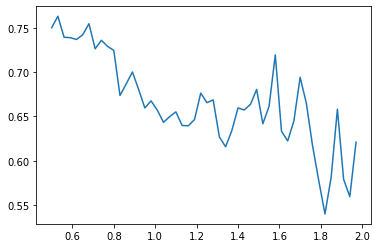

In [22]:
plt.plot(g.index,g['return_rate'])

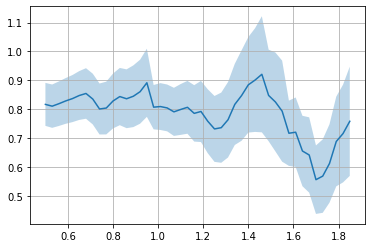

In [451]:
plot(g)

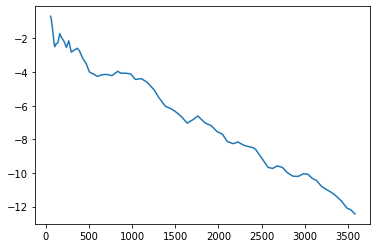

In [430]:
plt.plot(g.index,(g['return_rate']-1)/g['std'])

<AxesSubplot:>

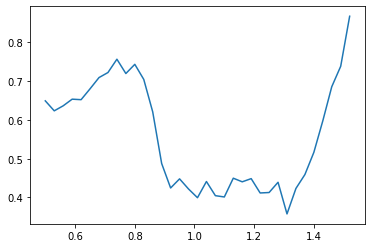

In [124]:
g['return_rate'].plot()

<AxesSubplot:>

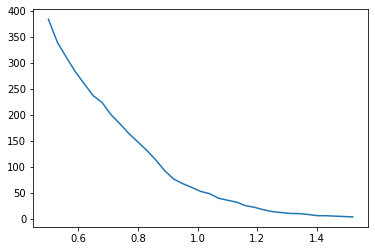

In [125]:
(g['n_hits']/g.index).plot()

In [126]:
r_dict = {}
for threshold in [0.5,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]:
    n_bets, return_rate, n_hits, std = me.tansho_return(x_check,threshold=threshold)
    r_dict[threshold] = {'return_rate':return_rate,'n_hits':n_hits,'std':std,'n_bets':n_bets}
gain = pd.DataFrame(r_dict).T


In [133]:
gain

,return_rate,n_hits,std,n_bets
0.50,0.717817,341.0,0.046509,2638.0
0.55,0.699761,330.0,0.044431,2506.0
0.60,0.715975,323.0,0.046442,2385.0
0.65,0.733407,319.0,0.047327,2260.0
0.70,0.751316,311.0,0.049538,2128.0
0.75,0.747103,297.0,0.051503,2002.0
0.80,0.722986,280.0,0.050422,1862.0
0.85,0.712149,267.0,0.051205,1745.0
0.90,0.660261,245.0,0.048578,1608.0
0.95,0.614433,222.0,0.045313,1455.0


In [132]:
x_train

,wakuban,umaban,kinryou,course_len,weather,race_type,ground_state,horse_id,jockey_id,sex,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
0,2,2,56.0,18.0,3,1,0,6104,99,1,...,129,194,127,94,404,157,261,318,545,2133
1,7,14,57.0,12.0,3,1,0,875,0,1,...,255,162,102,216,439,398,267,463,368,1322
2,1,1,56.0,18.0,2,1,1,3980,7,1,...,167,294,176,339,439,835,261,511,488,2848
3,1,1,56.0,17.0,3,1,0,3140,110,1,...,198,152,107,308,378,215,313,442,1127,2180
4,3,6,56.0,18.0,3,1,0,4856,93,1,...,340,238,63,354,271,385,459,1102,1284,2497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13185,3,5,54.0,12.0,3,1,0,5611,104,1,...,337,570,102,216,322,198,276,499,526,802
13186,6,6,52.0,18.0,3,0,0,9012,122,1,...,341,622,139,72,162,525,339,846,624,1862
13187,1,1,52.0,20.0,2,0,0,4905,19,0,...,330,271,144,179,87,644,471,990,201,1340
13188,6,6,55.0,20.0,2,0,0,3423,65,0,...,24,67,84,127,8,488,306,661,785,2377


# time 計測

In [250]:
%%timeit
a = 0
for i in range(1000):
    a+=1

51.4 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [162]:
rt = Return(return_tables)

xgb_model

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eta=0.13449222415941048,
               eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', lambda=0.7223936363734638,
               learning_rate=0.134492218, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=14, n_jobs=4, num_parallel_tree=1, random_state=100,
               reg_alpha=0.7879044553842869, reg_lambda=0.7780344172793093,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=None),
 array([1, 0, 0, ..., 1, 1, 1]))

In [169]:
me = ModelEvaluater(xgb_model,return_tables)

In [170]:
me.tansho_return_proper(x_check,0.9)

(1635, 0.7325670178378514, 243, 0.03506587620837894)

<ipython-input-80-b9ed82fea135>:454: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


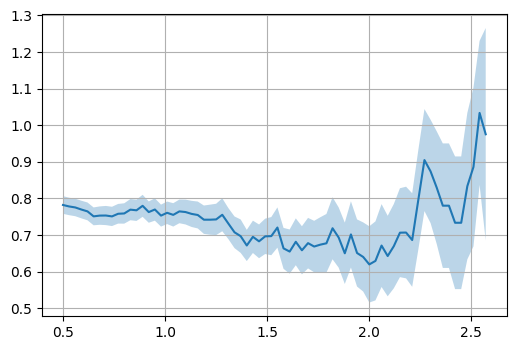

In [176]:
g = gain(me.fukusho_return,x_check)
plt.figure(dpi=100)
plot(g)
plt.show()

<ipython-input-80-b9ed82fea135>:469: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


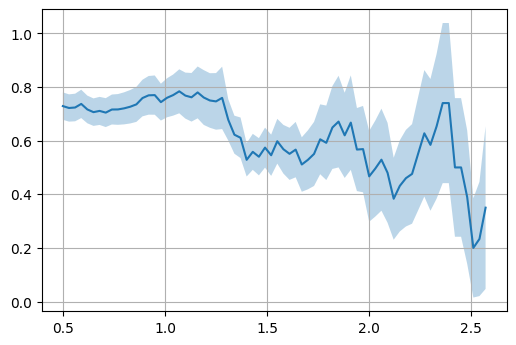

In [177]:
g = gain(me.tansho_return,x_check)
plt.figure(dpi=100)
plot(g)
plt.show()

<ipython-input-80-b9ed82fea135>:487: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = n_hits/bet_money


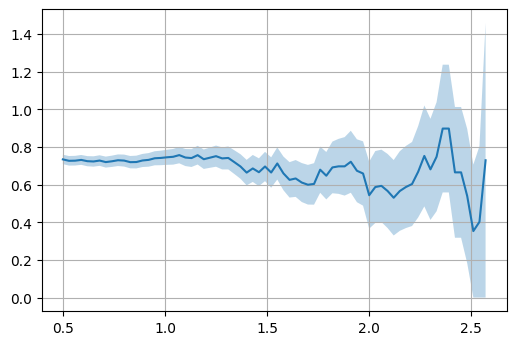

In [178]:
g = gain(me.tansho_return_proper,x_check)
plt.figure(dpi=100)
plot(g)
plt.show()

<ipython-input-80-b9ed82fea135>:508: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


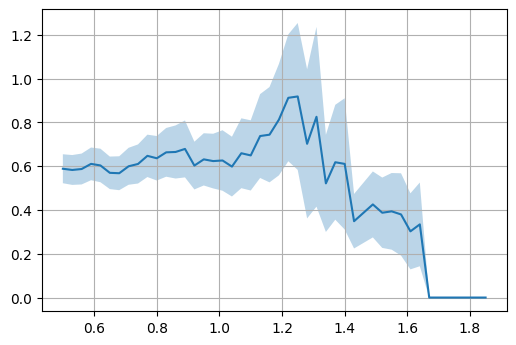

In [179]:

g = gain(me.umaren_box,x_check)
plt.figure(dpi=100)
plot(g)



In [123]:
df

,umaban,tansho
202110040309,3,3.3
202110040310,5,1.5
202110040310,4,5.1
202110040311,2,7.5
202110040311,7,3.2
...,...,...
202104050409,2,19.9
202104050409,1,54.2
202104050409,7,4.2
202104050409,14,14.2


In [101]:
c=0
for race_id, preds in df.groupby(level=0):
    print(race_id,preds)
    c+=1
    if c==10:
        break

202101020301               umaban  tansho
202101020301       7     1.3
202101020301       4     4.5
202101020301       1    22.7
202101020302               umaban  tansho
202101020302       1    21.0
202101020302      10     5.8
202101020302       7    12.6
202101020302       6     3.2
202101020303               umaban  tansho
202101020303       6    13.4
202101020303       9     2.4
202101020303      10    18.3
202101020303       3    12.6
202101020304               umaban  tansho
202101020304       2     4.7
202101020304       1     2.9
202101020304       5    15.7
202101020304       3     8.3
202101020304      15     4.5
202101020304       7    22.0
202101020305               umaban  tansho
202101020305      14     3.4
202101020305       7    13.0
202101020305       4    26.4
202101020305       6    43.7
202101020306               umaban  tansho
202101020306      10    15.8
202101020306      11     5.3
202101020306       6    15.5
202101020306       7    15.8
202101020306       8   

In [108]:
pred_table =  x_check.copy()[['umaban','tansho']]
pred_table.iloc[:20]

,umaban,tansho
202110040309,3,3.3
202110040309,5,18.7
202110040309,11,28.4
202110040309,7,122.1
202110040309,9,125.1
202110040309,4,10.1
202110040309,8,19.8
202110040310,5,1.5
202110040310,1,4.3
202110040310,6,8.4


In [121]:
r.data_p['date']

202107010101   2021-01-05
202106010108   2021-01-05
202106010108   2021-01-05
202106010108   2021-01-05
202106010108   2021-01-05
                  ...    
202104050409   2021-10-17
202104050409   2021-10-17
202104050409   2021-10-17
202104050409   2021-10-17
202109040410   2021-10-17
Name: date, Length: 37837, dtype: datetime64[ns]

In [120]:
race_data['date']

202101010101    2021年6月12日
202101010101    2021年6月12日
202101010101    2021年6月12日
202101010101    2021年6月12日
202101010101    2021年6月12日
                   ...    
202110040812     2021年9月5日
202110040812     2021年9月5日
202110040812     2021年9月5日
202110040812     2021年9月5日
202110040812     2021年9月5日
Name: date, Length: 38130, dtype: object

In [141]:
gain

,return_rate,n_hits,std,n_bets
0.50,0.717817,341.0,0.046509,2638.0
0.55,0.699761,330.0,0.044431,2506.0
0.60,0.715975,323.0,0.046442,2385.0
0.65,0.733407,319.0,0.047327,2260.0
0.70,0.751316,311.0,0.049538,2128.0
0.75,0.747103,297.0,0.051503,2002.0
0.80,0.722986,280.0,0.050422,1862.0
0.85,0.712149,267.0,0.051205,1745.0
0.90,0.660261,245.0,0.048578,1608.0
0.95,0.614433,222.0,0.045313,1455.0


In [104]:
# me.pred_table()
c=0
for race_id, _ in x_check.groupby(level=0):
    print(race_id)
    c+=1
    if c>=20:
        break

202101020301
202101020302
202101020303
202101020304
202101020305
202101020306
202101020307
202101020308
202101020309
202101020310
202101020311
202101020312
202101020401
202101020402
202101020403
202101020404
202101020405
202101020406
202101020407
202101020408


In [98]:
len(x_check),len(g)

(7568, 35)

xgb.XGBClassifier



 
    tree_method: string
        Specify which tree method to use.  Default to auto.  If this parameter
        is set to default, XGBoost will choose the most conservative option
        available.  It's recommended to study this option from parameters
        document.
    n_jobs : int
        Number of parallel threads used to run xgboost.  When used with other Scikit-Learn
        algorithms like grid search, you may choose which algorithm to parallelize and
        balance the threads.  Creating thread contention will significantly slow down both
        algorithms.
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : float
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : float
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
    base_score:
        The initial prediction score of all instances, global bias.
   
    missing : float, default np.nan
        Value in the data which needs to be present as a missing value.
    num_parallel_tree: int
        Used for boosting random forest.
    monotone_constraints : str
        Constraint of variable monotonicity.  See tutorial for more
        information.
    interaction_constraints : str
        Constraints for interaction representing permitted interactions.  The
        constraints must be specified in the form of a nest list, e.g. [[0, 1],
        [2, 3, 4]], where each inner list is a group of indices of features
        that are allowed to interact with each other.  See tutorial for more
        information
    importance_type: string, default "gain"
        The feature importance type for the feature_importances\_ property:
        either "gain", "weight", "cover", "total_gain" or "total_cover".


# Grid Search

In [50]:
trains = xgb.DMatrix(x_train.astype(float), label=y_train)
tests = xgb.DMatrix(x_test.astype(float), label=y_test)

base_params = {
    'booster': 'gbtree',
    'objective':'binary:logistic',
    'eval_metric': 'rmse',
    'random_state':100
}

watchlist = [(trains, 'train'), (tests, 'eval')]
tmp_params = copy.deepcopy(base_params)


def optimizer(trial):
#     booster = trial.suggest_categorical('booster', ['gbtree', 'dart', 'gblinear'])
    eta = trial.suggest_uniform('eta', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    __lambda = trial.suggest_uniform('lambda', 0.7, 2)
    n_estimators = trial.suggest_int('n_estimators', 3, 20)
    learning_rate = trial.suggest_uniform('lambda', 0.01, 1)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.01, 1)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.01, 1)
    importance_type = trial.suggest_categorical('importance_type',
                                                ['gain', 'weight', 'cover','total_gain','total_cover'])

#     params['booster'] = booster
    tmp_params['eta'] = eta
    tmp_params['max_depth'] = max_depth
    tmp_params['lambda'] = __lambda
    tmp_params['n_estimators'] = n_estimators
    tmp_params['learning_rate'] = learning_rate
    tmp_params['reg_alpha'] = reg_alpha
    tmp_params['reg_lambda'] = reg_lambda
    tmp_params['importance_type'] = importance_type
        

    model = xgb.train(tmp_params, trains, num_boost_round=50)
    predicts = model.predict(tests)

    r2 = r2_score(y_test, predicts)
    print(f'#{trial.number}, Result: {r2}, {trial.params}')

    return r2

In [51]:
def eval_model(params, trains, tests):
    model = xgb.train(params, trains, num_boost_round=100, verbose_eval=False, evals=watchlist)
    predicts = model.predict(tests)
    r2 = r2_score(y_test, predicts)

    return r2,model




study = optuna.create_study(direction='maximize')
study.optimize(optimizer, n_trials=500)
print(study.best_params)
print(study.best_value)

base_r2,bst1 = eval_model(base_params, trains, tests)
merged_params = dict(base_params, **study.best_params)
best_r2 = eval_model(merged_params, trains, tests)
print(f'Base params: {base_params}')
print(f'Best params: {merged_params}')
print(f'Base: {base_r2}, Best: {best_r2}, Diff: {best_r2 - base_r2}')

[I 2021-10-28 13:55:09,145] A new study created in memory with name: no-name-d54af77a-a7a6-477f-bcd6-e50b868a094e
/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(


[13:55:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-28 13:55:15,652] Trial 0 finished with value: -0.8650675857122521 and parameters: {'eta': 0.2843067721719149, 'max_depth': 14, 'lambda': 0.8667678318020978, 'n_estimators': 8, 'reg_alpha': 0.9448668133935003, 'reg_lambda': 0.39334727518138585, 'importance_type': 'weight'}. Best is trial 0 with value: -0.8650675857122521.


#0, Result: -0.8650675857122521, {'eta': 0.2843067721719149, 'max_depth': 14, 'lambda': 0.8667678318020978, 'n_estimators': 8, 'reg_alpha': 0.9448668133935003, 'reg_lambda': 0.39334727518138585, 'importance_type': 'weight'}
[13:55:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:18,945] Trial 1 finished with value: -0.8162080881187304 and parameters: {'eta': 0.08829913316140864, 'max_depth': 7, 'lambda': 0.9299631632866888, 'n_estimators': 7, 'reg_alpha': 0.22915299935471128, 'reg_lambda': 0.5255769733559359, 'importance_type': 'total_gain'}. Best is trial 1 with value: -0.8162080881187304.


#1, Result: -0.8162080881187304, {'eta': 0.08829913316140864, 'max_depth': 7, 'lambda': 0.9299631632866888, 'n_estimators': 7, 'reg_alpha': 0.22915299935471128, 'reg_lambda': 0.5255769733559359, 'importance_type': 'total_gain'}
[13:55:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:24,281] Trial 2 finished with value: -0.9016977439437188 and parameters: {'eta': 0.20022089557207925, 'max_depth': 11, 'lambda': 1.042218742784173, 'n_estimators': 4, 'reg_alpha': 0.5547809020288449, 'reg_lambda': 0.6749838800243967, 'importance_type': 'weight'}. Best is trial 1 with value: -0.8162080881187304.


#2, Result: -0.9016977439437188, {'eta': 0.20022089557207925, 'max_depth': 11, 'lambda': 1.042218742784173, 'n_estimators': 4, 'reg_alpha': 0.5547809020288449, 'reg_lambda': 0.6749838800243967, 'importance_type': 'weight'}
[13:55:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:30,016] Trial 3 finished with value: -1.0266902555554052 and parameters: {'eta': 0.1890549770197434, 'max_depth': 12, 'lambda': 1.5900142868206744, 'n_estimators': 17, 'reg_alpha': 0.8748010721167447, 'reg_lambda': 0.658627507020172, 'importance_type': 'total_gain'}. Best is trial 1 with value: -0.8162080881187304.


#3, Result: -1.0266902555554052, {'eta': 0.1890549770197434, 'max_depth': 12, 'lambda': 1.5900142868206744, 'n_estimators': 17, 'reg_alpha': 0.8748010721167447, 'reg_lambda': 0.658627507020172, 'importance_type': 'total_gain'}
[13:55:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:36,004] Trial 4 finished with value: -1.196019806000049 and parameters: {'eta': 0.10069208057684147, 'max_depth': 10, 'lambda': 1.5490943303784035, 'n_estimators': 6, 'reg_alpha': 0.025459893473013362, 'reg_lambda': 0.010872614096975479, 'importance_type': 'cover'}. Best is trial 1 with value: -0.8162080881187304.


#4, Result: -1.196019806000049, {'eta': 0.10069208057684147, 'max_depth': 10, 'lambda': 1.5490943303784035, 'n_estimators': 6, 'reg_alpha': 0.025459893473013362, 'reg_lambda': 0.010872614096975479, 'importance_type': 'cover'}
[13:55:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:37,309] Trial 5 finished with value: -0.580097184431561 and parameters: {'eta': 0.28665933879231514, 'max_depth': 3, 'lambda': 1.7952914934484123, 'n_estimators': 10, 'reg_alpha': 0.7487295044583181, 'reg_lambda': 0.7288266367169778, 'importance_type': 'weight'}. Best is trial 5 with value: -0.580097184431561.


#5, Result: -0.580097184431561, {'eta': 0.28665933879231514, 'max_depth': 3, 'lambda': 1.7952914934484123, 'n_estimators': 10, 'reg_alpha': 0.7487295044583181, 'reg_lambda': 0.7288266367169778, 'importance_type': 'weight'}
[13:55:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:41,084] Trial 6 finished with value: -1.149273441943195 and parameters: {'eta': 0.2710201167006043, 'max_depth': 7, 'lambda': 1.7729614981926078, 'n_estimators': 4, 'reg_alpha': 0.48553233443415367, 'reg_lambda': 0.9032013587766259, 'importance_type': 'total_gain'}. Best is trial 5 with value: -0.580097184431561.


#6, Result: -1.149273441943195, {'eta': 0.2710201167006043, 'max_depth': 7, 'lambda': 1.7729614981926078, 'n_estimators': 4, 'reg_alpha': 0.48553233443415367, 'reg_lambda': 0.9032013587766259, 'importance_type': 'total_gain'}
[13:55:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:44,121] Trial 7 finished with value: -1.867739513528798 and parameters: {'eta': 0.23953737425118948, 'max_depth': 13, 'lambda': 1.9862380154785062, 'n_estimators': 17, 'reg_alpha': 0.4826223061546305, 'reg_lambda': 0.158433104203838, 'importance_type': 'gain'}. Best is trial 5 with value: -0.580097184431561.


#7, Result: -1.867739513528798, {'eta': 0.23953737425118948, 'max_depth': 13, 'lambda': 1.9862380154785062, 'n_estimators': 17, 'reg_alpha': 0.4826223061546305, 'reg_lambda': 0.158433104203838, 'importance_type': 'gain'}
[13:55:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:47,772] Trial 8 finished with value: -1.2530878350585062 and parameters: {'eta': 0.2091435323868253, 'max_depth': 7, 'lambda': 1.7413795819013016, 'n_estimators': 15, 'reg_alpha': 0.2857658512191631, 'reg_lambda': 0.31450001899106067, 'importance_type': 'total_cover'}. Best is trial 5 with value: -0.580097184431561.


#8, Result: -1.2530878350585062, {'eta': 0.2091435323868253, 'max_depth': 7, 'lambda': 1.7413795819013016, 'n_estimators': 15, 'reg_alpha': 0.2857658512191631, 'reg_lambda': 0.31450001899106067, 'importance_type': 'total_cover'}
[13:55:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:51,293] Trial 9 finished with value: -0.7775877914738079 and parameters: {'eta': 0.20193917427595173, 'max_depth': 7, 'lambda': 0.791000812067542, 'n_estimators': 20, 'reg_alpha': 0.6204985120448433, 'reg_lambda': 0.40356368977060597, 'importance_type': 'cover'}. Best is trial 5 with value: -0.580097184431561.


#9, Result: -0.7775877914738079, {'eta': 0.20193917427595173, 'max_depth': 7, 'lambda': 0.791000812067542, 'n_estimators': 20, 'reg_alpha': 0.6204985120448433, 'reg_lambda': 0.40356368977060597, 'importance_type': 'cover'}
[13:55:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:52,529] Trial 10 finished with value: -0.6096459974456896 and parameters: {'eta': 0.12859476769553368, 'max_depth': 3, 'lambda': 1.2520172567286605, 'n_estimators': 11, 'reg_alpha': 0.7502446580820756, 'reg_lambda': 0.9566547916570636, 'importance_type': 'weight'}. Best is trial 5 with value: -0.580097184431561.


#10, Result: -0.6096459974456896, {'eta': 0.12859476769553368, 'max_depth': 3, 'lambda': 1.2520172567286605, 'n_estimators': 11, 'reg_alpha': 0.7502446580820756, 'reg_lambda': 0.9566547916570636, 'importance_type': 'weight'}
[13:55:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:53,762] Trial 11 finished with value: -0.5958767993998166 and parameters: {'eta': 0.1351647529502974, 'max_depth': 3, 'lambda': 1.2425832489994593, 'n_estimators': 11, 'reg_alpha': 0.7689223272822836, 'reg_lambda': 0.9272452619700625, 'importance_type': 'weight'}. Best is trial 5 with value: -0.580097184431561.


#11, Result: -0.5958767993998166, {'eta': 0.1351647529502974, 'max_depth': 3, 'lambda': 1.2425832489994593, 'n_estimators': 11, 'reg_alpha': 0.7689223272822836, 'reg_lambda': 0.9272452619700625, 'importance_type': 'weight'}
[13:55:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:54,983] Trial 12 finished with value: -0.5766708216366276 and parameters: {'eta': 0.15078994114843236, 'max_depth': 3, 'lambda': 1.2521571489147427, 'n_estimators': 12, 'reg_alpha': 0.7489208789203518, 'reg_lambda': 0.794490711424362, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#12, Result: -0.5766708216366276, {'eta': 0.15078994114843236, 'max_depth': 3, 'lambda': 1.2521571489147427, 'n_estimators': 12, 'reg_alpha': 0.7489208789203518, 'reg_lambda': 0.794490711424362, 'importance_type': 'weight'}
[13:55:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:57,677] Trial 13 finished with value: -0.9009424493370795 and parameters: {'eta': 0.012588465039663571, 'max_depth': 5, 'lambda': 1.3898348405722034, 'n_estimators': 13, 'reg_alpha': 0.7032981995144287, 'reg_lambda': 0.736410097576704, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#13, Result: -0.9009424493370795, {'eta': 0.012588465039663571, 'max_depth': 5, 'lambda': 1.3898348405722034, 'n_estimators': 13, 'reg_alpha': 0.7032981995144287, 'reg_lambda': 0.736410097576704, 'importance_type': 'weight'}
[13:55:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:55:59,896] Trial 14 finished with value: -0.7728045512030159 and parameters: {'eta': 0.0640880428211562, 'max_depth': 5, 'lambda': 1.1194105027227295, 'n_estimators': 9, 'reg_alpha': 0.8557164746471909, 'reg_lambda': 0.7818413658406894, 'importance_type': 'gain'}. Best is trial 12 with value: -0.5766708216366276.


#14, Result: -0.7728045512030159, {'eta': 0.0640880428211562, 'max_depth': 5, 'lambda': 1.1194105027227295, 'n_estimators': 9, 'reg_alpha': 0.8557164746471909, 'reg_lambda': 0.7818413658406894, 'importance_type': 'gain'}
[13:55:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:02,084] Trial 15 finished with value: -1.4490428444827246 and parameters: {'eta': 0.16036881563699062, 'max_depth': 5, 'lambda': 1.9739728137277675, 'n_estimators': 13, 'reg_alpha': 0.6723029848885558, 'reg_lambda': 0.5709181950279372, 'importance_type': 'total_cover'}. Best is trial 12 with value: -0.5766708216366276.


#15, Result: -1.4490428444827246, {'eta': 0.16036881563699062, 'max_depth': 5, 'lambda': 1.9739728137277675, 'n_estimators': 13, 'reg_alpha': 0.6723029848885558, 'reg_lambda': 0.5709181950279372, 'importance_type': 'total_cover'}
[13:56:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:03,427] Trial 16 finished with value: -0.6675186141267562 and parameters: {'eta': 0.24521353714112104, 'max_depth': 3, 'lambda': 1.497703333809139, 'n_estimators': 9, 'reg_alpha': 0.98606941622678, 'reg_lambda': 0.8049642986755173, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#16, Result: -0.6675186141267562, {'eta': 0.24521353714112104, 'max_depth': 3, 'lambda': 1.497703333809139, 'n_estimators': 9, 'reg_alpha': 0.98606941622678, 'reg_lambda': 0.8049642986755173, 'importance_type': 'weight'}
[13:56:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:05,866] Trial 17 finished with value: -1.1068536490259984 and parameters: {'eta': 0.1715157575743372, 'max_depth': 5, 'lambda': 1.7682690277039574, 'n_estimators': 14, 'reg_alpha': 0.419831404411899, 'reg_lambda': 0.848176047318219, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#17, Result: -1.1068536490259984, {'eta': 0.1715157575743372, 'max_depth': 5, 'lambda': 1.7682690277039574, 'n_estimators': 14, 'reg_alpha': 0.419831404411899, 'reg_lambda': 0.848176047318219, 'importance_type': 'weight'}
[13:56:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:10,669] Trial 18 finished with value: -1.0225031357534013 and parameters: {'eta': 0.23785908430826808, 'max_depth': 9, 'lambda': 1.3108217834963936, 'n_estimators': 11, 'reg_alpha': 0.8051677241048174, 'reg_lambda': 0.633025713888334, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#18, Result: -1.0225031357534013, {'eta': 0.23785908430826808, 'max_depth': 9, 'lambda': 1.3108217834963936, 'n_estimators': 11, 'reg_alpha': 0.8051677241048174, 'reg_lambda': 0.633025713888334, 'importance_type': 'weight'}
[13:56:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:16,478] Trial 19 finished with value: -1.0211833343606997 and parameters: {'eta': 0.29811335901842195, 'max_depth': 15, 'lambda': 1.4174963309538602, 'n_estimators': 10, 'reg_alpha': 0.6102533552361539, 'reg_lambda': 0.999775734604325, 'importance_type': 'total_cover'}. Best is trial 12 with value: -0.5766708216366276.


#19, Result: -1.0211833343606997, {'eta': 0.29811335901842195, 'max_depth': 15, 'lambda': 1.4174963309538602, 'n_estimators': 10, 'reg_alpha': 0.6102533552361539, 'reg_lambda': 0.999775734604325, 'importance_type': 'total_cover'}
[13:56:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:18,121] Trial 20 finished with value: -0.7436009128895529 and parameters: {'eta': 0.042263352230450205, 'max_depth': 4, 'lambda': 1.1161829372427752, 'n_estimators': 16, 'reg_alpha': 0.3146994563416425, 'reg_lambda': 0.44942868393660923, 'importance_type': 'cover'}. Best is trial 12 with value: -0.5766708216366276.


#20, Result: -0.7436009128895529, {'eta': 0.042263352230450205, 'max_depth': 4, 'lambda': 1.1161829372427752, 'n_estimators': 16, 'reg_alpha': 0.3146994563416425, 'reg_lambda': 0.44942868393660923, 'importance_type': 'cover'}
[13:56:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:19,342] Trial 21 finished with value: -0.585569480258896 and parameters: {'eta': 0.13137140106322243, 'max_depth': 3, 'lambda': 1.2282948257470252, 'n_estimators': 12, 'reg_alpha': 0.7602361876906076, 'reg_lambda': 0.8914020822759959, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#21, Result: -0.585569480258896, {'eta': 0.13137140106322243, 'max_depth': 3, 'lambda': 1.2282948257470252, 'n_estimators': 12, 'reg_alpha': 0.7602361876906076, 'reg_lambda': 0.8914020822759959, 'importance_type': 'weight'}
[13:56:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:20,981] Trial 22 finished with value: -0.6904122935376222 and parameters: {'eta': 0.12775031004184162, 'max_depth': 4, 'lambda': 1.1692232950343335, 'n_estimators': 13, 'reg_alpha': 0.8809259458331206, 'reg_lambda': 0.8666287786894891, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#22, Result: -0.6904122935376222, {'eta': 0.12775031004184162, 'max_depth': 4, 'lambda': 1.1692232950343335, 'n_estimators': 13, 'reg_alpha': 0.8809259458331206, 'reg_lambda': 0.8666287786894891, 'importance_type': 'weight'}
[13:56:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:22,577] Trial 23 finished with value: -0.6241183109810391 and parameters: {'eta': 0.104218024774757, 'max_depth': 4, 'lambda': 0.9718060614666806, 'n_estimators': 12, 'reg_alpha': 0.6833268061933528, 'reg_lambda': 0.7358624393257838, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#23, Result: -0.6241183109810391, {'eta': 0.104218024774757, 'max_depth': 4, 'lambda': 0.9718060614666806, 'n_estimators': 12, 'reg_alpha': 0.6833268061933528, 'reg_lambda': 0.7358624393257838, 'importance_type': 'weight'}
[13:56:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:25,293] Trial 24 finished with value: -0.9938193568484466 and parameters: {'eta': 0.14863286761807332, 'max_depth': 6, 'lambda': 1.4231840140219922, 'n_estimators': 6, 'reg_alpha': 0.8117041005007611, 'reg_lambda': 0.7442124090169396, 'importance_type': 'gain'}. Best is trial 12 with value: -0.5766708216366276.


#24, Result: -0.9938193568484466, {'eta': 0.14863286761807332, 'max_depth': 6, 'lambda': 1.4231840140219922, 'n_estimators': 6, 'reg_alpha': 0.8117041005007611, 'reg_lambda': 0.7442124090169396, 'importance_type': 'gain'}
[13:56:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:26,497] Trial 25 finished with value: -0.7532527421993866 and parameters: {'eta': 0.17287799398313705, 'max_depth': 3, 'lambda': 1.6355840685716312, 'n_estimators': 9, 'reg_alpha': 0.589835750602201, 'reg_lambda': 0.589847177330666, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#25, Result: -0.7532527421993866, {'eta': 0.17287799398313705, 'max_depth': 3, 'lambda': 1.6355840685716312, 'n_estimators': 9, 'reg_alpha': 0.589835750602201, 'reg_lambda': 0.589847177330666, 'importance_type': 'weight'}
[13:56:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:29,233] Trial 26 finished with value: -0.932113197361524 and parameters: {'eta': 0.1153821924150249, 'max_depth': 6, 'lambda': 1.2946548089158043, 'n_estimators': 15, 'reg_alpha': 0.9092600142286806, 'reg_lambda': 0.8435997727226032, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#26, Result: -0.932113197361524, {'eta': 0.1153821924150249, 'max_depth': 6, 'lambda': 1.2946548089158043, 'n_estimators': 15, 'reg_alpha': 0.9092600142286806, 'reg_lambda': 0.8435997727226032, 'importance_type': 'weight'}
[13:56:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:30,839] Trial 27 finished with value: -0.891752871957868 and parameters: {'eta': 0.07174299423529261, 'max_depth': 4, 'lambda': 1.8572648214879504, 'n_estimators': 20, 'reg_alpha': 0.7261350221140539, 'reg_lambda': 0.9968162778727342, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#27, Result: -0.891752871957868, {'eta': 0.07174299423529261, 'max_depth': 4, 'lambda': 1.8572648214879504, 'n_estimators': 20, 'reg_alpha': 0.7261350221140539, 'reg_lambda': 0.9968162778727342, 'importance_type': 'weight'}
[13:56:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:35,666] Trial 28 finished with value: -0.9095318319991605 and parameters: {'eta': 0.21856483258437703, 'max_depth': 8, 'lambda': 1.1994058792084814, 'n_estimators': 12, 'reg_alpha': 0.9978355681800214, 'reg_lambda': 0.6677264866132371, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#28, Result: -0.9095318319991605, {'eta': 0.21856483258437703, 'max_depth': 8, 'lambda': 1.1994058792084814, 'n_estimators': 12, 'reg_alpha': 0.9978355681800214, 'reg_lambda': 0.6677264866132371, 'importance_type': 'weight'}
[13:56:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:38,321] Trial 29 finished with value: -0.8741718013321271 and parameters: {'eta': 0.2668979681623637, 'max_depth': 6, 'lambda': 1.0595032733105596, 'n_estimators': 8, 'reg_alpha': 0.9334311161888027, 'reg_lambda': 0.31454776431765863, 'importance_type': 'weight'}. Best is trial 12 with value: -0.5766708216366276.


#29, Result: -0.8741718013321271, {'eta': 0.2668979681623637, 'max_depth': 6, 'lambda': 1.0595032733105596, 'n_estimators': 8, 'reg_alpha': 0.9334311161888027, 'reg_lambda': 0.31454776431765863, 'importance_type': 'weight'}
[13:56:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:39,518] Trial 30 finished with value: -0.4566424239439384 and parameters: {'eta': 0.14872379019026225, 'max_depth': 3, 'lambda': 0.7711684937370724, 'n_estimators': 10, 'reg_alpha': 0.8218125540845642, 'reg_lambda': 0.8036664352329513, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#30, Result: -0.4566424239439384, {'eta': 0.14872379019026225, 'max_depth': 3, 'lambda': 0.7711684937370724, 'n_estimators': 10, 'reg_alpha': 0.8218125540845642, 'reg_lambda': 0.8036664352329513, 'importance_type': 'cover'}
[13:56:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:40,692] Trial 31 finished with value: -0.47638645569903915 and parameters: {'eta': 0.14972960984875147, 'max_depth': 3, 'lambda': 0.7865199098759614, 'n_estimators': 10, 'reg_alpha': 0.8187972431258147, 'reg_lambda': 0.7925197878482796, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#31, Result: -0.47638645569903915, {'eta': 0.14972960984875147, 'max_depth': 3, 'lambda': 0.7865199098759614, 'n_estimators': 10, 'reg_alpha': 0.8187972431258147, 'reg_lambda': 0.7925197878482796, 'importance_type': 'cover'}
[13:56:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:42,288] Trial 32 finished with value: -0.5216203765796585 and parameters: {'eta': 0.15293913889267363, 'max_depth': 4, 'lambda': 0.8389670194934046, 'n_estimators': 7, 'reg_alpha': 0.8252191336993022, 'reg_lambda': 0.8115399006194486, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#32, Result: -0.5216203765796585, {'eta': 0.15293913889267363, 'max_depth': 4, 'lambda': 0.8389670194934046, 'n_estimators': 7, 'reg_alpha': 0.8252191336993022, 'reg_lambda': 0.8115399006194486, 'importance_type': 'cover'}
[13:56:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:43,865] Trial 33 finished with value: -0.5179887274465631 and parameters: {'eta': 0.14622565955657804, 'max_depth': 4, 'lambda': 0.724522993150906, 'n_estimators': 6, 'reg_alpha': 0.8336914604746564, 'reg_lambda': 0.8058896261287882, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#33, Result: -0.5179887274465631, {'eta': 0.14622565955657804, 'max_depth': 4, 'lambda': 0.724522993150906, 'n_estimators': 6, 'reg_alpha': 0.8336914604746564, 'reg_lambda': 0.8058896261287882, 'importance_type': 'cover'}
[13:56:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:45,471] Trial 34 finished with value: -0.5269189723789416 and parameters: {'eta': 0.1844252035500753, 'max_depth': 4, 'lambda': 0.7154963451404094, 'n_estimators': 6, 'reg_alpha': 0.8258488172028042, 'reg_lambda': 0.559079093106672, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#34, Result: -0.5269189723789416, {'eta': 0.1844252035500753, 'max_depth': 4, 'lambda': 0.7154963451404094, 'n_estimators': 6, 'reg_alpha': 0.8258488172028042, 'reg_lambda': 0.559079093106672, 'importance_type': 'cover'}
[13:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:47,550] Trial 35 finished with value: -0.6369242578581198 and parameters: {'eta': 0.16430387112005015, 'max_depth': 5, 'lambda': 0.8679688545270974, 'n_estimators': 3, 'reg_alpha': 0.9274269334062069, 'reg_lambda': 0.7039028645537625, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#35, Result: -0.6369242578581198, {'eta': 0.16430387112005015, 'max_depth': 5, 'lambda': 0.8679688545270974, 'n_estimators': 3, 'reg_alpha': 0.9274269334062069, 'reg_lambda': 0.7039028645537625, 'importance_type': 'cover'}
[13:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:49,139] Trial 36 finished with value: -0.49603185178983766 and parameters: {'eta': 0.08518456962173473, 'max_depth': 4, 'lambda': 0.7002469634689773, 'n_estimators': 7, 'reg_alpha': 0.8506556820078179, 'reg_lambda': 0.6192574298482605, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#36, Result: -0.49603185178983766, {'eta': 0.08518456962173473, 'max_depth': 4, 'lambda': 0.7002469634689773, 'n_estimators': 7, 'reg_alpha': 0.8506556820078179, 'reg_lambda': 0.6192574298482605, 'importance_type': 'cover'}
[13:56:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:53,919] Trial 37 finished with value: -0.8308927574626797 and parameters: {'eta': 0.07335271259722716, 'max_depth': 10, 'lambda': 0.7047690792160303, 'n_estimators': 5, 'reg_alpha': 0.023633631541108202, 'reg_lambda': 0.4938397978503908, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#37, Result: -0.8308927574626797, {'eta': 0.07335271259722716, 'max_depth': 10, 'lambda': 0.7047690792160303, 'n_estimators': 5, 'reg_alpha': 0.023633631541108202, 'reg_lambda': 0.4938397978503908, 'importance_type': 'cover'}
[13:56:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:56:56,540] Trial 38 finished with value: -0.7698546979709784 and parameters: {'eta': 0.08952359509822556, 'max_depth': 6, 'lambda': 0.9418781724405181, 'n_estimators': 7, 'reg_alpha': 0.6481435958785096, 'reg_lambda': 0.7002436512359894, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#38, Result: -0.7698546979709784, {'eta': 0.08952359509822556, 'max_depth': 6, 'lambda': 0.9418781724405181, 'n_estimators': 7, 'reg_alpha': 0.6481435958785096, 'reg_lambda': 0.7002436512359894, 'importance_type': 'cover'}
[13:56:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:00,312] Trial 39 finished with value: -0.7930666892516658 and parameters: {'eta': 0.04696057751131094, 'max_depth': 8, 'lambda': 0.7856097991083713, 'n_estimators': 8, 'reg_alpha': 0.549146187263035, 'reg_lambda': 0.6386097569373657, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#39, Result: -0.7930666892516658, {'eta': 0.04696057751131094, 'max_depth': 8, 'lambda': 0.7856097991083713, 'n_estimators': 8, 'reg_alpha': 0.549146187263035, 'reg_lambda': 0.6386097569373657, 'importance_type': 'cover'}
[13:57:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:05,320] Trial 40 finished with value: -0.8966338543467465 and parameters: {'eta': 0.10058832861269384, 'max_depth': 11, 'lambda': 0.8734134797950504, 'n_estimators': 5, 'reg_alpha': 0.11844938648208952, 'reg_lambda': 0.6149786708406524, 'importance_type': 'total_gain'}. Best is trial 30 with value: -0.4566424239439384.


#40, Result: -0.8966338543467465, {'eta': 0.10058832861269384, 'max_depth': 11, 'lambda': 0.8734134797950504, 'n_estimators': 5, 'reg_alpha': 0.11844938648208952, 'reg_lambda': 0.6149786708406524, 'importance_type': 'total_gain'}
[13:57:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:06,879] Trial 41 finished with value: -0.5419105439160607 and parameters: {'eta': 0.18730959383738857, 'max_depth': 4, 'lambda': 0.7887242170334269, 'n_estimators': 7, 'reg_alpha': 0.8524577052683917, 'reg_lambda': 0.7938054909719419, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#41, Result: -0.5419105439160607, {'eta': 0.18730959383738857, 'max_depth': 4, 'lambda': 0.7887242170334269, 'n_estimators': 7, 'reg_alpha': 0.8524577052683917, 'reg_lambda': 0.7938054909719419, 'importance_type': 'cover'}
[13:57:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:08,457] Trial 42 finished with value: -0.5159067752985087 and parameters: {'eta': 0.13904014729150077, 'max_depth': 4, 'lambda': 0.7704230981880221, 'n_estimators': 7, 'reg_alpha': 0.8790584547445458, 'reg_lambda': 0.9297660793525486, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#42, Result: -0.5159067752985087, {'eta': 0.13904014729150077, 'max_depth': 4, 'lambda': 0.7704230981880221, 'n_estimators': 7, 'reg_alpha': 0.8790584547445458, 'reg_lambda': 0.9297660793525486, 'importance_type': 'cover'}
[13:57:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:09,601] Trial 43 finished with value: -0.5392670882416724 and parameters: {'eta': 0.11535160065544027, 'max_depth': 3, 'lambda': 1.0022884522460056, 'n_estimators': 10, 'reg_alpha': 0.9572135855773547, 'reg_lambda': 0.9220331362032858, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#43, Result: -0.5392670882416724, {'eta': 0.11535160065544027, 'max_depth': 3, 'lambda': 1.0022884522460056, 'n_estimators': 10, 'reg_alpha': 0.9572135855773547, 'reg_lambda': 0.9220331362032858, 'importance_type': 'cover'}
[13:57:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:11,654] Trial 44 finished with value: -0.5793876163104179 and parameters: {'eta': 0.14170463192644125, 'max_depth': 5, 'lambda': 0.7506781959513934, 'n_estimators': 8, 'reg_alpha': 0.8851083578815465, 'reg_lambda': 0.9514068648644067, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#44, Result: -0.5793876163104179, {'eta': 0.14170463192644125, 'max_depth': 5, 'lambda': 0.7506781959513934, 'n_estimators': 8, 'reg_alpha': 0.8851083578815465, 'reg_lambda': 0.9514068648644067, 'importance_type': 'cover'}
[13:57:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:17,766] Trial 45 finished with value: -0.7985485920205098 and parameters: {'eta': 0.11517380011360129, 'max_depth': 13, 'lambda': 0.8450505425937387, 'n_estimators': 5, 'reg_alpha': 0.948697357783669, 'reg_lambda': 0.8806844861669236, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#45, Result: -0.7985485920205098, {'eta': 0.11517380011360129, 'max_depth': 13, 'lambda': 0.8450505425937387, 'n_estimators': 5, 'reg_alpha': 0.948697357783669, 'reg_lambda': 0.8806844861669236, 'importance_type': 'cover'}
[13:57:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:19,305] Trial 46 finished with value: -0.5886352572109501 and parameters: {'eta': 0.17834343692210491, 'max_depth': 4, 'lambda': 0.8911020595112765, 'n_estimators': 3, 'reg_alpha': 0.8007939081828369, 'reg_lambda': 0.5145677705173101, 'importance_type': 'cover'}. Best is trial 30 with value: -0.4566424239439384.


#46, Result: -0.5886352572109501, {'eta': 0.17834343692210491, 'max_depth': 4, 'lambda': 0.8911020595112765, 'n_estimators': 3, 'reg_alpha': 0.8007939081828369, 'reg_lambda': 0.5145677705173101, 'importance_type': 'cover'}
[13:57:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:20,435] Trial 47 finished with value: -0.44697231844585605 and parameters: {'eta': 0.19783237213060006, 'max_depth': 3, 'lambda': 0.7015591359716675, 'n_estimators': 4, 'reg_alpha': 0.8969028567277602, 'reg_lambda': 0.06807227859224202, 'importance_type': 'cover'}. Best is trial 47 with value: -0.44697231844585605.


#47, Result: -0.44697231844585605, {'eta': 0.19783237213060006, 'max_depth': 3, 'lambda': 0.7015591359716675, 'n_estimators': 4, 'reg_alpha': 0.8969028567277602, 'reg_lambda': 0.06807227859224202, 'importance_type': 'cover'}
[13:57:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:21,567] Trial 48 finished with value: -0.4861574622737501 and parameters: {'eta': 0.21416323178444566, 'max_depth': 3, 'lambda': 0.80564813435132, 'n_estimators': 4, 'reg_alpha': 0.8979057228500574, 'reg_lambda': 0.029211779838096134, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#48, Result: -0.4861574622737501, {'eta': 0.21416323178444566, 'max_depth': 3, 'lambda': 0.80564813435132, 'n_estimators': 4, 'reg_alpha': 0.8979057228500574, 'reg_lambda': 0.029211779838096134, 'importance_type': 'total_gain'}
[13:57:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:22,703] Trial 49 finished with value: -0.5225827004076824 and parameters: {'eta': 0.22325748274118162, 'max_depth': 3, 'lambda': 0.9326617761353413, 'n_estimators': 4, 'reg_alpha': 0.7699563831989144, 'reg_lambda': 0.013364481982403184, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#49, Result: -0.5225827004076824, {'eta': 0.22325748274118162, 'max_depth': 3, 'lambda': 0.9326617761353413, 'n_estimators': 4, 'reg_alpha': 0.7699563831989144, 'reg_lambda': 0.013364481982403184, 'importance_type': 'total_gain'}
[13:57:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:23,871] Trial 50 finished with value: -0.4683498525781169 and parameters: {'eta': 0.19883499686754696, 'max_depth': 3, 'lambda': 0.8102730575825079, 'n_estimators': 4, 'reg_alpha': 0.907094173997731, 'reg_lambda': 0.12345866423306884, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#50, Result: -0.4683498525781169, {'eta': 0.19883499686754696, 'max_depth': 3, 'lambda': 0.8102730575825079, 'n_estimators': 4, 'reg_alpha': 0.907094173997731, 'reg_lambda': 0.12345866423306884, 'importance_type': 'total_gain'}
[13:57:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:25,114] Trial 51 finished with value: -0.4611574894048722 and parameters: {'eta': 0.20698237784574475, 'max_depth': 3, 'lambda': 0.8191623206010038, 'n_estimators': 4, 'reg_alpha': 0.9086677057358585, 'reg_lambda': 0.08415612834859654, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#51, Result: -0.4611574894048722, {'eta': 0.20698237784574475, 'max_depth': 3, 'lambda': 0.8191623206010038, 'n_estimators': 4, 'reg_alpha': 0.9086677057358585, 'reg_lambda': 0.08415612834859654, 'importance_type': 'total_gain'}
[13:57:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:26,276] Trial 52 finished with value: -0.4698688012917631 and parameters: {'eta': 0.19857816765724534, 'max_depth': 3, 'lambda': 0.8213254379785301, 'n_estimators': 4, 'reg_alpha': 0.9709647330293625, 'reg_lambda': 0.07756377142805379, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#52, Result: -0.4698688012917631, {'eta': 0.19857816765724534, 'max_depth': 3, 'lambda': 0.8213254379785301, 'n_estimators': 4, 'reg_alpha': 0.9709647330293625, 'reg_lambda': 0.07756377142805379, 'importance_type': 'total_gain'}
[13:57:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:27,460] Trial 53 finished with value: -0.5156926192573381 and parameters: {'eta': 0.20149319203382435, 'max_depth': 3, 'lambda': 0.8988330482233761, 'n_estimators': 3, 'reg_alpha': 0.9820318497015303, 'reg_lambda': 0.09964833621866254, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#53, Result: -0.5156926192573381, {'eta': 0.20149319203382435, 'max_depth': 3, 'lambda': 0.8988330482233761, 'n_estimators': 3, 'reg_alpha': 0.9820318497015303, 'reg_lambda': 0.09964833621866254, 'importance_type': 'total_gain'}
[13:57:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:28,645] Trial 54 finished with value: -0.51617035951025 and parameters: {'eta': 0.19631447980523514, 'max_depth': 3, 'lambda': 1.0347361884424253, 'n_estimators': 5, 'reg_alpha': 0.956654411858081, 'reg_lambda': 0.14403182848269275, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#54, Result: -0.51617035951025, {'eta': 0.19631447980523514, 'max_depth': 3, 'lambda': 1.0347361884424253, 'n_estimators': 5, 'reg_alpha': 0.956654411858081, 'reg_lambda': 0.14403182848269275, 'importance_type': 'total_gain'}
[13:57:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:30,733] Trial 55 finished with value: -0.6308189140994909 and parameters: {'eta': 0.2520947086875778, 'max_depth': 5, 'lambda': 0.8126208710269007, 'n_estimators': 4, 'reg_alpha': 0.9128342933961883, 'reg_lambda': 0.24080580604127838, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#55, Result: -0.6308189140994909, {'eta': 0.2520947086875778, 'max_depth': 5, 'lambda': 0.8126208710269007, 'n_estimators': 4, 'reg_alpha': 0.9128342933961883, 'reg_lambda': 0.24080580604127838, 'importance_type': 'total_gain'}
[13:57:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:31,902] Trial 56 finished with value: -0.4680209204696568 and parameters: {'eta': 0.2337430243160376, 'max_depth': 3, 'lambda': 0.7520079038621456, 'n_estimators': 18, 'reg_alpha': 0.9670614890921834, 'reg_lambda': 0.07479588840954353, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#56, Result: -0.4680209204696568, {'eta': 0.2337430243160376, 'max_depth': 3, 'lambda': 0.7520079038621456, 'n_estimators': 18, 'reg_alpha': 0.9670614890921834, 'reg_lambda': 0.07479588840954353, 'importance_type': 'total_gain'}
[13:57:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:33,083] Trial 57 finished with value: -0.5011895514028974 and parameters: {'eta': 0.228733727422551, 'max_depth': 3, 'lambda': 0.9778887969600845, 'n_estimators': 18, 'reg_alpha': 0.9826708611852855, 'reg_lambda': 0.06522852719932146, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#57, Result: -0.5011895514028974, {'eta': 0.228733727422551, 'max_depth': 3, 'lambda': 0.9778887969600845, 'n_estimators': 18, 'reg_alpha': 0.9826708611852855, 'reg_lambda': 0.06522852719932146, 'importance_type': 'total_gain'}
[13:57:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:35,120] Trial 58 finished with value: -0.6831437436907906 and parameters: {'eta': 0.2627774137259359, 'max_depth': 5, 'lambda': 0.9070978205412681, 'n_estimators': 3, 'reg_alpha': 0.3931317720105624, 'reg_lambda': 0.21298768370633936, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#58, Result: -0.6831437436907906, {'eta': 0.2627774137259359, 'max_depth': 5, 'lambda': 0.9070978205412681, 'n_estimators': 3, 'reg_alpha': 0.3931317720105624, 'reg_lambda': 0.21298768370633936, 'importance_type': 'total_gain'}
[13:57:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:36,279] Trial 59 finished with value: -0.48908000466213464 and parameters: {'eta': 0.23558178413028122, 'max_depth': 3, 'lambda': 0.8407110426215771, 'n_estimators': 19, 'reg_alpha': 0.9995267430642147, 'reg_lambda': 0.12000263229106213, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#59, Result: -0.48908000466213464, {'eta': 0.23558178413028122, 'max_depth': 3, 'lambda': 0.8407110426215771, 'n_estimators': 19, 'reg_alpha': 0.9995267430642147, 'reg_lambda': 0.12000263229106213, 'importance_type': 'total_gain'}
[13:57:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:38,322] Trial 60 finished with value: -0.7284447583174087 and parameters: {'eta': 0.207084942455542, 'max_depth': 5, 'lambda': 0.9484402258700003, 'n_estimators': 4, 'reg_alpha': 0.9389496519421305, 'reg_lambda': 0.18125432246431092, 'importance_type': 'total_gain'}. Best is trial 47 with value: -0.44697231844585605.


#60, Result: -0.7284447583174087, {'eta': 0.207084942455542, 'max_depth': 5, 'lambda': 0.9484402258700003, 'n_estimators': 4, 'reg_alpha': 0.9389496519421305, 'reg_lambda': 0.18125432246431092, 'importance_type': 'total_gain'}
[13:57:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:39,506] Trial 61 finished with value: -0.482683550389551 and parameters: {'eta': 0.19007494808548547, 'max_depth': 3, 'lambda': 0.749531381769788, 'n_estimators': 16, 'reg_alpha': 0.7753029512565532, 'reg_lambda': 0.06904911635397869, 'importance_type': 'total_cover'}. Best is trial 47 with value: -0.44697231844585605.


#61, Result: -0.482683550389551, {'eta': 0.19007494808548547, 'max_depth': 3, 'lambda': 0.749531381769788, 'n_estimators': 16, 'reg_alpha': 0.7753029512565532, 'reg_lambda': 0.06904911635397869, 'importance_type': 'total_cover'}
[13:57:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:40,660] Trial 62 finished with value: -0.43546973090373275 and parameters: {'eta': 0.16203900662019166, 'max_depth': 3, 'lambda': 0.7602161262915412, 'n_estimators': 14, 'reg_alpha': 0.8709888179471189, 'reg_lambda': 0.07417663856567833, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#62, Result: -0.43546973090373275, {'eta': 0.16203900662019166, 'max_depth': 3, 'lambda': 0.7602161262915412, 'n_estimators': 14, 'reg_alpha': 0.8709888179471189, 'reg_lambda': 0.07417663856567833, 'importance_type': 'gain'}
[13:57:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:42,250] Trial 63 finished with value: -0.5310338802034598 and parameters: {'eta': 0.16920444986926622, 'max_depth': 4, 'lambda': 0.758625397757201, 'n_estimators': 14, 'reg_alpha': 0.8682551383302645, 'reg_lambda': 0.06407796689636644, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#63, Result: -0.5310338802034598, {'eta': 0.16920444986926622, 'max_depth': 4, 'lambda': 0.758625397757201, 'n_estimators': 14, 'reg_alpha': 0.8682551383302645, 'reg_lambda': 0.06407796689636644, 'importance_type': 'gain'}
[13:57:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:43,412] Trial 64 finished with value: -0.48019557241905586 and parameters: {'eta': 0.19477768765300718, 'max_depth': 3, 'lambda': 0.8378819063096754, 'n_estimators': 17, 'reg_alpha': 0.9123415910275463, 'reg_lambda': 0.27493446397292554, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#64, Result: -0.48019557241905586, {'eta': 0.19477768765300718, 'max_depth': 3, 'lambda': 0.8378819063096754, 'n_estimators': 17, 'reg_alpha': 0.9123415910275463, 'reg_lambda': 0.27493446397292554, 'importance_type': 'gain'}
[13:57:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:44,580] Trial 65 finished with value: -0.45628270947217997 and parameters: {'eta': 0.17986014956005303, 'max_depth': 3, 'lambda': 0.7355065496837825, 'n_estimators': 16, 'reg_alpha': 0.9702049466598873, 'reg_lambda': 0.1666875980013437, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#65, Result: -0.45628270947217997, {'eta': 0.17986014956005303, 'max_depth': 3, 'lambda': 0.7355065496837825, 'n_estimators': 16, 'reg_alpha': 0.9702049466598873, 'reg_lambda': 0.1666875980013437, 'importance_type': 'gain'}
[13:57:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:46,153] Trial 66 finished with value: -0.4966782418962352 and parameters: {'eta': 0.17982066113338954, 'max_depth': 4, 'lambda': 0.7384103802708198, 'n_estimators': 18, 'reg_alpha': 0.8938607522546986, 'reg_lambda': 0.16250077986988076, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#66, Result: -0.4966782418962352, {'eta': 0.17982066113338954, 'max_depth': 4, 'lambda': 0.7384103802708198, 'n_estimators': 18, 'reg_alpha': 0.8938607522546986, 'reg_lambda': 0.16250077986988076, 'importance_type': 'gain'}
[13:57:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:47,730] Trial 67 finished with value: -0.4933828106449347 and parameters: {'eta': 0.25164220512061414, 'max_depth': 4, 'lambda': 0.7049117670577041, 'n_estimators': 16, 'reg_alpha': 0.9302059177341747, 'reg_lambda': 0.1190812625987434, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#67, Result: -0.4933828106449347, {'eta': 0.25164220512061414, 'max_depth': 4, 'lambda': 0.7049117670577041, 'n_estimators': 16, 'reg_alpha': 0.9302059177341747, 'reg_lambda': 0.1190812625987434, 'importance_type': 'gain'}
[13:57:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:48,930] Trial 68 finished with value: -0.4596694547661031 and parameters: {'eta': 0.16071951483597635, 'max_depth': 3, 'lambda': 0.7667052894486418, 'n_estimators': 14, 'reg_alpha': 0.7238946043339566, 'reg_lambda': 0.03883813472565248, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#68, Result: -0.4596694547661031, {'eta': 0.16071951483597635, 'max_depth': 3, 'lambda': 0.7667052894486418, 'n_estimators': 14, 'reg_alpha': 0.7238946043339566, 'reg_lambda': 0.03883813472565248, 'importance_type': 'gain'}
[13:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:50,101] Trial 69 finished with value: -0.47586007071166603 and parameters: {'eta': 0.16448355234725007, 'max_depth': 3, 'lambda': 0.7592870927795118, 'n_estimators': 14, 'reg_alpha': 0.7363979892343201, 'reg_lambda': 0.044823994333229394, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#69, Result: -0.47586007071166603, {'eta': 0.16448355234725007, 'max_depth': 3, 'lambda': 0.7592870927795118, 'n_estimators': 14, 'reg_alpha': 0.7363979892343201, 'reg_lambda': 0.044823994333229394, 'importance_type': 'gain'}
[13:57:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:51,672] Trial 70 finished with value: -0.5520485654529534 and parameters: {'eta': 0.16088902518529552, 'max_depth': 4, 'lambda': 0.8595372509341304, 'n_estimators': 15, 'reg_alpha': 0.7966087207412476, 'reg_lambda': 0.18238865365681306, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#70, Result: -0.5520485654529534, {'eta': 0.16088902518529552, 'max_depth': 4, 'lambda': 0.8595372509341304, 'n_estimators': 15, 'reg_alpha': 0.7966087207412476, 'reg_lambda': 0.18238865365681306, 'importance_type': 'gain'}
[13:57:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:52,849] Trial 71 finished with value: -0.4692481249838434 and parameters: {'eta': 0.2143050095794416, 'max_depth': 3, 'lambda': 0.8114292324696929, 'n_estimators': 13, 'reg_alpha': 0.8569289878183963, 'reg_lambda': 0.10199976063558924, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#71, Result: -0.4692481249838434, {'eta': 0.2143050095794416, 'max_depth': 3, 'lambda': 0.8114292324696929, 'n_estimators': 13, 'reg_alpha': 0.8569289878183963, 'reg_lambda': 0.10199976063558924, 'importance_type': 'gain'}
[13:57:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:54,019] Trial 72 finished with value: -0.44884532581379855 and parameters: {'eta': 0.17552454841522147, 'max_depth': 3, 'lambda': 0.7556976349586796, 'n_estimators': 18, 'reg_alpha': 0.70930654801064, 'reg_lambda': 0.12432851156258246, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#72, Result: -0.44884532581379855, {'eta': 0.17552454841522147, 'max_depth': 3, 'lambda': 0.7556976349586796, 'n_estimators': 18, 'reg_alpha': 0.70930654801064, 'reg_lambda': 0.12432851156258246, 'importance_type': 'gain'}
[13:57:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:55,665] Trial 73 finished with value: -0.5109115882392372 and parameters: {'eta': 0.1539237694377399, 'max_depth': 4, 'lambda': 0.7391853170339829, 'n_estimators': 17, 'reg_alpha': 0.7107465651360096, 'reg_lambda': 0.01554103057727188, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#73, Result: -0.5109115882392372, {'eta': 0.1539237694377399, 'max_depth': 4, 'lambda': 0.7391853170339829, 'n_estimators': 17, 'reg_alpha': 0.7107465651360096, 'reg_lambda': 0.01554103057727188, 'importance_type': 'gain'}
[13:57:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:56,834] Trial 74 finished with value: -0.4541449192452527 and parameters: {'eta': 0.17681448846734293, 'max_depth': 3, 'lambda': 0.7599041848700699, 'n_estimators': 19, 'reg_alpha': 0.6413510027687991, 'reg_lambda': 0.34080556642474735, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#74, Result: -0.4541449192452527, {'eta': 0.17681448846734293, 'max_depth': 3, 'lambda': 0.7599041848700699, 'n_estimators': 19, 'reg_alpha': 0.6413510027687991, 'reg_lambda': 0.34080556642474735, 'importance_type': 'gain'}
[13:57:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:58,467] Trial 75 finished with value: -0.6075848234131591 and parameters: {'eta': 0.17497355350572047, 'max_depth': 4, 'lambda': 0.8897197639293146, 'n_estimators': 19, 'reg_alpha': 0.6677391280206147, 'reg_lambda': 0.35429364978950945, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#75, Result: -0.6075848234131591, {'eta': 0.17497355350572047, 'max_depth': 4, 'lambda': 0.8897197639293146, 'n_estimators': 19, 'reg_alpha': 0.6677391280206147, 'reg_lambda': 0.35429364978950945, 'importance_type': 'gain'}
[13:57:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:57:59,629] Trial 76 finished with value: -0.43908902344557177 and parameters: {'eta': 0.12734049114322019, 'max_depth': 3, 'lambda': 0.7002929856148892, 'n_estimators': 19, 'reg_alpha': 0.6321062858057062, 'reg_lambda': 0.4268767884383365, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#76, Result: -0.43908902344557177, {'eta': 0.12734049114322019, 'max_depth': 3, 'lambda': 0.7002929856148892, 'n_estimators': 19, 'reg_alpha': 0.6321062858057062, 'reg_lambda': 0.4268767884383365, 'importance_type': 'gain'}
[13:57:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:01,661] Trial 77 finished with value: -0.5765947767022199 and parameters: {'eta': 0.12702304645812418, 'max_depth': 5, 'lambda': 0.7066892936004493, 'n_estimators': 20, 'reg_alpha': 0.6147082507248653, 'reg_lambda': 0.42313476068855654, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#77, Result: -0.5765947767022199, {'eta': 0.12702304645812418, 'max_depth': 5, 'lambda': 0.7066892936004493, 'n_estimators': 20, 'reg_alpha': 0.6147082507248653, 'reg_lambda': 0.42313476068855654, 'importance_type': 'gain'}
[13:58:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:03,284] Trial 78 finished with value: -0.919951326371278 and parameters: {'eta': 0.15897640978616506, 'max_depth': 4, 'lambda': 1.6605668154881934, 'n_estimators': 19, 'reg_alpha': 0.5773261875844331, 'reg_lambda': 0.3800404321658493, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#78, Result: -0.919951326371278, {'eta': 0.15897640978616506, 'max_depth': 4, 'lambda': 1.6605668154881934, 'n_estimators': 19, 'reg_alpha': 0.5773261875844331, 'reg_lambda': 0.3800404321658493, 'importance_type': 'gain'}
[13:58:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:10,061] Trial 79 finished with value: -0.8475319185874679 and parameters: {'eta': 0.13328850619038038, 'max_depth': 15, 'lambda': 0.7955826601980381, 'n_estimators': 16, 'reg_alpha': 0.5328484487315956, 'reg_lambda': 0.2761595164705086, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#79, Result: -0.8475319185874679, {'eta': 0.13328850619038038, 'max_depth': 15, 'lambda': 0.7955826601980381, 'n_estimators': 16, 'reg_alpha': 0.5328484487315956, 'reg_lambda': 0.2761595164705086, 'importance_type': 'gain'}
[13:58:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:11,300] Trial 80 finished with value: -0.49632852338442546 and parameters: {'eta': 0.16963562794865358, 'max_depth': 3, 'lambda': 0.7741960044092934, 'n_estimators': 15, 'reg_alpha': 0.6914495465003448, 'reg_lambda': 0.4530505296466539, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#80, Result: -0.49632852338442546, {'eta': 0.16963562794865358, 'max_depth': 3, 'lambda': 0.7741960044092934, 'n_estimators': 15, 'reg_alpha': 0.6914495465003448, 'reg_lambda': 0.4530505296466539, 'importance_type': 'gain'}
[13:58:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:12,512] Trial 81 finished with value: -0.46904212458708194 and parameters: {'eta': 0.18023364352706422, 'max_depth': 3, 'lambda': 0.7326179409853756, 'n_estimators': 19, 'reg_alpha': 0.649750946395448, 'reg_lambda': 0.22642470549080895, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#81, Result: -0.46904212458708194, {'eta': 0.18023364352706422, 'max_depth': 3, 'lambda': 0.7326179409853756, 'n_estimators': 19, 'reg_alpha': 0.649750946395448, 'reg_lambda': 0.22642470549080895, 'importance_type': 'gain'}
[13:58:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:13,741] Trial 82 finished with value: -0.4452957443243999 and parameters: {'eta': 0.18813640293326656, 'max_depth': 3, 'lambda': 0.7005231933869744, 'n_estimators': 18, 'reg_alpha': 0.4695032945701243, 'reg_lambda': 0.1472641799383161, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#82, Result: -0.4452957443243999, {'eta': 0.18813640293326656, 'max_depth': 3, 'lambda': 0.7005231933869744, 'n_estimators': 18, 'reg_alpha': 0.4695032945701243, 'reg_lambda': 0.1472641799383161, 'importance_type': 'gain'}
[13:58:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:15,426] Trial 83 finished with value: -0.5132145780874653 and parameters: {'eta': 0.1866621578555103, 'max_depth': 4, 'lambda': 0.7275995321834119, 'n_estimators': 18, 'reg_alpha': 0.4772724610377689, 'reg_lambda': 0.14940807658731708, 'importance_type': 'gain'}. Best is trial 62 with value: -0.43546973090373275.


#83, Result: -0.5132145780874653, {'eta': 0.1866621578555103, 'max_depth': 4, 'lambda': 0.7275995321834119, 'n_estimators': 18, 'reg_alpha': 0.4772724610377689, 'reg_lambda': 0.14940807658731708, 'importance_type': 'gain'}
[13:58:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:17,034] Trial 84 finished with value: -0.4319932382503824 and parameters: {'eta': 0.14500693970337145, 'max_depth': 3, 'lambda': 0.7015333558245301, 'n_estimators': 17, 'reg_alpha': 0.4480352283094874, 'reg_lambda': 0.19377052124621938, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#84, Result: -0.4319932382503824, {'eta': 0.14500693970337145, 'max_depth': 3, 'lambda': 0.7015333558245301, 'n_estimators': 17, 'reg_alpha': 0.4480352283094874, 'reg_lambda': 0.19377052124621938, 'importance_type': 'gain'}
[13:58:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:28,060] Trial 85 finished with value: -0.8188108907204861 and parameters: {'eta': 0.12121285572422977, 'max_depth': 14, 'lambda': 0.7045643978423065, 'n_estimators': 17, 'reg_alpha': 0.44406674721382705, 'reg_lambda': 0.33192806324385515, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#85, Result: -0.8188108907204861, {'eta': 0.12121285572422977, 'max_depth': 14, 'lambda': 0.7045643978423065, 'n_estimators': 17, 'reg_alpha': 0.44406674721382705, 'reg_lambda': 0.33192806324385515, 'importance_type': 'gain'}
[13:58:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:31,043] Trial 86 finished with value: -0.5619946807538774 and parameters: {'eta': 0.14475376544326318, 'max_depth': 4, 'lambda': 0.7872984554632699, 'n_estimators': 20, 'reg_alpha': 0.5225858994738046, 'reg_lambda': 0.19905400523807, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#86, Result: -0.5619946807538774, {'eta': 0.14475376544326318, 'max_depth': 4, 'lambda': 0.7872984554632699, 'n_estimators': 20, 'reg_alpha': 0.5225858994738046, 'reg_lambda': 0.19905400523807, 'importance_type': 'gain'}
[13:58:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:32,900] Trial 87 finished with value: -0.4701567790993748 and parameters: {'eta': 0.15012019591563358, 'max_depth': 3, 'lambda': 0.726962705628316, 'n_estimators': 17, 'reg_alpha': 0.3624625798041676, 'reg_lambda': 0.2753633545824752, 'importance_type': 'total_cover'}. Best is trial 84 with value: -0.4319932382503824.


#87, Result: -0.4701567790993748, {'eta': 0.15012019591563358, 'max_depth': 3, 'lambda': 0.726962705628316, 'n_estimators': 17, 'reg_alpha': 0.3624625798041676, 'reg_lambda': 0.2753633545824752, 'importance_type': 'total_cover'}
[13:58:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:34,323] Trial 88 finished with value: -0.4761121657863152 and parameters: {'eta': 0.16661447794399292, 'max_depth': 3, 'lambda': 0.8577843707961428, 'n_estimators': 18, 'reg_alpha': 0.49604024145657266, 'reg_lambda': 0.4550422686177416, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#88, Result: -0.4761121657863152, {'eta': 0.16661447794399292, 'max_depth': 3, 'lambda': 0.8577843707961428, 'n_estimators': 18, 'reg_alpha': 0.49604024145657266, 'reg_lambda': 0.4550422686177416, 'importance_type': 'gain'}
[13:58:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:39,312] Trial 89 finished with value: -1.0882768637214189 and parameters: {'eta': 0.18954778343995338, 'max_depth': 10, 'lambda': 1.5208057166606013, 'n_estimators': 19, 'reg_alpha': 0.46641207398322054, 'reg_lambda': 0.1764919610748073, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#89, Result: -1.0882768637214189, {'eta': 0.18954778343995338, 'max_depth': 10, 'lambda': 1.5208057166606013, 'n_estimators': 19, 'reg_alpha': 0.46641207398322054, 'reg_lambda': 0.1764919610748073, 'importance_type': 'gain'}
[13:58:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:44,023] Trial 90 finished with value: -0.8029565624813244 and parameters: {'eta': 0.14247655696626488, 'max_depth': 8, 'lambda': 0.777924237119702, 'n_estimators': 16, 'reg_alpha': 0.5735701217566211, 'reg_lambda': 0.24004446136979646, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#90, Result: -0.8029565624813244, {'eta': 0.14247655696626488, 'max_depth': 8, 'lambda': 0.777924237119702, 'n_estimators': 16, 'reg_alpha': 0.5735701217566211, 'reg_lambda': 0.24004446136979646, 'importance_type': 'gain'}
[13:58:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:45,193] Trial 91 finished with value: -0.46085882041557813 and parameters: {'eta': 0.15676343994199274, 'max_depth': 3, 'lambda': 0.7520144236608282, 'n_estimators': 18, 'reg_alpha': 0.631541170835601, 'reg_lambda': 0.1319679966300051, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#91, Result: -0.46085882041557813, {'eta': 0.15676343994199274, 'max_depth': 3, 'lambda': 0.7520144236608282, 'n_estimators': 18, 'reg_alpha': 0.631541170835601, 'reg_lambda': 0.1319679966300051, 'importance_type': 'gain'}
[13:58:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:46,361] Trial 92 finished with value: -0.46001696500171385 and parameters: {'eta': 0.1743197583956808, 'max_depth': 3, 'lambda': 0.7749404246512681, 'n_estimators': 19, 'reg_alpha': 0.7176207480655519, 'reg_lambda': 0.09819408114049055, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#92, Result: -0.46001696500171385, {'eta': 0.1743197583956808, 'max_depth': 3, 'lambda': 0.7749404246512681, 'n_estimators': 19, 'reg_alpha': 0.7176207480655519, 'reg_lambda': 0.09819408114049055, 'importance_type': 'gain'}
[13:58:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:47,506] Trial 93 finished with value: -0.5044635681691341 and parameters: {'eta': 0.13701674353884008, 'max_depth': 3, 'lambda': 0.8321548330880648, 'n_estimators': 11, 'reg_alpha': 0.4343189567081734, 'reg_lambda': 0.04635238847139214, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#93, Result: -0.5044635681691341, {'eta': 0.13701674353884008, 'max_depth': 3, 'lambda': 0.8321548330880648, 'n_estimators': 11, 'reg_alpha': 0.4343189567081734, 'reg_lambda': 0.04635238847139214, 'importance_type': 'gain'}
[13:58:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:48,998] Trial 94 finished with value: -1.4145374602650627 and parameters: {'eta': 0.183674118400935, 'max_depth': 4, 'lambda': 1.9386307756975578, 'n_estimators': 13, 'reg_alpha': 0.3639297679835059, 'reg_lambda': 0.03525990946072183, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#94, Result: -1.4145374602650627, {'eta': 0.183674118400935, 'max_depth': 4, 'lambda': 1.9386307756975578, 'n_estimators': 13, 'reg_alpha': 0.3639297679835059, 'reg_lambda': 0.03525990946072183, 'importance_type': 'gain'}
[13:58:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:50,169] Trial 95 finished with value: -0.4434609339606359 and parameters: {'eta': 0.12241163484048943, 'max_depth': 3, 'lambda': 0.7039166708073167, 'n_estimators': 15, 'reg_alpha': 0.7420767291394557, 'reg_lambda': 0.474307345261445, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#95, Result: -0.4434609339606359, {'eta': 0.12241163484048943, 'max_depth': 3, 'lambda': 0.7039166708073167, 'n_estimators': 15, 'reg_alpha': 0.7420767291394557, 'reg_lambda': 0.474307345261445, 'importance_type': 'gain'}
[13:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:51,756] Trial 96 finished with value: -0.5073392189079093 and parameters: {'eta': 0.09717293587476819, 'max_depth': 4, 'lambda': 0.7014864014855233, 'n_estimators': 17, 'reg_alpha': 0.7766604601888745, 'reg_lambda': 0.480024018119678, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#96, Result: -0.5073392189079093, {'eta': 0.09717293587476819, 'max_depth': 4, 'lambda': 0.7014864014855233, 'n_estimators': 17, 'reg_alpha': 0.7766604601888745, 'reg_lambda': 0.480024018119678, 'importance_type': 'gain'}
[13:58:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:56,275] Trial 97 finished with value: -0.8159752660236654 and parameters: {'eta': 0.12561428789338955, 'max_depth': 9, 'lambda': 0.8012771684929576, 'n_estimators': 15, 'reg_alpha': 0.7585364114673284, 'reg_lambda': 0.5417337561064237, 'importance_type': 'total_cover'}. Best is trial 84 with value: -0.4319932382503824.


#97, Result: -0.8159752660236654, {'eta': 0.12561428789338955, 'max_depth': 9, 'lambda': 0.8012771684929576, 'n_estimators': 15, 'reg_alpha': 0.7585364114673284, 'reg_lambda': 0.5417337561064237, 'importance_type': 'total_cover'}
[13:58:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:57,488] Trial 98 finished with value: -0.44266758771033365 and parameters: {'eta': 0.10537184986066032, 'max_depth': 3, 'lambda': 0.7292684453476692, 'n_estimators': 16, 'reg_alpha': 0.8367865087813248, 'reg_lambda': 0.409921668118767, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#98, Result: -0.44266758771033365, {'eta': 0.10537184986066032, 'max_depth': 3, 'lambda': 0.7292684453476692, 'n_estimators': 16, 'reg_alpha': 0.8367865087813248, 'reg_lambda': 0.409921668118767, 'importance_type': 'gain'}
[13:58:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:58:59,645] Trial 99 finished with value: -0.5177935306856347 and parameters: {'eta': 0.10531949758062407, 'max_depth': 4, 'lambda': 0.7318343524474612, 'n_estimators': 17, 'reg_alpha': 0.5933242234460946, 'reg_lambda': 0.42006934962963066, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#99, Result: -0.5177935306856347, {'eta': 0.10531949758062407, 'max_depth': 4, 'lambda': 0.7318343524474612, 'n_estimators': 17, 'reg_alpha': 0.5933242234460946, 'reg_lambda': 0.42006934962963066, 'importance_type': 'gain'}
[13:58:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:00,821] Trial 100 finished with value: -0.4541587778822551 and parameters: {'eta': 0.10984669987737272, 'max_depth': 3, 'lambda': 0.7333480303702987, 'n_estimators': 16, 'reg_alpha': 0.8392907544968224, 'reg_lambda': 0.3989514175904971, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#100, Result: -0.4541587778822551, {'eta': 0.10984669987737272, 'max_depth': 3, 'lambda': 0.7333480303702987, 'n_estimators': 16, 'reg_alpha': 0.8392907544968224, 'reg_lambda': 0.3989514175904971, 'importance_type': 'gain'}
[13:59:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:01,985] Trial 101 finished with value: -0.4514836951737111 and parameters: {'eta': 0.10845568339443151, 'max_depth': 3, 'lambda': 0.7188780631234656, 'n_estimators': 16, 'reg_alpha': 0.6559621311670545, 'reg_lambda': 0.38235851227173256, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#101, Result: -0.4514836951737111, {'eta': 0.10845568339443151, 'max_depth': 3, 'lambda': 0.7188780631234656, 'n_estimators': 16, 'reg_alpha': 0.6559621311670545, 'reg_lambda': 0.38235851227173256, 'importance_type': 'gain'}
[13:59:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:03,128] Trial 102 finished with value: -0.4617081111572614 and parameters: {'eta': 0.1105774082808985, 'max_depth': 3, 'lambda': 0.7279984389711689, 'n_estimators': 15, 'reg_alpha': 0.6650369726775767, 'reg_lambda': 0.37607906346633874, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#102, Result: -0.4617081111572614, {'eta': 0.1105774082808985, 'max_depth': 3, 'lambda': 0.7279984389711689, 'n_estimators': 15, 'reg_alpha': 0.6650369726775767, 'reg_lambda': 0.37607906346633874, 'importance_type': 'gain'}
[13:59:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:04,290] Trial 103 finished with value: -0.45415154605386543 and parameters: {'eta': 0.12204395004093552, 'max_depth': 3, 'lambda': 0.7576434175490158, 'n_estimators': 16, 'reg_alpha': 0.8426810830537682, 'reg_lambda': 0.4053595196221613, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#103, Result: -0.45415154605386543, {'eta': 0.12204395004093552, 'max_depth': 3, 'lambda': 0.7576434175490158, 'n_estimators': 16, 'reg_alpha': 0.8426810830537682, 'reg_lambda': 0.4053595196221613, 'importance_type': 'gain'}
[13:59:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:05,440] Trial 104 finished with value: -0.45268081658611514 and parameters: {'eta': 0.09033325227883594, 'max_depth': 3, 'lambda': 0.7002268137565094, 'n_estimators': 17, 'reg_alpha': 0.6863085536529691, 'reg_lambda': 0.4787663658209988, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#104, Result: -0.45268081658611514, {'eta': 0.09033325227883594, 'max_depth': 3, 'lambda': 0.7002268137565094, 'n_estimators': 17, 'reg_alpha': 0.6863085536529691, 'reg_lambda': 0.4787663658209988, 'importance_type': 'gain'}
[13:59:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:07,021] Trial 105 finished with value: -0.5091891975500538 and parameters: {'eta': 0.08210189551766628, 'max_depth': 4, 'lambda': 0.702517456230712, 'n_estimators': 18, 'reg_alpha': 0.6325468374482707, 'reg_lambda': 0.43145386908269967, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#105, Result: -0.5091891975500538, {'eta': 0.08210189551766628, 'max_depth': 4, 'lambda': 0.702517456230712, 'n_estimators': 18, 'reg_alpha': 0.6325468374482707, 'reg_lambda': 0.43145386908269967, 'importance_type': 'gain'}
[13:59:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:08,158] Trial 106 finished with value: -0.4836055145797644 and parameters: {'eta': 0.09320499418989617, 'max_depth': 3, 'lambda': 0.7944659746302236, 'n_estimators': 20, 'reg_alpha': 0.6887449611060906, 'reg_lambda': 0.48207568951216795, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#106, Result: -0.4836055145797644, {'eta': 0.09320499418989617, 'max_depth': 3, 'lambda': 0.7944659746302236, 'n_estimators': 20, 'reg_alpha': 0.6887449611060906, 'reg_lambda': 0.48207568951216795, 'importance_type': 'gain'}
[13:59:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:09,335] Trial 107 finished with value: -0.5042343480265565 and parameters: {'eta': 0.11822399008215306, 'max_depth': 3, 'lambda': 0.8686310054225688, 'n_estimators': 18, 'reg_alpha': 0.7418481400017437, 'reg_lambda': 0.5243627918699859, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#107, Result: -0.5042343480265565, {'eta': 0.11822399008215306, 'max_depth': 3, 'lambda': 0.8686310054225688, 'n_estimators': 18, 'reg_alpha': 0.7418481400017437, 'reg_lambda': 0.5243627918699859, 'importance_type': 'gain'}
[13:59:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:10,940] Trial 108 finished with value: -0.5663127483470418 and parameters: {'eta': 0.07276080354494464, 'max_depth': 4, 'lambda': 0.827398521236021, 'n_estimators': 17, 'reg_alpha': 0.694797716863077, 'reg_lambda': 0.3589076595763617, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#108, Result: -0.5663127483470418, {'eta': 0.07276080354494464, 'max_depth': 4, 'lambda': 0.827398521236021, 'n_estimators': 17, 'reg_alpha': 0.694797716863077, 'reg_lambda': 0.3589076595763617, 'importance_type': 'gain'}
[13:59:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:13,681] Trial 109 finished with value: -0.7922494849515065 and parameters: {'eta': 0.06331936050907115, 'max_depth': 5, 'lambda': 1.1141157922737301, 'n_estimators': 15, 'reg_alpha': 0.7959780084132497, 'reg_lambda': 0.32078905917029915, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#109, Result: -0.7922494849515065, {'eta': 0.06331936050907115, 'max_depth': 5, 'lambda': 1.1141157922737301, 'n_estimators': 15, 'reg_alpha': 0.7959780084132497, 'reg_lambda': 0.32078905917029915, 'importance_type': 'gain'}
[13:59:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:15,448] Trial 110 finished with value: -0.5109323468315072 and parameters: {'eta': 0.1335645096053271, 'max_depth': 3, 'lambda': 0.9155450363731858, 'n_estimators': 17, 'reg_alpha': 0.6457561944986964, 'reg_lambda': 0.46602824148985666, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#110, Result: -0.5109323468315072, {'eta': 0.1335645096053271, 'max_depth': 3, 'lambda': 0.9155450363731858, 'n_estimators': 17, 'reg_alpha': 0.6457561944986964, 'reg_lambda': 0.46602824148985666, 'importance_type': 'gain'}
[13:59:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:16,861] Trial 111 finished with value: -0.4492721091612415 and parameters: {'eta': 0.12309310512361722, 'max_depth': 3, 'lambda': 0.757212207535097, 'n_estimators': 16, 'reg_alpha': 0.6755548362396231, 'reg_lambda': 0.43347529788291794, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#111, Result: -0.4492721091612415, {'eta': 0.12309310512361722, 'max_depth': 3, 'lambda': 0.757212207535097, 'n_estimators': 16, 'reg_alpha': 0.6755548362396231, 'reg_lambda': 0.43347529788291794, 'importance_type': 'gain'}
[13:59:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:18,048] Trial 112 finished with value: -0.4394265758314966 and parameters: {'eta': 0.08018088775486173, 'max_depth': 3, 'lambda': 0.7619018835189334, 'n_estimators': 14, 'reg_alpha': 0.5942868526472909, 'reg_lambda': 0.4976849059462158, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#112, Result: -0.4394265758314966, {'eta': 0.08018088775486173, 'max_depth': 3, 'lambda': 0.7619018835189334, 'n_estimators': 14, 'reg_alpha': 0.5942868526472909, 'reg_lambda': 0.4976849059462158, 'importance_type': 'gain'}
[13:59:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:19,631] Trial 113 finished with value: -0.5110276399938172 and parameters: {'eta': 0.08172239444823257, 'max_depth': 4, 'lambda': 0.7004631394076458, 'n_estimators': 16, 'reg_alpha': 0.5123605671159861, 'reg_lambda': 0.582154375087059, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#113, Result: -0.5110276399938172, {'eta': 0.08172239444823257, 'max_depth': 4, 'lambda': 0.7004631394076458, 'n_estimators': 16, 'reg_alpha': 0.5123605671159861, 'reg_lambda': 0.582154375087059, 'importance_type': 'gain'}
[13:59:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:20,798] Trial 114 finished with value: -0.4793329553942556 and parameters: {'eta': 0.10389805503104915, 'max_depth': 3, 'lambda': 0.7809212648240849, 'n_estimators': 15, 'reg_alpha': 0.672341380568108, 'reg_lambda': 0.5548979788258394, 'importance_type': 'gain'}. Best is trial 84 with value: -0.4319932382503824.


#114, Result: -0.4793329553942556, {'eta': 0.10389805503104915, 'max_depth': 3, 'lambda': 0.7809212648240849, 'n_estimators': 15, 'reg_alpha': 0.672341380568108, 'reg_lambda': 0.5548979788258394, 'importance_type': 'gain'}
[13:59:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:21,959] Trial 115 finished with value: -0.42878336447832033 and parameters: {'eta': 0.08714630149899893, 'max_depth': 3, 'lambda': 0.7247005725879277, 'n_estimators': 14, 'reg_alpha': 0.6080390658405332, 'reg_lambda': 0.5021048838739491, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#115, Result: -0.42878336447832033, {'eta': 0.08714630149899893, 'max_depth': 3, 'lambda': 0.7247005725879277, 'n_estimators': 14, 'reg_alpha': 0.6080390658405332, 'reg_lambda': 0.5021048838739491, 'importance_type': 'gain'}
[13:59:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:23,524] Trial 116 finished with value: -0.46475380295047186 and parameters: {'eta': 0.05241963090767013, 'max_depth': 3, 'lambda': 0.8112289901263853, 'n_estimators': 14, 'reg_alpha': 0.5986193637144445, 'reg_lambda': 0.5060664694913517, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#116, Result: -0.46475380295047186, {'eta': 0.05241963090767013, 'max_depth': 3, 'lambda': 0.8112289901263853, 'n_estimators': 14, 'reg_alpha': 0.5986193637144445, 'reg_lambda': 0.5060664694913517, 'importance_type': 'gain'}
[13:59:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:26,105] Trial 117 finished with value: -0.5172547723173087 and parameters: {'eta': 0.09703083763872969, 'max_depth': 4, 'lambda': 0.7510081983265201, 'n_estimators': 14, 'reg_alpha': 0.5571153595752787, 'reg_lambda': 0.42783758267853056, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#117, Result: -0.5172547723173087, {'eta': 0.09703083763872969, 'max_depth': 4, 'lambda': 0.7510081983265201, 'n_estimators': 14, 'reg_alpha': 0.5571153595752787, 'reg_lambda': 0.42783758267853056, 'importance_type': 'gain'}
[13:59:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:33,034] Trial 118 finished with value: -0.8364717488706894 and parameters: {'eta': 0.10885920666550375, 'max_depth': 12, 'lambda': 0.7303199143705591, 'n_estimators': 13, 'reg_alpha': 0.5423291962585055, 'reg_lambda': 0.5359568893959363, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#118, Result: -0.8364717488706894, {'eta': 0.10885920666550375, 'max_depth': 12, 'lambda': 0.7303199143705591, 'n_estimators': 13, 'reg_alpha': 0.5423291962585055, 'reg_lambda': 0.5359568893959363, 'importance_type': 'total_cover'}
[13:59:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:36,652] Trial 119 finished with value: -0.7320146121412141 and parameters: {'eta': 0.06707884313050783, 'max_depth': 7, 'lambda': 0.7707668534777057, 'n_estimators': 14, 'reg_alpha': 0.6131047181191259, 'reg_lambda': 0.49585757197911984, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#119, Result: -0.7320146121412141, {'eta': 0.06707884313050783, 'max_depth': 7, 'lambda': 0.7707668534777057, 'n_estimators': 14, 'reg_alpha': 0.6131047181191259, 'reg_lambda': 0.49585757197911984, 'importance_type': 'gain'}
[13:59:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:37,824] Trial 120 finished with value: -0.4909142864059277 and parameters: {'eta': 0.07874587931977875, 'max_depth': 3, 'lambda': 0.8287392283377052, 'n_estimators': 13, 'reg_alpha': 0.5663952263720642, 'reg_lambda': 0.6013289451907087, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#120, Result: -0.4909142864059277, {'eta': 0.07874587931977875, 'max_depth': 3, 'lambda': 0.8287392283377052, 'n_estimators': 13, 'reg_alpha': 0.5663952263720642, 'reg_lambda': 0.6013289451907087, 'importance_type': 'gain'}
[13:59:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:38,978] Trial 121 finished with value: -0.43119236550937234 and parameters: {'eta': 0.12810387780022378, 'max_depth': 3, 'lambda': 0.7011774707378117, 'n_estimators': 15, 'reg_alpha': 0.7062111972146597, 'reg_lambda': 0.48421592259257606, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#121, Result: -0.43119236550937234, {'eta': 0.12810387780022378, 'max_depth': 3, 'lambda': 0.7011774707378117, 'n_estimators': 15, 'reg_alpha': 0.7062111972146597, 'reg_lambda': 0.48421592259257606, 'importance_type': 'gain'}
[13:59:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:40,130] Trial 122 finished with value: -0.4450046306463842 and parameters: {'eta': 0.1287760194205606, 'max_depth': 3, 'lambda': 0.7425287348351693, 'n_estimators': 15, 'reg_alpha': 0.6581921119407775, 'reg_lambda': 0.4518124061035447, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#122, Result: -0.4450046306463842, {'eta': 0.1287760194205606, 'max_depth': 3, 'lambda': 0.7425287348351693, 'n_estimators': 15, 'reg_alpha': 0.6581921119407775, 'reg_lambda': 0.4518124061035447, 'importance_type': 'gain'}
[13:59:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:41,259] Trial 123 finished with value: -0.4474959862592158 and parameters: {'eta': 0.12904344892801053, 'max_depth': 3, 'lambda': 0.7556495476259295, 'n_estimators': 15, 'reg_alpha': 0.45438973552296685, 'reg_lambda': 0.45080303219701545, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#123, Result: -0.4474959862592158, {'eta': 0.12904344892801053, 'max_depth': 3, 'lambda': 0.7556495476259295, 'n_estimators': 15, 'reg_alpha': 0.45438973552296685, 'reg_lambda': 0.45080303219701545, 'importance_type': 'gain'}
[13:59:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:42,400] Trial 124 finished with value: -0.46136746306152654 and parameters: {'eta': 0.12990162121272888, 'max_depth': 3, 'lambda': 0.7297963989998858, 'n_estimators': 14, 'reg_alpha': 0.41007516467443084, 'reg_lambda': 0.5144475884033841, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#124, Result: -0.46136746306152654, {'eta': 0.12990162121272888, 'max_depth': 3, 'lambda': 0.7297963989998858, 'n_estimators': 14, 'reg_alpha': 0.41007516467443084, 'reg_lambda': 0.5144475884033841, 'importance_type': 'gain'}
[13:59:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:43,987] Trial 125 finished with value: -0.5384842393636029 and parameters: {'eta': 0.13750364202801224, 'max_depth': 4, 'lambda': 0.7940400545972643, 'n_estimators': 15, 'reg_alpha': 0.4608071241190752, 'reg_lambda': 0.4456593409808924, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#125, Result: -0.5384842393636029, {'eta': 0.13750364202801224, 'max_depth': 4, 'lambda': 0.7940400545972643, 'n_estimators': 15, 'reg_alpha': 0.4608071241190752, 'reg_lambda': 0.4456593409808924, 'importance_type': 'gain'}
[13:59:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:45,581] Trial 126 finished with value: -0.5200267921702753 and parameters: {'eta': 0.14358930660260408, 'max_depth': 4, 'lambda': 0.7478209763091361, 'n_estimators': 15, 'reg_alpha': 0.4979889374764808, 'reg_lambda': 0.47360836769746245, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#126, Result: -0.5200267921702753, {'eta': 0.14358930660260408, 'max_depth': 4, 'lambda': 0.7478209763091361, 'n_estimators': 15, 'reg_alpha': 0.4979889374764808, 'reg_lambda': 0.47360836769746245, 'importance_type': 'gain'}
[13:59:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:46,748] Trial 127 finished with value: -0.6212374660904232 and parameters: {'eta': 0.1164267684194123, 'max_depth': 3, 'lambda': 1.358508383706229, 'n_estimators': 15, 'reg_alpha': 0.7037107662399401, 'reg_lambda': 0.5607315275209676, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#127, Result: -0.6212374660904232, {'eta': 0.1164267684194123, 'max_depth': 3, 'lambda': 1.358508383706229, 'n_estimators': 15, 'reg_alpha': 0.7037107662399401, 'reg_lambda': 0.5607315275209676, 'importance_type': 'gain'}
[13:59:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:48,242] Trial 128 finished with value: -0.49499895769925106 and parameters: {'eta': 0.13014753014634983, 'max_depth': 3, 'lambda': 0.8491314695348109, 'n_estimators': 14, 'reg_alpha': 0.380459244699886, 'reg_lambda': 0.10092535157175708, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#128, Result: -0.49499895769925106, {'eta': 0.13014753014634983, 'max_depth': 3, 'lambda': 0.8491314695348109, 'n_estimators': 14, 'reg_alpha': 0.380459244699886, 'reg_lambda': 0.10092535157175708, 'importance_type': 'gain'}
[13:59:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:49,668] Trial 129 finished with value: -0.46122706126235147 and parameters: {'eta': 0.01439822032305052, 'max_depth': 3, 'lambda': 0.7866622401296821, 'n_estimators': 12, 'reg_alpha': 0.4451997554772078, 'reg_lambda': 0.46089049841619656, 'importance_type': 'weight'}. Best is trial 115 with value: -0.42878336447832033.


#129, Result: -0.46122706126235147, {'eta': 0.01439822032305052, 'max_depth': 3, 'lambda': 0.7866622401296821, 'n_estimators': 12, 'reg_alpha': 0.4451997554772078, 'reg_lambda': 0.46089049841619656, 'importance_type': 'weight'}
[13:59:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:51,370] Trial 130 finished with value: -0.4998226323574624 and parameters: {'eta': 0.14960710690128934, 'max_depth': 4, 'lambda': 0.7217322246017577, 'n_estimators': 13, 'reg_alpha': 0.42464891726254805, 'reg_lambda': 0.5022508774600617, 'importance_type': 'cover'}. Best is trial 115 with value: -0.42878336447832033.


#130, Result: -0.4998226323574624, {'eta': 0.14960710690128934, 'max_depth': 4, 'lambda': 0.7217322246017577, 'n_estimators': 13, 'reg_alpha': 0.42464891726254805, 'reg_lambda': 0.5022508774600617, 'importance_type': 'cover'}
[13:59:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:52,569] Trial 131 finished with value: -0.4557585841176963 and parameters: {'eta': 0.1250597922630575, 'max_depth': 3, 'lambda': 0.7439183080205558, 'n_estimators': 14, 'reg_alpha': 0.13386703057111304, 'reg_lambda': 0.44901572714244975, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#131, Result: -0.4557585841176963, {'eta': 0.1250597922630575, 'max_depth': 3, 'lambda': 0.7439183080205558, 'n_estimators': 14, 'reg_alpha': 0.13386703057111304, 'reg_lambda': 0.44901572714244975, 'importance_type': 'gain'}
[13:59:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:53,731] Trial 132 finished with value: -0.6578551198441955 and parameters: {'eta': 0.1215498795685798, 'max_depth': 3, 'lambda': 1.4595944276495785, 'n_estimators': 15, 'reg_alpha': 0.7177703749958617, 'reg_lambda': 0.4087744338461684, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#132, Result: -0.6578551198441955, {'eta': 0.1215498795685798, 'max_depth': 3, 'lambda': 1.4595944276495785, 'n_estimators': 15, 'reg_alpha': 0.7177703749958617, 'reg_lambda': 0.4087744338461684, 'importance_type': 'gain'}
[13:59:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:55,426] Trial 133 finished with value: -0.4688016372573238 and parameters: {'eta': 0.13657853436027384, 'max_depth': 3, 'lambda': 0.7653567312362337, 'n_estimators': 16, 'reg_alpha': 0.6289754248067521, 'reg_lambda': 0.42995030774236936, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#133, Result: -0.4688016372573238, {'eta': 0.13657853436027384, 'max_depth': 3, 'lambda': 0.7653567312362337, 'n_estimators': 16, 'reg_alpha': 0.6289754248067521, 'reg_lambda': 0.42995030774236936, 'importance_type': 'gain'}
[13:59:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:56,884] Trial 134 finished with value: -0.4690379180438493 and parameters: {'eta': 0.11233793898929398, 'max_depth': 3, 'lambda': 0.8110633992104138, 'n_estimators': 15, 'reg_alpha': 0.7458007174119585, 'reg_lambda': 0.14014633011833724, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#134, Result: -0.4690379180438493, {'eta': 0.11233793898929398, 'max_depth': 3, 'lambda': 0.8110633992104138, 'n_estimators': 15, 'reg_alpha': 0.7458007174119585, 'reg_lambda': 0.14014633011833724, 'importance_type': 'gain'}
[13:59:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:58,313] Trial 135 finished with value: -0.47995979304378644 and parameters: {'eta': 0.09947374987425514, 'max_depth': 3, 'lambda': 0.7667851720260509, 'n_estimators': 16, 'reg_alpha': 0.6019439118117982, 'reg_lambda': 0.5393194781091916, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#135, Result: -0.47995979304378644, {'eta': 0.09947374987425514, 'max_depth': 3, 'lambda': 0.7667851720260509, 'n_estimators': 16, 'reg_alpha': 0.6019439118117982, 'reg_lambda': 0.5393194781091916, 'importance_type': 'gain'}
[13:59:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 13:59:59,717] Trial 136 finished with value: -0.4403806180720007 and parameters: {'eta': 0.12804644146150143, 'max_depth': 3, 'lambda': 0.7229783231488545, 'n_estimators': 15, 'reg_alpha': 0.48211290915288785, 'reg_lambda': 0.4946478556505104, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#136, Result: -0.4403806180720007, {'eta': 0.12804644146150143, 'max_depth': 3, 'lambda': 0.7229783231488545, 'n_estimators': 15, 'reg_alpha': 0.48211290915288785, 'reg_lambda': 0.4946478556505104, 'importance_type': 'gain'}
[13:59:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:01,838] Trial 137 finished with value: -0.5220411997819825 and parameters: {'eta': 0.1939149753589592, 'max_depth': 4, 'lambda': 0.7029607190309229, 'n_estimators': 15, 'reg_alpha': 0.5154822834664544, 'reg_lambda': 0.4930345622131912, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#137, Result: -0.5220411997819825, {'eta': 0.1939149753589592, 'max_depth': 4, 'lambda': 0.7029607190309229, 'n_estimators': 15, 'reg_alpha': 0.5154822834664544, 'reg_lambda': 0.4930345622131912, 'importance_type': 'gain'}
[14:00:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:03,230] Trial 138 finished with value: -0.43985166377926155 and parameters: {'eta': 0.14143675053392668, 'max_depth': 3, 'lambda': 0.7221417256199207, 'n_estimators': 14, 'reg_alpha': 0.48078347654639075, 'reg_lambda': 0.5295234432127077, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#138, Result: -0.43985166377926155, {'eta': 0.14143675053392668, 'max_depth': 3, 'lambda': 0.7221417256199207, 'n_estimators': 14, 'reg_alpha': 0.48078347654639075, 'reg_lambda': 0.5295234432127077, 'importance_type': 'gain'}
[14:00:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:04,672] Trial 139 finished with value: -0.4544720875848498 and parameters: {'eta': 0.13203562206952393, 'max_depth': 3, 'lambda': 0.7280797541808751, 'n_estimators': 14, 'reg_alpha': 0.47147241901972087, 'reg_lambda': 0.5231283927789835, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#139, Result: -0.4544720875848498, {'eta': 0.13203562206952393, 'max_depth': 3, 'lambda': 0.7280797541808751, 'n_estimators': 14, 'reg_alpha': 0.47147241901972087, 'reg_lambda': 0.5231283927789835, 'importance_type': 'gain'}
[14:00:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:06,245] Trial 140 finished with value: -0.5102047573274417 and parameters: {'eta': 0.14473181883106107, 'max_depth': 4, 'lambda': 0.7008098424405965, 'n_estimators': 14, 'reg_alpha': 0.48866792060734565, 'reg_lambda': 0.5732207012217255, 'importance_type': 'cover'}. Best is trial 115 with value: -0.42878336447832033.


#140, Result: -0.5102047573274417, {'eta': 0.14473181883106107, 'max_depth': 4, 'lambda': 0.7008098424405965, 'n_estimators': 14, 'reg_alpha': 0.48866792060734565, 'reg_lambda': 0.5732207012217255, 'importance_type': 'cover'}
[14:00:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:07,498] Trial 141 finished with value: -0.4536895913407031 and parameters: {'eta': 0.1547517684743642, 'max_depth': 3, 'lambda': 0.7448797679487842, 'n_estimators': 13, 'reg_alpha': 0.39890759699859896, 'reg_lambda': 0.485062137120989, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#141, Result: -0.4536895913407031, {'eta': 0.1547517684743642, 'max_depth': 3, 'lambda': 0.7448797679487842, 'n_estimators': 13, 'reg_alpha': 0.39890759699859896, 'reg_lambda': 0.485062137120989, 'importance_type': 'gain'}
[14:00:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:08,690] Trial 142 finished with value: -0.4929593398083598 and parameters: {'eta': 0.13897946862105448, 'max_depth': 3, 'lambda': 0.7899003671321536, 'n_estimators': 15, 'reg_alpha': 0.44873126894490445, 'reg_lambda': 0.5131560307901348, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#142, Result: -0.4929593398083598, {'eta': 0.13897946862105448, 'max_depth': 3, 'lambda': 0.7899003671321536, 'n_estimators': 15, 'reg_alpha': 0.44873126894490445, 'reg_lambda': 0.5131560307901348, 'importance_type': 'gain'}
[14:00:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:09,874] Trial 143 finished with value: -0.4517630291908028 and parameters: {'eta': 0.11835566188786681, 'max_depth': 3, 'lambda': 0.7250941845799617, 'n_estimators': 14, 'reg_alpha': 0.4862826568926247, 'reg_lambda': 0.468475988377951, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#143, Result: -0.4517630291908028, {'eta': 0.11835566188786681, 'max_depth': 3, 'lambda': 0.7250941845799617, 'n_estimators': 14, 'reg_alpha': 0.4862826568926247, 'reg_lambda': 0.468475988377951, 'importance_type': 'gain'}
[14:00:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:11,055] Trial 144 finished with value: -0.4635489465273068 and parameters: {'eta': 0.12784997103435813, 'max_depth': 3, 'lambda': 0.7727846191921273, 'n_estimators': 12, 'reg_alpha': 0.5419874644502343, 'reg_lambda': 0.5466597461024038, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#144, Result: -0.4635489465273068, {'eta': 0.12784997103435813, 'max_depth': 3, 'lambda': 0.7727846191921273, 'n_estimators': 12, 'reg_alpha': 0.5419874644502343, 'reg_lambda': 0.5466597461024038, 'importance_type': 'gain'}
[14:00:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:12,642] Trial 145 finished with value: -0.5168546453728384 and parameters: {'eta': 0.087111174341976, 'max_depth': 4, 'lambda': 0.7461006513539815, 'n_estimators': 15, 'reg_alpha': 0.42088997054003646, 'reg_lambda': 0.12009092588230438, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#145, Result: -0.5168546453728384, {'eta': 0.087111174341976, 'max_depth': 4, 'lambda': 0.7461006513539815, 'n_estimators': 15, 'reg_alpha': 0.42088997054003646, 'reg_lambda': 0.12009092588230438, 'importance_type': 'gain'}
[14:00:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:13,940] Trial 146 finished with value: -0.4457747159633154 and parameters: {'eta': 0.1616706027924053, 'max_depth': 3, 'lambda': 0.700648346531108, 'n_estimators': 18, 'reg_alpha': 0.8732700017323071, 'reg_lambda': 0.05536593452327021, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#146, Result: -0.4457747159633154, {'eta': 0.1616706027924053, 'max_depth': 3, 'lambda': 0.700648346531108, 'n_estimators': 18, 'reg_alpha': 0.8732700017323071, 'reg_lambda': 0.05536593452327021, 'importance_type': 'gain'}
[14:00:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:15,399] Trial 147 finished with value: -0.44723236374924147 and parameters: {'eta': 0.1475431557821977, 'max_depth': 3, 'lambda': 0.721304339321522, 'n_estimators': 14, 'reg_alpha': 0.8651603637541319, 'reg_lambda': 0.05133055960056032, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#147, Result: -0.44723236374924147, {'eta': 0.1475431557821977, 'max_depth': 3, 'lambda': 0.721304339321522, 'n_estimators': 14, 'reg_alpha': 0.8651603637541319, 'reg_lambda': 0.05133055960056032, 'importance_type': 'total_cover'}
[14:00:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:17,143] Trial 148 finished with value: -0.4497181871800522 and parameters: {'eta': 0.16128137971964082, 'max_depth': 3, 'lambda': 0.7022521668481474, 'n_estimators': 14, 'reg_alpha': 0.827760934384396, 'reg_lambda': 0.054331574151469206, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#148, Result: -0.4497181871800522, {'eta': 0.16128137971964082, 'max_depth': 3, 'lambda': 0.7022521668481474, 'n_estimators': 14, 'reg_alpha': 0.827760934384396, 'reg_lambda': 0.054331574151469206, 'importance_type': 'total_cover'}
[14:00:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:19,192] Trial 149 finished with value: -0.5117405079692865 and parameters: {'eta': 0.15125082525325192, 'max_depth': 4, 'lambda': 0.7241734889614085, 'n_estimators': 13, 'reg_alpha': 0.8773649353799778, 'reg_lambda': 0.08234558451406326, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#149, Result: -0.5117405079692865, {'eta': 0.15125082525325192, 'max_depth': 4, 'lambda': 0.7241734889614085, 'n_estimators': 13, 'reg_alpha': 0.8773649353799778, 'reg_lambda': 0.08234558451406326, 'importance_type': 'total_cover'}
[14:00:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:20,728] Trial 150 finished with value: -0.4903829265108792 and parameters: {'eta': 0.14237925636795126, 'max_depth': 3, 'lambda': 0.8015608543454829, 'n_estimators': 14, 'reg_alpha': 0.8661135831516635, 'reg_lambda': 0.018377716335280583, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#150, Result: -0.4903829265108792, {'eta': 0.14237925636795126, 'max_depth': 3, 'lambda': 0.8015608543454829, 'n_estimators': 14, 'reg_alpha': 0.8661135831516635, 'reg_lambda': 0.018377716335280583, 'importance_type': 'total_cover'}
[14:00:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:22,069] Trial 151 finished with value: -0.4626930160768765 and parameters: {'eta': 0.13691932952167296, 'max_depth': 3, 'lambda': 0.7224595990565854, 'n_estimators': 15, 'reg_alpha': 0.8128193699925691, 'reg_lambda': 0.06770712436571193, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#151, Result: -0.4626930160768765, {'eta': 0.13691932952167296, 'max_depth': 3, 'lambda': 0.7224595990565854, 'n_estimators': 15, 'reg_alpha': 0.8128193699925691, 'reg_lambda': 0.06770712436571193, 'importance_type': 'total_cover'}
[14:00:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:23,280] Trial 152 finished with value: -0.4603278964309281 and parameters: {'eta': 0.14749961509731283, 'max_depth': 3, 'lambda': 0.7469143837443497, 'n_estimators': 16, 'reg_alpha': 0.8884340332595448, 'reg_lambda': 0.44778835588993604, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#152, Result: -0.4603278964309281, {'eta': 0.14749961509731283, 'max_depth': 3, 'lambda': 0.7469143837443497, 'n_estimators': 16, 'reg_alpha': 0.8884340332595448, 'reg_lambda': 0.44778835588993604, 'importance_type': 'gain'}
[14:00:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:24,635] Trial 153 finished with value: -0.4426156366477285 and parameters: {'eta': 0.13250098468121108, 'max_depth': 3, 'lambda': 0.7031203786722771, 'n_estimators': 15, 'reg_alpha': 0.9223372838717075, 'reg_lambda': 0.08907570340601774, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#153, Result: -0.4426156366477285, {'eta': 0.13250098468121108, 'max_depth': 3, 'lambda': 0.7031203786722771, 'n_estimators': 15, 'reg_alpha': 0.9223372838717075, 'reg_lambda': 0.08907570340601774, 'importance_type': 'gain'}
[14:00:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:26,102] Trial 154 finished with value: -0.4353685814236825 and parameters: {'eta': 0.15459667644476882, 'max_depth': 3, 'lambda': 0.7034579301831169, 'n_estimators': 14, 'reg_alpha': 0.9343457871042444, 'reg_lambda': 0.1037630626699574, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#154, Result: -0.4353685814236825, {'eta': 0.15459667644476882, 'max_depth': 3, 'lambda': 0.7034579301831169, 'n_estimators': 14, 'reg_alpha': 0.9343457871042444, 'reg_lambda': 0.1037630626699574, 'importance_type': 'gain'}
[14:00:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:27,308] Trial 155 finished with value: -0.45815863468045337 and parameters: {'eta': 0.16722649666053532, 'max_depth': 3, 'lambda': 0.7000539496827477, 'n_estimators': 18, 'reg_alpha': 0.9463511263710257, 'reg_lambda': 0.1030813473772372, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#155, Result: -0.45815863468045337, {'eta': 0.16722649666053532, 'max_depth': 3, 'lambda': 0.7000539496827477, 'n_estimators': 18, 'reg_alpha': 0.9463511263710257, 'reg_lambda': 0.1030813473772372, 'importance_type': 'gain'}
[14:00:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:28,586] Trial 156 finished with value: -0.6367593434062819 and parameters: {'eta': 0.1568126379504496, 'max_depth': 3, 'lambda': 1.2800461880258442, 'n_estimators': 13, 'reg_alpha': 0.8944303818357184, 'reg_lambda': 0.08907317791269816, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#156, Result: -0.6367593434062819, {'eta': 0.1568126379504496, 'max_depth': 3, 'lambda': 1.2800461880258442, 'n_estimators': 13, 'reg_alpha': 0.8944303818357184, 'reg_lambda': 0.08907317791269816, 'importance_type': 'gain'}
[14:00:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:30,523] Trial 157 finished with value: -0.49764905102752954 and parameters: {'eta': 0.11364049767268473, 'max_depth': 4, 'lambda': 0.7779358009490028, 'n_estimators': 9, 'reg_alpha': 0.9271769803388273, 'reg_lambda': 0.2004650862730674, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#157, Result: -0.49764905102752954, {'eta': 0.11364049767268473, 'max_depth': 4, 'lambda': 0.7779358009490028, 'n_estimators': 9, 'reg_alpha': 0.9271769803388273, 'reg_lambda': 0.2004650862730674, 'importance_type': 'gain'}
[14:00:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:31,871] Trial 158 finished with value: -0.4692770669629065 and parameters: {'eta': 0.13371385786423953, 'max_depth': 3, 'lambda': 0.7308239933151637, 'n_estimators': 17, 'reg_alpha': 0.9154583529262812, 'reg_lambda': 0.07302627189542715, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#158, Result: -0.4692770669629065, {'eta': 0.13371385786423953, 'max_depth': 3, 'lambda': 0.7308239933151637, 'n_estimators': 17, 'reg_alpha': 0.9154583529262812, 'reg_lambda': 0.07302627189542715, 'importance_type': 'gain'}
[14:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:33,579] Trial 159 finished with value: -0.5209416098548099 and parameters: {'eta': 0.09376692172956266, 'max_depth': 4, 'lambda': 0.700901445896051, 'n_estimators': 16, 'reg_alpha': 0.9430560379963858, 'reg_lambda': 0.1647902122725178, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#159, Result: -0.5209416098548099, {'eta': 0.09376692172956266, 'max_depth': 4, 'lambda': 0.700901445896051, 'n_estimators': 16, 'reg_alpha': 0.9430560379963858, 'reg_lambda': 0.1647902122725178, 'importance_type': 'gain'}
[14:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:35,759] Trial 160 finished with value: -0.4819652422386531 and parameters: {'eta': 0.10453589439013142, 'max_depth': 3, 'lambda': 0.7675754481129382, 'n_estimators': 15, 'reg_alpha': 0.5786233548905433, 'reg_lambda': 0.031576967247103294, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#160, Result: -0.4819652422386531, {'eta': 0.10453589439013142, 'max_depth': 3, 'lambda': 0.7675754481129382, 'n_estimators': 15, 'reg_alpha': 0.5786233548905433, 'reg_lambda': 0.031576967247103294, 'importance_type': 'gain'}
[14:00:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:37,309] Trial 161 finished with value: -0.45505214605721944 and parameters: {'eta': 0.142397326247596, 'max_depth': 3, 'lambda': 0.7317397337334357, 'n_estimators': 14, 'reg_alpha': 0.8546057063689037, 'reg_lambda': 0.04934372171740427, 'importance_type': 'total_cover'}. Best is trial 115 with value: -0.42878336447832033.


#161, Result: -0.45505214605721944, {'eta': 0.142397326247596, 'max_depth': 3, 'lambda': 0.7317397337334357, 'n_estimators': 14, 'reg_alpha': 0.8546057063689037, 'reg_lambda': 0.04934372171740427, 'importance_type': 'total_cover'}
[14:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:38,900] Trial 162 finished with value: -0.44845111894628475 and parameters: {'eta': 0.1539184432394365, 'max_depth': 3, 'lambda': 0.7220872819544863, 'n_estimators': 14, 'reg_alpha': 0.8802545083050389, 'reg_lambda': 0.11348200063783327, 'importance_type': 'weight'}. Best is trial 115 with value: -0.42878336447832033.


#162, Result: -0.44845111894628475, {'eta': 0.1539184432394365, 'max_depth': 3, 'lambda': 0.7220872819544863, 'n_estimators': 14, 'reg_alpha': 0.8802545083050389, 'reg_lambda': 0.11348200063783327, 'importance_type': 'weight'}
[14:00:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:40,409] Trial 163 finished with value: -0.46667793020501125 and parameters: {'eta': 0.12026744765272486, 'max_depth': 3, 'lambda': 0.7470371251718658, 'n_estimators': 14, 'reg_alpha': 0.7862474548621691, 'reg_lambda': 0.056940830110859125, 'importance_type': 'gain'}. Best is trial 115 with value: -0.42878336447832033.


#163, Result: -0.46667793020501125, {'eta': 0.12026744765272486, 'max_depth': 3, 'lambda': 0.7470371251718658, 'n_estimators': 14, 'reg_alpha': 0.7862474548621691, 'reg_lambda': 0.056940830110859125, 'importance_type': 'gain'}
[14:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:41,780] Trial 164 finished with value: -0.4284663713688186 and parameters: {'eta': 0.16440616910387001, 'max_depth': 3, 'lambda': 0.7200871694589903, 'n_estimators': 15, 'reg_alpha': 0.910824801502617, 'reg_lambda': 0.14369135719892867, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#164, Result: -0.4284663713688186, {'eta': 0.16440616910387001, 'max_depth': 3, 'lambda': 0.7200871694589903, 'n_estimators': 15, 'reg_alpha': 0.910824801502617, 'reg_lambda': 0.14369135719892867, 'importance_type': 'cover'}
[14:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:43,286] Trial 165 finished with value: -0.4631217090016293 and parameters: {'eta': 0.1630077286861569, 'max_depth': 3, 'lambda': 0.7021918698440068, 'n_estimators': 19, 'reg_alpha': 0.9271691154539633, 'reg_lambda': 0.13387568393100335, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#165, Result: -0.4631217090016293, {'eta': 0.1630077286861569, 'max_depth': 3, 'lambda': 0.7021918698440068, 'n_estimators': 19, 'reg_alpha': 0.9271691154539633, 'reg_lambda': 0.13387568393100335, 'importance_type': 'cover'}
[14:00:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:45,234] Trial 166 finished with value: -0.5608405013161122 and parameters: {'eta': 0.16901394547740964, 'max_depth': 4, 'lambda': 0.7863066134586725, 'n_estimators': 15, 'reg_alpha': 0.9572076486925598, 'reg_lambda': 0.49854776823253666, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#166, Result: -0.5608405013161122, {'eta': 0.16901394547740964, 'max_depth': 4, 'lambda': 0.7863066134586725, 'n_estimators': 15, 'reg_alpha': 0.9572076486925598, 'reg_lambda': 0.49854776823253666, 'importance_type': 'cover'}
[14:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:46,735] Trial 167 finished with value: -0.7702801947340165 and parameters: {'eta': 0.12588359554795822, 'max_depth': 3, 'lambda': 1.7116413843088913, 'n_estimators': 16, 'reg_alpha': 0.9167550897775835, 'reg_lambda': 0.52621397591157, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#167, Result: -0.7702801947340165, {'eta': 0.12588359554795822, 'max_depth': 3, 'lambda': 1.7116413843088913, 'n_estimators': 16, 'reg_alpha': 0.9167550897775835, 'reg_lambda': 0.52621397591157, 'importance_type': 'cover'}
[14:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:48,370] Trial 168 finished with value: -0.47120392332062044 and parameters: {'eta': 0.13843075288484127, 'max_depth': 3, 'lambda': 0.7512755887213018, 'n_estimators': 15, 'reg_alpha': 0.8978918304702502, 'reg_lambda': 0.1543459663771084, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#168, Result: -0.47120392332062044, {'eta': 0.13843075288484127, 'max_depth': 3, 'lambda': 0.7512755887213018, 'n_estimators': 15, 'reg_alpha': 0.8978918304702502, 'reg_lambda': 0.1543459663771084, 'importance_type': 'cover'}
[14:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:49,802] Trial 169 finished with value: -0.5008736511704608 and parameters: {'eta': 0.2077403476216912, 'max_depth': 3, 'lambda': 0.8194840548224576, 'n_estimators': 18, 'reg_alpha': 0.510961871122323, 'reg_lambda': 0.08178111428951867, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#169, Result: -0.5008736511704608, {'eta': 0.2077403476216912, 'max_depth': 3, 'lambda': 0.8194840548224576, 'n_estimators': 18, 'reg_alpha': 0.510961871122323, 'reg_lambda': 0.08178111428951867, 'importance_type': 'gain'}
[14:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:51,796] Trial 170 finished with value: -0.516079956677987 and parameters: {'eta': 0.15555038913319666, 'max_depth': 4, 'lambda': 0.7233894932403778, 'n_estimators': 15, 'reg_alpha': 0.9783847792427701, 'reg_lambda': 0.6456271580237742, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#170, Result: -0.516079956677987, {'eta': 0.15555038913319666, 'max_depth': 4, 'lambda': 0.7233894932403778, 'n_estimators': 15, 'reg_alpha': 0.9783847792427701, 'reg_lambda': 0.6456271580237742, 'importance_type': 'gain'}
[14:00:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:53,208] Trial 171 finished with value: -0.45274230001653115 and parameters: {'eta': 0.1474994032424523, 'max_depth': 3, 'lambda': 0.7216993698311194, 'n_estimators': 14, 'reg_alpha': 0.85872531775199, 'reg_lambda': 0.09061718008739497, 'importance_type': 'cover'}. Best is trial 164 with value: -0.4284663713688186.


#171, Result: -0.45274230001653115, {'eta': 0.1474994032424523, 'max_depth': 3, 'lambda': 0.7216993698311194, 'n_estimators': 14, 'reg_alpha': 0.85872531775199, 'reg_lambda': 0.09061718008739497, 'importance_type': 'cover'}
[14:00:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:54,511] Trial 172 finished with value: -0.47248717885178504 and parameters: {'eta': 0.13397583865393148, 'max_depth': 3, 'lambda': 0.7489596591128629, 'n_estimators': 13, 'reg_alpha': 0.871279728573749, 'reg_lambda': 0.039761435293428925, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#172, Result: -0.47248717885178504, {'eta': 0.13397583865393148, 'max_depth': 3, 'lambda': 0.7489596591128629, 'n_estimators': 13, 'reg_alpha': 0.871279728573749, 'reg_lambda': 0.039761435293428925, 'importance_type': 'gain'}
[14:00:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:56,076] Trial 173 finished with value: -0.4584705658089683 and parameters: {'eta': 0.07727242206310178, 'max_depth': 3, 'lambda': 0.772575197843112, 'n_estimators': 14, 'reg_alpha': 0.8947169103844425, 'reg_lambda': 0.01252836156905384, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#173, Result: -0.4584705658089683, {'eta': 0.07727242206310178, 'max_depth': 3, 'lambda': 0.772575197843112, 'n_estimators': 14, 'reg_alpha': 0.8947169103844425, 'reg_lambda': 0.01252836156905384, 'importance_type': 'gain'}
[14:00:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:57,428] Trial 174 finished with value: -0.4671982938039896 and parameters: {'eta': 0.14909240804260965, 'max_depth': 3, 'lambda': 0.702218038112671, 'n_estimators': 15, 'reg_alpha': 0.9072792257169381, 'reg_lambda': 0.11381381167995953, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#174, Result: -0.4671982938039896, {'eta': 0.14909240804260965, 'max_depth': 3, 'lambda': 0.702218038112671, 'n_estimators': 15, 'reg_alpha': 0.9072792257169381, 'reg_lambda': 0.11381381167995953, 'importance_type': 'gain'}
[14:00:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:00:58,710] Trial 175 finished with value: -0.4448713788826495 and parameters: {'eta': 0.14065055295471918, 'max_depth': 3, 'lambda': 0.700355582594487, 'n_estimators': 16, 'reg_alpha': 0.8356731950433882, 'reg_lambda': 0.13984377396396755, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#175, Result: -0.4448713788826495, {'eta': 0.14065055295471918, 'max_depth': 3, 'lambda': 0.700355582594487, 'n_estimators': 16, 'reg_alpha': 0.8356731950433882, 'reg_lambda': 0.13984377396396755, 'importance_type': 'gain'}
[14:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:00,078] Trial 176 finished with value: -0.46434155990860027 and parameters: {'eta': 0.12961357902592013, 'max_depth': 3, 'lambda': 0.7450682807899264, 'n_estimators': 16, 'reg_alpha': 0.8321200860930895, 'reg_lambda': 0.1435785530936009, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#176, Result: -0.46434155990860027, {'eta': 0.12961357902592013, 'max_depth': 3, 'lambda': 0.7450682807899264, 'n_estimators': 16, 'reg_alpha': 0.8321200860930895, 'reg_lambda': 0.1435785530936009, 'importance_type': 'gain'}
[14:01:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:01,445] Trial 177 finished with value: -0.4390360676340459 and parameters: {'eta': 0.05989214954685171, 'max_depth': 3, 'lambda': 0.7011317859822851, 'n_estimators': 17, 'reg_alpha': 0.8076479307661298, 'reg_lambda': 0.17396571247916617, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#177, Result: -0.4390360676340459, {'eta': 0.05989214954685171, 'max_depth': 3, 'lambda': 0.7011317859822851, 'n_estimators': 17, 'reg_alpha': 0.8076479307661298, 'reg_lambda': 0.17396571247916617, 'importance_type': 'gain'}
[14:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:03,006] Trial 178 finished with value: -0.47342095461962996 and parameters: {'eta': 0.05525362495775206, 'max_depth': 3, 'lambda': 0.7696720716090074, 'n_estimators': 17, 'reg_alpha': 0.8098706659583574, 'reg_lambda': 0.2939306162407638, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#178, Result: -0.47342095461962996, {'eta': 0.05525362495775206, 'max_depth': 3, 'lambda': 0.7696720716090074, 'n_estimators': 17, 'reg_alpha': 0.8098706659583574, 'reg_lambda': 0.2939306162407638, 'importance_type': 'gain'}
[14:01:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:04,707] Trial 179 finished with value: -0.4610039186700323 and parameters: {'eta': 0.1407050642772641, 'max_depth': 3, 'lambda': 0.7288888686298151, 'n_estimators': 17, 'reg_alpha': 0.7630341285191599, 'reg_lambda': 0.17575090843281682, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#179, Result: -0.4610039186700323, {'eta': 0.1407050642772641, 'max_depth': 3, 'lambda': 0.7288888686298151, 'n_estimators': 17, 'reg_alpha': 0.7630341285191599, 'reg_lambda': 0.17575090843281682, 'importance_type': 'gain'}
[14:01:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:10,959] Trial 180 finished with value: -0.8365269240827153 and parameters: {'eta': 0.059204838315786934, 'max_depth': 10, 'lambda': 0.7952658563387462, 'n_estimators': 17, 'reg_alpha': 0.6530441307521879, 'reg_lambda': 0.2048217095333071, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#180, Result: -0.8365269240827153, {'eta': 0.059204838315786934, 'max_depth': 10, 'lambda': 0.7952658563387462, 'n_estimators': 17, 'reg_alpha': 0.6530441307521879, 'reg_lambda': 0.2048217095333071, 'importance_type': 'gain'}
[14:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:12,550] Trial 181 finished with value: -0.43769514857359204 and parameters: {'eta': 0.06805578157033111, 'max_depth': 3, 'lambda': 0.7053962431669146, 'n_estimators': 16, 'reg_alpha': 0.8468041863824844, 'reg_lambda': 0.14919601877117106, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#181, Result: -0.43769514857359204, {'eta': 0.06805578157033111, 'max_depth': 3, 'lambda': 0.7053962431669146, 'n_estimators': 16, 'reg_alpha': 0.8468041863824844, 'reg_lambda': 0.14919601877117106, 'importance_type': 'gain'}
[14:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:14,167] Trial 182 finished with value: -0.44527229120967626 and parameters: {'eta': 0.06760399825389335, 'max_depth': 3, 'lambda': 0.7010645055443039, 'n_estimators': 16, 'reg_alpha': 0.8301425399267103, 'reg_lambda': 0.19162743310835129, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#182, Result: -0.44527229120967626, {'eta': 0.06760399825389335, 'max_depth': 3, 'lambda': 0.7010645055443039, 'n_estimators': 16, 'reg_alpha': 0.8301425399267103, 'reg_lambda': 0.19162743310835129, 'importance_type': 'gain'}
[14:01:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:15,330] Trial 183 finished with value: -0.45833205584543624 and parameters: {'eta': 0.06701585565869556, 'max_depth': 3, 'lambda': 0.7004414426895097, 'n_estimators': 16, 'reg_alpha': 0.7942292428621035, 'reg_lambda': 0.23123393093613978, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#183, Result: -0.45833205584543624, {'eta': 0.06701585565869556, 'max_depth': 3, 'lambda': 0.7004414426895097, 'n_estimators': 16, 'reg_alpha': 0.7942292428621035, 'reg_lambda': 0.23123393093613978, 'importance_type': 'gain'}
[14:01:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:16,496] Trial 184 finished with value: -0.44857670846376174 and parameters: {'eta': 0.04981227197778475, 'max_depth': 3, 'lambda': 0.7435880205691797, 'n_estimators': 16, 'reg_alpha': 0.8406416453500684, 'reg_lambda': 0.190424917772601, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#184, Result: -0.44857670846376174, {'eta': 0.04981227197778475, 'max_depth': 3, 'lambda': 0.7435880205691797, 'n_estimators': 16, 'reg_alpha': 0.8406416453500684, 'reg_lambda': 0.190424917772601, 'importance_type': 'gain'}
[14:01:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:17,714] Trial 185 finished with value: -0.46465467740512234 and parameters: {'eta': 0.03057778400096325, 'max_depth': 3, 'lambda': 0.7269531927158402, 'n_estimators': 16, 'reg_alpha': 0.8130844229067646, 'reg_lambda': 0.14288703060169397, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#185, Result: -0.46465467740512234, {'eta': 0.03057778400096325, 'max_depth': 3, 'lambda': 0.7269531927158402, 'n_estimators': 16, 'reg_alpha': 0.8130844229067646, 'reg_lambda': 0.14288703060169397, 'importance_type': 'gain'}
[14:01:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:19,332] Trial 186 finished with value: -0.4891106868277648 and parameters: {'eta': 0.06639003553121281, 'max_depth': 4, 'lambda': 0.76192789243748, 'n_estimators': 16, 'reg_alpha': 0.8476682285543325, 'reg_lambda': 0.15871490207466807, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#186, Result: -0.4891106868277648, {'eta': 0.06639003553121281, 'max_depth': 4, 'lambda': 0.76192789243748, 'n_estimators': 16, 'reg_alpha': 0.8476682285543325, 'reg_lambda': 0.15871490207466807, 'importance_type': 'gain'}
[14:01:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:20,527] Trial 187 finished with value: -0.4513770374712214 and parameters: {'eta': 0.06789923451967786, 'max_depth': 3, 'lambda': 0.72611366775916, 'n_estimators': 15, 'reg_alpha': 0.47515063496991405, 'reg_lambda': 0.18046763445931233, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#187, Result: -0.4513770374712214, {'eta': 0.06789923451967786, 'max_depth': 3, 'lambda': 0.72611366775916, 'n_estimators': 15, 'reg_alpha': 0.47515063496991405, 'reg_lambda': 0.18046763445931233, 'importance_type': 'gain'}
[14:01:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:21,676] Trial 188 finished with value: -0.4741053866150575 and parameters: {'eta': 0.0734752623478342, 'max_depth': 3, 'lambda': 0.7538370604019593, 'n_estimators': 15, 'reg_alpha': 0.6226766665147027, 'reg_lambda': 0.25580276034596044, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#188, Result: -0.4741053866150575, {'eta': 0.0734752623478342, 'max_depth': 3, 'lambda': 0.7538370604019593, 'n_estimators': 15, 'reg_alpha': 0.6226766665147027, 'reg_lambda': 0.25580276034596044, 'importance_type': 'gain'}
[14:01:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:23,361] Trial 189 finished with value: -0.9215686677673982 and parameters: {'eta': 0.04493838280094657, 'max_depth': 4, 'lambda': 1.5936438433409599, 'n_estimators': 16, 'reg_alpha': 0.8258890890156606, 'reg_lambda': 0.22327128251134518, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#189, Result: -0.9215686677673982, {'eta': 0.04493838280094657, 'max_depth': 4, 'lambda': 1.5936438433409599, 'n_estimators': 16, 'reg_alpha': 0.8258890890156606, 'reg_lambda': 0.22327128251134518, 'importance_type': 'gain'}
[14:01:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:24,595] Trial 190 finished with value: -0.4633132771744435 and parameters: {'eta': 0.08531993503838224, 'max_depth': 3, 'lambda': 0.7012903112420098, 'n_estimators': 17, 'reg_alpha': 0.7317649794241962, 'reg_lambda': 0.13671026725598004, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#190, Result: -0.4633132771744435, {'eta': 0.08531993503838224, 'max_depth': 3, 'lambda': 0.7012903112420098, 'n_estimators': 17, 'reg_alpha': 0.7317649794241962, 'reg_lambda': 0.13671026725598004, 'importance_type': 'gain'}
[14:01:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:25,811] Trial 191 finished with value: -0.44768552069121914 and parameters: {'eta': 0.07719297948988937, 'max_depth': 3, 'lambda': 0.7241455508162107, 'n_estimators': 17, 'reg_alpha': 0.7814311752255569, 'reg_lambda': 0.4858132638765275, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#191, Result: -0.44768552069121914, {'eta': 0.07719297948988937, 'max_depth': 3, 'lambda': 0.7241455508162107, 'n_estimators': 17, 'reg_alpha': 0.7814311752255569, 'reg_lambda': 0.4858132638765275, 'importance_type': 'gain'}
[14:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:27,319] Trial 192 finished with value: -0.4442758574030965 and parameters: {'eta': 0.05647713589990699, 'max_depth': 3, 'lambda': 0.7013098633655945, 'n_estimators': 18, 'reg_alpha': 0.8357783922605182, 'reg_lambda': 0.15559191539830947, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#192, Result: -0.4442758574030965, {'eta': 0.05647713589990699, 'max_depth': 3, 'lambda': 0.7013098633655945, 'n_estimators': 18, 'reg_alpha': 0.8357783922605182, 'reg_lambda': 0.15559191539830947, 'importance_type': 'gain'}
[14:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:28,980] Trial 193 finished with value: -0.46925966551251497 and parameters: {'eta': 0.05872309012576402, 'max_depth': 3, 'lambda': 0.7416786476876767, 'n_estimators': 15, 'reg_alpha': 0.8405967648965679, 'reg_lambda': 0.1195275462064222, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#193, Result: -0.46925966551251497, {'eta': 0.05872309012576402, 'max_depth': 3, 'lambda': 0.7416786476876767, 'n_estimators': 15, 'reg_alpha': 0.8405967648965679, 'reg_lambda': 0.1195275462064222, 'importance_type': 'gain'}
[14:01:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:30,944] Trial 194 finished with value: -0.44138407644372246 and parameters: {'eta': 0.03596134143763917, 'max_depth': 3, 'lambda': 0.7207145074322406, 'n_estimators': 16, 'reg_alpha': 0.8059805562225442, 'reg_lambda': 0.15742475689151825, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#194, Result: -0.44138407644372246, {'eta': 0.03596134143763917, 'max_depth': 3, 'lambda': 0.7207145074322406, 'n_estimators': 16, 'reg_alpha': 0.8059805562225442, 'reg_lambda': 0.15742475689151825, 'importance_type': 'gain'}
[14:01:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:37,360] Trial 195 finished with value: -0.8038783045814617 and parameters: {'eta': 0.03595522225557461, 'max_depth': 11, 'lambda': 0.7742553508029937, 'n_estimators': 16, 'reg_alpha': 0.7991858331284142, 'reg_lambda': 0.16824746339137608, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#195, Result: -0.8038783045814617, {'eta': 0.03595522225557461, 'max_depth': 11, 'lambda': 0.7742553508029937, 'n_estimators': 16, 'reg_alpha': 0.7991858331284142, 'reg_lambda': 0.16824746339137608, 'importance_type': 'gain'}
[14:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:38,581] Trial 196 finished with value: -0.4438110406111777 and parameters: {'eta': 0.037073722201217435, 'max_depth': 3, 'lambda': 0.7000700392603529, 'n_estimators': 16, 'reg_alpha': 0.8197208856994159, 'reg_lambda': 0.19982291716868966, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#196, Result: -0.4438110406111777, {'eta': 0.037073722201217435, 'max_depth': 3, 'lambda': 0.7000700392603529, 'n_estimators': 16, 'reg_alpha': 0.8197208856994159, 'reg_lambda': 0.19982291716868966, 'importance_type': 'gain'}
[14:01:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:39,798] Trial 197 finished with value: -0.4463411069247192 and parameters: {'eta': 0.057995915192517865, 'max_depth': 3, 'lambda': 0.7345843392509118, 'n_estimators': 15, 'reg_alpha': 0.7687521444420676, 'reg_lambda': 0.2134538844721483, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#197, Result: -0.4463411069247192, {'eta': 0.057995915192517865, 'max_depth': 3, 'lambda': 0.7345843392509118, 'n_estimators': 15, 'reg_alpha': 0.7687521444420676, 'reg_lambda': 0.2134538844721483, 'importance_type': 'gain'}
[14:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:40,997] Trial 198 finished with value: -0.614028643517043 and parameters: {'eta': 0.03173858856105423, 'max_depth': 3, 'lambda': 1.174820590948069, 'n_estimators': 16, 'reg_alpha': 0.8093743337101864, 'reg_lambda': 0.15966901205505188, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#198, Result: -0.614028643517043, {'eta': 0.03173858856105423, 'max_depth': 3, 'lambda': 1.174820590948069, 'n_estimators': 16, 'reg_alpha': 0.8093743337101864, 'reg_lambda': 0.15966901205505188, 'importance_type': 'gain'}
[14:01:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:45,038] Trial 199 finished with value: -0.7525907624368593 and parameters: {'eta': 0.023624064567348904, 'max_depth': 8, 'lambda': 0.7532739994015273, 'n_estimators': 15, 'reg_alpha': 0.8476970137987457, 'reg_lambda': 0.4693556457305141, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#199, Result: -0.7525907624368593, {'eta': 0.023624064567348904, 'max_depth': 8, 'lambda': 0.7532739994015273, 'n_estimators': 15, 'reg_alpha': 0.8476970137987457, 'reg_lambda': 0.4693556457305141, 'importance_type': 'gain'}
[14:01:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:46,258] Trial 200 finished with value: -0.47963791648382736 and parameters: {'eta': 0.047388454367400044, 'max_depth': 3, 'lambda': 0.7858234141984597, 'n_estimators': 16, 'reg_alpha': 0.785288632477452, 'reg_lambda': 0.5182934903590413, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#200, Result: -0.47963791648382736, {'eta': 0.047388454367400044, 'max_depth': 3, 'lambda': 0.7858234141984597, 'n_estimators': 16, 'reg_alpha': 0.785288632477452, 'reg_lambda': 0.5182934903590413, 'importance_type': 'gain'}
[14:01:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:47,459] Trial 201 finished with value: -0.44537084492011214 and parameters: {'eta': 0.03909612608232447, 'max_depth': 3, 'lambda': 0.7012549225314121, 'n_estimators': 16, 'reg_alpha': 0.8267262894194657, 'reg_lambda': 0.18962818242537088, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#201, Result: -0.44537084492011214, {'eta': 0.03909612608232447, 'max_depth': 3, 'lambda': 0.7012549225314121, 'n_estimators': 16, 'reg_alpha': 0.8267262894194657, 'reg_lambda': 0.18962818242537088, 'importance_type': 'gain'}
[14:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:48,647] Trial 202 finished with value: -0.45302956776516634 and parameters: {'eta': 0.07373840887495917, 'max_depth': 3, 'lambda': 0.7231887961295749, 'n_estimators': 17, 'reg_alpha': 0.8120842390191019, 'reg_lambda': 0.20564039589727565, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#202, Result: -0.45302956776516634, {'eta': 0.07373840887495917, 'max_depth': 3, 'lambda': 0.7231887961295749, 'n_estimators': 17, 'reg_alpha': 0.8120842390191019, 'reg_lambda': 0.20564039589727565, 'importance_type': 'gain'}
[14:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:49,874] Trial 203 finished with value: -0.4342835529715696 and parameters: {'eta': 0.06211311162594593, 'max_depth': 3, 'lambda': 0.7240970114994512, 'n_estimators': 16, 'reg_alpha': 0.7506203971798309, 'reg_lambda': 0.1749506853781697, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#203, Result: -0.4342835529715696, {'eta': 0.06211311162594593, 'max_depth': 3, 'lambda': 0.7240970114994512, 'n_estimators': 16, 'reg_alpha': 0.7506203971798309, 'reg_lambda': 0.1749506853781697, 'importance_type': 'gain'}
[14:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:51,116] Trial 204 finished with value: -0.4515359431158399 and parameters: {'eta': 0.0238676921459118, 'max_depth': 3, 'lambda': 0.7438225740816308, 'n_estimators': 15, 'reg_alpha': 0.7422458881755917, 'reg_lambda': 0.1516788703346324, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#204, Result: -0.4515359431158399, {'eta': 0.0238676921459118, 'max_depth': 3, 'lambda': 0.7438225740816308, 'n_estimators': 15, 'reg_alpha': 0.7422458881755917, 'reg_lambda': 0.1516788703346324, 'importance_type': 'gain'}
[14:01:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:52,306] Trial 205 finished with value: -0.7251451528905959 and parameters: {'eta': 0.053036230826171586, 'max_depth': 3, 'lambda': 1.8333481503830136, 'n_estimators': 17, 'reg_alpha': 0.7184869683715194, 'reg_lambda': 0.12945662690400134, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#205, Result: -0.7251451528905959, {'eta': 0.053036230826171586, 'max_depth': 3, 'lambda': 1.8333481503830136, 'n_estimators': 17, 'reg_alpha': 0.7184869683715194, 'reg_lambda': 0.12945662690400134, 'importance_type': 'gain'}
[14:01:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:53,529] Trial 206 finished with value: -0.44569413332772867 and parameters: {'eta': 0.044808425350494376, 'max_depth': 3, 'lambda': 0.7252579379465856, 'n_estimators': 15, 'reg_alpha': 0.6763437746240315, 'reg_lambda': 0.16939148408095514, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#206, Result: -0.44569413332772867, {'eta': 0.044808425350494376, 'max_depth': 3, 'lambda': 0.7252579379465856, 'n_estimators': 15, 'reg_alpha': 0.6763437746240315, 'reg_lambda': 0.16939148408095514, 'importance_type': 'gain'}
[14:01:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:54,765] Trial 207 finished with value: -0.4756485649164601 and parameters: {'eta': 0.03709257477607067, 'max_depth': 3, 'lambda': 0.7666447361894388, 'n_estimators': 14, 'reg_alpha': 0.774201292451616, 'reg_lambda': 0.4990389072636561, 'importance_type': 'weight'}. Best is trial 164 with value: -0.4284663713688186.


#207, Result: -0.4756485649164601, {'eta': 0.03709257477607067, 'max_depth': 3, 'lambda': 0.7666447361894388, 'n_estimators': 14, 'reg_alpha': 0.774201292451616, 'reg_lambda': 0.4990389072636561, 'importance_type': 'weight'}
[14:01:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:56,401] Trial 208 finished with value: -0.5201579985997828 and parameters: {'eta': 0.13180711228391373, 'max_depth': 4, 'lambda': 0.7314177647508084, 'n_estimators': 16, 'reg_alpha': 0.6049909238413241, 'reg_lambda': 0.10053997676261525, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#208, Result: -0.5201579985997828, {'eta': 0.13180711228391373, 'max_depth': 4, 'lambda': 0.7314177647508084, 'n_estimators': 16, 'reg_alpha': 0.6049909238413241, 'reg_lambda': 0.10053997676261525, 'importance_type': 'gain'}
[14:01:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:57,590] Trial 209 finished with value: -0.4414602064956592 and parameters: {'eta': 0.12207416955067993, 'max_depth': 3, 'lambda': 0.7003772540333424, 'n_estimators': 15, 'reg_alpha': 0.7014364297092391, 'reg_lambda': 0.4095644056423816, 'importance_type': 'gain'}. Best is trial 164 with value: -0.4284663713688186.


#209, Result: -0.4414602064956592, {'eta': 0.12207416955067993, 'max_depth': 3, 'lambda': 0.7003772540333424, 'n_estimators': 15, 'reg_alpha': 0.7014364297092391, 'reg_lambda': 0.4095644056423816, 'importance_type': 'gain'}
[14:01:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:01:58,784] Trial 210 finished with value: -0.42647465736318657 and parameters: {'eta': 0.059901260714596394, 'max_depth': 3, 'lambda': 0.7004691821197766, 'n_estimators': 16, 'reg_alpha': 0.7589078426476745, 'reg_lambda': 0.3926331133170532, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#210, Result: -0.42647465736318657, {'eta': 0.059901260714596394, 'max_depth': 3, 'lambda': 0.7004691821197766, 'n_estimators': 16, 'reg_alpha': 0.7589078426476745, 'reg_lambda': 0.3926331133170532, 'importance_type': 'gain'}
[14:01:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:00,027] Trial 211 finished with value: -0.4469647649713875 and parameters: {'eta': 0.06243218386616759, 'max_depth': 3, 'lambda': 0.7022326424992325, 'n_estimators': 16, 'reg_alpha': 0.7456669438051252, 'reg_lambda': 0.3896293470251537, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#211, Result: -0.4469647649713875, {'eta': 0.06243218386616759, 'max_depth': 3, 'lambda': 0.7022326424992325, 'n_estimators': 16, 'reg_alpha': 0.7456669438051252, 'reg_lambda': 0.3896293470251537, 'importance_type': 'gain'}
[14:02:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:01,235] Trial 212 finished with value: -0.4347761061846478 and parameters: {'eta': 0.054098973732293054, 'max_depth': 3, 'lambda': 0.7217812797896883, 'n_estimators': 16, 'reg_alpha': 0.7575449986744575, 'reg_lambda': 0.41385864984827736, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#212, Result: -0.4347761061846478, {'eta': 0.054098973732293054, 'max_depth': 3, 'lambda': 0.7217812797896883, 'n_estimators': 16, 'reg_alpha': 0.7575449986744575, 'reg_lambda': 0.41385864984827736, 'importance_type': 'gain'}
[14:02:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:02,592] Trial 213 finished with value: -0.43890644968573866 and parameters: {'eta': 0.0552919764383804, 'max_depth': 3, 'lambda': 0.7278495435541965, 'n_estimators': 15, 'reg_alpha': 0.7290296669809626, 'reg_lambda': 0.3598588807724942, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#213, Result: -0.43890644968573866, {'eta': 0.0552919764383804, 'max_depth': 3, 'lambda': 0.7278495435541965, 'n_estimators': 15, 'reg_alpha': 0.7290296669809626, 'reg_lambda': 0.3598588807724942, 'importance_type': 'gain'}
[14:02:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:03,893] Trial 214 finished with value: -0.4435659160834893 and parameters: {'eta': 0.05019808880479319, 'max_depth': 3, 'lambda': 0.729590041383258, 'n_estimators': 15, 'reg_alpha': 0.7593459651344672, 'reg_lambda': 0.3598039937357251, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#214, Result: -0.4435659160834893, {'eta': 0.05019808880479319, 'max_depth': 3, 'lambda': 0.729590041383258, 'n_estimators': 15, 'reg_alpha': 0.7593459651344672, 'reg_lambda': 0.3598039937357251, 'importance_type': 'gain'}
[14:02:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:05,250] Trial 215 finished with value: -0.4577055741406981 and parameters: {'eta': 0.05107289758081862, 'max_depth': 3, 'lambda': 0.7595987932580859, 'n_estimators': 15, 'reg_alpha': 0.7473342687398034, 'reg_lambda': 0.3647684817617246, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#215, Result: -0.4577055741406981, {'eta': 0.05107289758081862, 'max_depth': 3, 'lambda': 0.7595987932580859, 'n_estimators': 15, 'reg_alpha': 0.7473342687398034, 'reg_lambda': 0.3647684817617246, 'importance_type': 'gain'}
[14:02:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:06,599] Trial 216 finished with value: -0.4469369625832402 and parameters: {'eta': 0.05575598859476696, 'max_depth': 3, 'lambda': 0.7283224616283843, 'n_estimators': 14, 'reg_alpha': 0.7589365983387488, 'reg_lambda': 0.4025537320288221, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#216, Result: -0.4469369625832402, {'eta': 0.05575598859476696, 'max_depth': 3, 'lambda': 0.7283224616283843, 'n_estimators': 14, 'reg_alpha': 0.7589365983387488, 'reg_lambda': 0.4025537320288221, 'importance_type': 'gain'}
[14:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:14,119] Trial 217 finished with value: -0.8126960895708579 and parameters: {'eta': 0.061286928052015105, 'max_depth': 14, 'lambda': 0.7501639792299668, 'n_estimators': 15, 'reg_alpha': 0.7047356357995209, 'reg_lambda': 0.4100177359493081, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#217, Result: -0.8126960895708579, {'eta': 0.061286928052015105, 'max_depth': 14, 'lambda': 0.7501639792299668, 'n_estimators': 15, 'reg_alpha': 0.7047356357995209, 'reg_lambda': 0.4100177359493081, 'importance_type': 'gain'}
[14:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:15,610] Trial 218 finished with value: -0.4809053281956024 and parameters: {'eta': 0.063477543784817, 'max_depth': 3, 'lambda': 0.7834017846627335, 'n_estimators': 15, 'reg_alpha': 0.7184685528297062, 'reg_lambda': 0.3540765805744004, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#218, Result: -0.4809053281956024, {'eta': 0.063477543784817, 'max_depth': 3, 'lambda': 0.7834017846627335, 'n_estimators': 15, 'reg_alpha': 0.7184685528297062, 'reg_lambda': 0.3540765805744004, 'importance_type': 'gain'}
[14:02:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:17,581] Trial 219 finished with value: -0.512564242246329 and parameters: {'eta': 0.04395014786551979, 'max_depth': 4, 'lambda': 0.7263843832100796, 'n_estimators': 14, 'reg_alpha': 0.7547006175409873, 'reg_lambda': 0.3929241394373766, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#219, Result: -0.512564242246329, {'eta': 0.04395014786551979, 'max_depth': 4, 'lambda': 0.7263843832100796, 'n_estimators': 14, 'reg_alpha': 0.7547006175409873, 'reg_lambda': 0.3929241394373766, 'importance_type': 'gain'}
[14:02:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:20,839] Trial 220 finished with value: -0.7132186301307144 and parameters: {'eta': 0.07074777217142454, 'max_depth': 6, 'lambda': 0.8083543040819173, 'n_estimators': 15, 'reg_alpha': 0.7307820534940084, 'reg_lambda': 0.41953631598447483, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#220, Result: -0.7132186301307144, {'eta': 0.07074777217142454, 'max_depth': 6, 'lambda': 0.8083543040819173, 'n_estimators': 15, 'reg_alpha': 0.7307820534940084, 'reg_lambda': 0.41953631598447483, 'importance_type': 'gain'}
[14:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:22,193] Trial 221 finished with value: -0.4628258210282512 and parameters: {'eta': 0.04977738283407029, 'max_depth': 3, 'lambda': 0.7241421429488097, 'n_estimators': 16, 'reg_alpha': 0.7831420926514241, 'reg_lambda': 0.4304231319713108, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#221, Result: -0.4628258210282512, {'eta': 0.04977738283407029, 'max_depth': 3, 'lambda': 0.7241421429488097, 'n_estimators': 16, 'reg_alpha': 0.7831420926514241, 'reg_lambda': 0.4304231319713108, 'importance_type': 'gain'}
[14:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:23,389] Trial 222 finished with value: -0.4337818082455345 and parameters: {'eta': 0.11762427521996874, 'max_depth': 3, 'lambda': 0.7225257555501774, 'n_estimators': 16, 'reg_alpha': 0.695453660440942, 'reg_lambda': 0.37532434725228014, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#222, Result: -0.4337818082455345, {'eta': 0.11762427521996874, 'max_depth': 3, 'lambda': 0.7225257555501774, 'n_estimators': 16, 'reg_alpha': 0.695453660440942, 'reg_lambda': 0.37532434725228014, 'importance_type': 'gain'}
[14:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:24,585] Trial 223 finished with value: -0.4572430580415061 and parameters: {'eta': 0.11787188614442118, 'max_depth': 3, 'lambda': 0.7500862890318214, 'n_estimators': 15, 'reg_alpha': 0.6941663028348977, 'reg_lambda': 0.37259510315210126, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#223, Result: -0.4572430580415061, {'eta': 0.11787188614442118, 'max_depth': 3, 'lambda': 0.7500862890318214, 'n_estimators': 15, 'reg_alpha': 0.6941663028348977, 'reg_lambda': 0.37259510315210126, 'importance_type': 'gain'}
[14:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:25,789] Trial 224 finished with value: -0.4524992097329621 and parameters: {'eta': 0.12257537958899314, 'max_depth': 3, 'lambda': 0.7272746895050541, 'n_estimators': 15, 'reg_alpha': 0.7299596966633722, 'reg_lambda': 0.3455646930182513, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#224, Result: -0.4524992097329621, {'eta': 0.12257537958899314, 'max_depth': 3, 'lambda': 0.7272746895050541, 'n_estimators': 15, 'reg_alpha': 0.7299596966633722, 'reg_lambda': 0.3455646930182513, 'importance_type': 'gain'}
[14:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:26,988] Trial 225 finished with value: -0.47269044871821686 and parameters: {'eta': 0.12460884055400172, 'max_depth': 3, 'lambda': 0.7665102524027001, 'n_estimators': 14, 'reg_alpha': 0.7070588445282995, 'reg_lambda': 0.38133905897609865, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#225, Result: -0.47269044871821686, {'eta': 0.12460884055400172, 'max_depth': 3, 'lambda': 0.7665102524027001, 'n_estimators': 14, 'reg_alpha': 0.7070588445282995, 'reg_lambda': 0.38133905897609865, 'importance_type': 'gain'}
[14:02:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:28,208] Trial 226 finished with value: -0.4491880150770615 and parameters: {'eta': 0.1119889068636588, 'max_depth': 3, 'lambda': 0.7264760778272525, 'n_estimators': 15, 'reg_alpha': 0.7503571629412357, 'reg_lambda': 0.3993458287485966, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#226, Result: -0.4491880150770615, {'eta': 0.1119889068636588, 'max_depth': 3, 'lambda': 0.7264760778272525, 'n_estimators': 15, 'reg_alpha': 0.7503571629412357, 'reg_lambda': 0.3993458287485966, 'importance_type': 'gain'}
[14:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:29,420] Trial 227 finished with value: -0.46292475522384247 and parameters: {'eta': 0.11511634865385559, 'max_depth': 3, 'lambda': 0.7504372614250325, 'n_estimators': 16, 'reg_alpha': 0.7699327520095216, 'reg_lambda': 0.36290661213320397, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#227, Result: -0.46292475522384247, {'eta': 0.11511634865385559, 'max_depth': 3, 'lambda': 0.7504372614250325, 'n_estimators': 16, 'reg_alpha': 0.7699327520095216, 'reg_lambda': 0.36290661213320397, 'importance_type': 'gain'}
[14:02:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:30,618] Trial 228 finished with value: -0.45794757158164856 and parameters: {'eta': 0.08150037686466637, 'max_depth': 3, 'lambda': 0.7257358065769666, 'n_estimators': 14, 'reg_alpha': 0.7245660384728608, 'reg_lambda': 0.30342344255520554, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#228, Result: -0.45794757158164856, {'eta': 0.08150037686466637, 'max_depth': 3, 'lambda': 0.7257358065769666, 'n_estimators': 14, 'reg_alpha': 0.7245660384728608, 'reg_lambda': 0.30342344255520554, 'importance_type': 'gain'}
[14:02:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:31,813] Trial 229 finished with value: -0.44768555312123426 and parameters: {'eta': 0.053741916879450666, 'max_depth': 3, 'lambda': 0.7002487912521248, 'n_estimators': 16, 'reg_alpha': 0.6818745187922046, 'reg_lambda': 0.3316011232643816, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#229, Result: -0.44768555312123426, {'eta': 0.053741916879450666, 'max_depth': 3, 'lambda': 0.7002487912521248, 'n_estimators': 16, 'reg_alpha': 0.6818745187922046, 'reg_lambda': 0.3316011232643816, 'importance_type': 'gain'}
[14:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:33,031] Trial 230 finished with value: -0.4954870140984633 and parameters: {'eta': 0.05951801606215805, 'max_depth': 3, 'lambda': 0.7738908838913989, 'n_estimators': 15, 'reg_alpha': 0.7638548065071515, 'reg_lambda': 0.4301722878012484, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#230, Result: -0.4954870140984633, {'eta': 0.05951801606215805, 'max_depth': 3, 'lambda': 0.7738908838913989, 'n_estimators': 15, 'reg_alpha': 0.7638548065071515, 'reg_lambda': 0.4301722878012484, 'importance_type': 'gain'}
[14:02:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:34,233] Trial 231 finished with value: -0.4464295952106272 and parameters: {'eta': 0.0406012149588871, 'max_depth': 3, 'lambda': 0.7234360923323105, 'n_estimators': 16, 'reg_alpha': 0.7883275021034465, 'reg_lambda': 0.40768716907579117, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#231, Result: -0.4464295952106272, {'eta': 0.0406012149588871, 'max_depth': 3, 'lambda': 0.7234360923323105, 'n_estimators': 16, 'reg_alpha': 0.7883275021034465, 'reg_lambda': 0.40768716907579117, 'importance_type': 'gain'}
[14:02:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:35,434] Trial 232 finished with value: -0.43843427341034613 and parameters: {'eta': 0.06327211431699874, 'max_depth': 3, 'lambda': 0.7000222123314099, 'n_estimators': 16, 'reg_alpha': 0.7362098967979765, 'reg_lambda': 0.4732176789773299, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#232, Result: -0.43843427341034613, {'eta': 0.06327211431699874, 'max_depth': 3, 'lambda': 0.7000222123314099, 'n_estimators': 16, 'reg_alpha': 0.7362098967979765, 'reg_lambda': 0.4732176789773299, 'importance_type': 'gain'}
[14:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:36,616] Trial 233 finished with value: -0.4501548922578167 and parameters: {'eta': 0.06305712767693467, 'max_depth': 3, 'lambda': 0.742483501210337, 'n_estimators': 17, 'reg_alpha': 0.7029028594208062, 'reg_lambda': 0.4697559280784864, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#233, Result: -0.4501548922578167, {'eta': 0.06305712767693467, 'max_depth': 3, 'lambda': 0.742483501210337, 'n_estimators': 17, 'reg_alpha': 0.7029028594208062, 'reg_lambda': 0.4697559280784864, 'importance_type': 'gain'}
[14:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:37,818] Trial 234 finished with value: -0.5755769325608422 and parameters: {'eta': 0.0701509771119323, 'max_depth': 3, 'lambda': 1.078941782615062, 'n_estimators': 16, 'reg_alpha': 0.7417010117854169, 'reg_lambda': 0.4408262948478592, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#234, Result: -0.5755769325608422, {'eta': 0.0701509771119323, 'max_depth': 3, 'lambda': 1.078941782615062, 'n_estimators': 16, 'reg_alpha': 0.7417010117854169, 'reg_lambda': 0.4408262948478592, 'importance_type': 'gain'}
[14:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:38,986] Trial 235 finished with value: -0.43853390175047857 and parameters: {'eta': 0.12255481198519655, 'max_depth': 3, 'lambda': 0.7004763637781068, 'n_estimators': 16, 'reg_alpha': 0.729984229413175, 'reg_lambda': 0.484211238162236, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#235, Result: -0.43853390175047857, {'eta': 0.12255481198519655, 'max_depth': 3, 'lambda': 0.7004763637781068, 'n_estimators': 16, 'reg_alpha': 0.729984229413175, 'reg_lambda': 0.484211238162236, 'importance_type': 'gain'}
[14:02:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:40,199] Trial 236 finished with value: -0.4618111625222716 and parameters: {'eta': 0.1219833840406223, 'max_depth': 3, 'lambda': 0.7176980960905318, 'n_estimators': 16, 'reg_alpha': 0.7278383096283818, 'reg_lambda': 0.49466622161559115, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#236, Result: -0.4618111625222716, {'eta': 0.1219833840406223, 'max_depth': 3, 'lambda': 0.7176980960905318, 'n_estimators': 16, 'reg_alpha': 0.7278383096283818, 'reg_lambda': 0.49466622161559115, 'importance_type': 'gain'}
[14:02:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:41,375] Trial 237 finished with value: -0.440309056305914 and parameters: {'eta': 0.125663124744515, 'max_depth': 3, 'lambda': 0.7020847220800767, 'n_estimators': 16, 'reg_alpha': 0.6937358826022779, 'reg_lambda': 0.46172540346039154, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#237, Result: -0.440309056305914, {'eta': 0.125663124744515, 'max_depth': 3, 'lambda': 0.7020847220800767, 'n_estimators': 16, 'reg_alpha': 0.6937358826022779, 'reg_lambda': 0.46172540346039154, 'importance_type': 'gain'}
[14:02:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:42,571] Trial 238 finished with value: -0.44680814125976887 and parameters: {'eta': 0.28925577573886574, 'max_depth': 3, 'lambda': 0.7003598350340238, 'n_estimators': 16, 'reg_alpha': 0.6705595780473639, 'reg_lambda': 0.4492776379105527, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#238, Result: -0.44680814125976887, {'eta': 0.28925577573886574, 'max_depth': 3, 'lambda': 0.7003598350340238, 'n_estimators': 16, 'reg_alpha': 0.6705595780473639, 'reg_lambda': 0.4492776379105527, 'importance_type': 'gain'}
[14:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:44,291] Trial 239 finished with value: -0.4843250183292982 and parameters: {'eta': 0.12919757045375735, 'max_depth': 4, 'lambda': 0.7510050605610858, 'n_estimators': 17, 'reg_alpha': 0.695664083754212, 'reg_lambda': 0.4622600688829837, 'importance_type': 'total_gain'}. Best is trial 210 with value: -0.42647465736318657.


#239, Result: -0.4843250183292982, {'eta': 0.12919757045375735, 'max_depth': 4, 'lambda': 0.7510050605610858, 'n_estimators': 17, 'reg_alpha': 0.695664083754212, 'reg_lambda': 0.4622600688829837, 'importance_type': 'total_gain'}
[14:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:46,193] Trial 240 finished with value: -0.4615773288724847 and parameters: {'eta': 0.13453130990586243, 'max_depth': 3, 'lambda': 0.7201909547583321, 'n_estimators': 16, 'reg_alpha': 0.6873331569628826, 'reg_lambda': 0.4874778533560492, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#240, Result: -0.4615773288724847, {'eta': 0.13453130990586243, 'max_depth': 3, 'lambda': 0.7201909547583321, 'n_estimators': 16, 'reg_alpha': 0.6873331569628826, 'reg_lambda': 0.4874778533560492, 'importance_type': 'gain'}
[14:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:47,385] Trial 241 finished with value: -0.4553749235934792 and parameters: {'eta': 0.11736986058449475, 'max_depth': 3, 'lambda': 0.7195089452123068, 'n_estimators': 16, 'reg_alpha': 0.7046183544609187, 'reg_lambda': 0.512878539183267, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#241, Result: -0.4553749235934792, {'eta': 0.11736986058449475, 'max_depth': 3, 'lambda': 0.7195089452123068, 'n_estimators': 16, 'reg_alpha': 0.7046183544609187, 'reg_lambda': 0.512878539183267, 'importance_type': 'gain'}
[14:02:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:48,578] Trial 242 finished with value: -0.44132057218300114 and parameters: {'eta': 0.12441122313624424, 'max_depth': 3, 'lambda': 0.7023197019006505, 'n_estimators': 17, 'reg_alpha': 0.7286167680591417, 'reg_lambda': 0.47662427934566154, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#242, Result: -0.44132057218300114, {'eta': 0.12441122313624424, 'max_depth': 3, 'lambda': 0.7023197019006505, 'n_estimators': 17, 'reg_alpha': 0.7286167680591417, 'reg_lambda': 0.47662427934566154, 'importance_type': 'gain'}
[14:02:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:49,775] Trial 243 finished with value: -0.4413808869721325 and parameters: {'eta': 0.12736629631406896, 'max_depth': 3, 'lambda': 0.7017057257702408, 'n_estimators': 17, 'reg_alpha': 0.720529634141609, 'reg_lambda': 0.47222793452601186, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#243, Result: -0.4413808869721325, {'eta': 0.12736629631406896, 'max_depth': 3, 'lambda': 0.7017057257702408, 'n_estimators': 17, 'reg_alpha': 0.720529634141609, 'reg_lambda': 0.47222793452601186, 'importance_type': 'gain'}
[14:02:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:50,961] Trial 244 finished with value: -0.4386303152071498 and parameters: {'eta': 0.12734621494914714, 'max_depth': 3, 'lambda': 0.7001649539658148, 'n_estimators': 17, 'reg_alpha': 0.7146044162361369, 'reg_lambda': 0.47682875068567987, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#244, Result: -0.4386303152071498, {'eta': 0.12734621494914714, 'max_depth': 3, 'lambda': 0.7001649539658148, 'n_estimators': 17, 'reg_alpha': 0.7146044162361369, 'reg_lambda': 0.47682875068567987, 'importance_type': 'gain'}
[14:02:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:52,138] Trial 245 finished with value: -0.4558830603317785 and parameters: {'eta': 0.12440134071101804, 'max_depth': 3, 'lambda': 0.7453788791760235, 'n_estimators': 17, 'reg_alpha': 0.7113049871400695, 'reg_lambda': 0.4772640356407356, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#245, Result: -0.4558830603317785, {'eta': 0.12440134071101804, 'max_depth': 3, 'lambda': 0.7453788791760235, 'n_estimators': 17, 'reg_alpha': 0.7113049871400695, 'reg_lambda': 0.4772640356407356, 'importance_type': 'gain'}
[14:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:53,834] Trial 246 finished with value: -0.43420142021865704 and parameters: {'eta': 0.12439570713434372, 'max_depth': 3, 'lambda': 0.7006740417771816, 'n_estimators': 17, 'reg_alpha': 0.7294658007764849, 'reg_lambda': 0.5005410936770375, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#246, Result: -0.43420142021865704, {'eta': 0.12439570713434372, 'max_depth': 3, 'lambda': 0.7006740417771816, 'n_estimators': 17, 'reg_alpha': 0.7294658007764849, 'reg_lambda': 0.5005410936770375, 'importance_type': 'gain'}
[14:02:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:55,222] Trial 247 finished with value: -0.45134003094305153 and parameters: {'eta': 0.12597671009493666, 'max_depth': 3, 'lambda': 0.7007145497880292, 'n_estimators': 17, 'reg_alpha': 0.7368855707736967, 'reg_lambda': 0.5336310371528203, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#247, Result: -0.45134003094305153, {'eta': 0.12597671009493666, 'max_depth': 3, 'lambda': 0.7007145497880292, 'n_estimators': 17, 'reg_alpha': 0.7368855707736967, 'reg_lambda': 0.5336310371528203, 'importance_type': 'gain'}
[14:02:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:56,566] Trial 248 finished with value: -0.45942553849841894 and parameters: {'eta': 0.07405661161663782, 'max_depth': 3, 'lambda': 0.7472575393147276, 'n_estimators': 17, 'reg_alpha': 0.7236697431935915, 'reg_lambda': 0.49857672910680306, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#248, Result: -0.45942553849841894, {'eta': 0.07405661161663782, 'max_depth': 3, 'lambda': 0.7472575393147276, 'n_estimators': 17, 'reg_alpha': 0.7236697431935915, 'reg_lambda': 0.49857672910680306, 'importance_type': 'weight'}
[14:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:57,738] Trial 249 finished with value: -0.4519549649484411 and parameters: {'eta': 0.12899346950730672, 'max_depth': 3, 'lambda': 0.7286064380412608, 'n_estimators': 17, 'reg_alpha': 0.7346357097135799, 'reg_lambda': 0.5006617615472624, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#249, Result: -0.4519549649484411, {'eta': 0.12899346950730672, 'max_depth': 3, 'lambda': 0.7286064380412608, 'n_estimators': 17, 'reg_alpha': 0.7346357097135799, 'reg_lambda': 0.5006617615472624, 'importance_type': 'gain'}
[14:02:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:02:58,876] Trial 250 finished with value: -0.44910315724163574 and parameters: {'eta': 0.06431509604696604, 'max_depth': 3, 'lambda': 0.7607326629306352, 'n_estimators': 17, 'reg_alpha': 0.7159830394923379, 'reg_lambda': 0.46579299558813275, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#250, Result: -0.44910315724163574, {'eta': 0.06431509604696604, 'max_depth': 3, 'lambda': 0.7607326629306352, 'n_estimators': 17, 'reg_alpha': 0.7159830394923379, 'reg_lambda': 0.46579299558813275, 'importance_type': 'gain'}
[14:02:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:00,026] Trial 251 finished with value: -0.4474478409830358 and parameters: {'eta': 0.13697312582343785, 'max_depth': 3, 'lambda': 0.7002853053492211, 'n_estimators': 17, 'reg_alpha': 0.7559702341291121, 'reg_lambda': 0.5182563111596248, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#251, Result: -0.4474478409830358, {'eta': 0.13697312582343785, 'max_depth': 3, 'lambda': 0.7002853053492211, 'n_estimators': 17, 'reg_alpha': 0.7559702341291121, 'reg_lambda': 0.5182563111596248, 'importance_type': 'gain'}
[14:03:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:01,596] Trial 252 finished with value: -0.4878472596641048 and parameters: {'eta': 0.11606944628533852, 'max_depth': 4, 'lambda': 0.7267179775940046, 'n_estimators': 17, 'reg_alpha': 0.7283407973243518, 'reg_lambda': 0.4818811420463833, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#252, Result: -0.4878472596641048, {'eta': 0.11606944628533852, 'max_depth': 4, 'lambda': 0.7267179775940046, 'n_estimators': 17, 'reg_alpha': 0.7283407973243518, 'reg_lambda': 0.4818811420463833, 'importance_type': 'gain'}
[14:03:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:02,736] Trial 253 finished with value: -0.4628921845522538 and parameters: {'eta': 0.13370277175825135, 'max_depth': 3, 'lambda': 0.744263838929899, 'n_estimators': 17, 'reg_alpha': 0.7499635558310268, 'reg_lambda': 0.5462081032349756, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#253, Result: -0.4628921845522538, {'eta': 0.13370277175825135, 'max_depth': 3, 'lambda': 0.744263838929899, 'n_estimators': 17, 'reg_alpha': 0.7499635558310268, 'reg_lambda': 0.5462081032349756, 'importance_type': 'gain'}
[14:03:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:03,873] Trial 254 finished with value: -0.4625602085917033 and parameters: {'eta': 0.1569082343506815, 'max_depth': 3, 'lambda': 0.7732283626834466, 'n_estimators': 18, 'reg_alpha': 0.6446441200346761, 'reg_lambda': 0.44897127458538183, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#254, Result: -0.4625602085917033, {'eta': 0.1569082343506815, 'max_depth': 3, 'lambda': 0.7732283626834466, 'n_estimators': 18, 'reg_alpha': 0.6446441200346761, 'reg_lambda': 0.44897127458538183, 'importance_type': 'gain'}
[14:03:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:05,025] Trial 255 finished with value: -0.4273650669682292 and parameters: {'eta': 0.1263782839754339, 'max_depth': 3, 'lambda': 0.7248420048183543, 'n_estimators': 17, 'reg_alpha': 0.6664290709861747, 'reg_lambda': 0.4747326633283336, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#255, Result: -0.4273650669682292, {'eta': 0.1263782839754339, 'max_depth': 3, 'lambda': 0.7248420048183543, 'n_estimators': 17, 'reg_alpha': 0.6664290709861747, 'reg_lambda': 0.4747326633283336, 'importance_type': 'gain'}
[14:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:14,396] Trial 256 finished with value: -0.7901176553779705 and parameters: {'eta': 0.12911340031833088, 'max_depth': 13, 'lambda': 0.7220260552072751, 'n_estimators': 17, 'reg_alpha': 0.6633452597883859, 'reg_lambda': 0.4652416119123547, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#256, Result: -0.7901176553779705, {'eta': 0.12911340031833088, 'max_depth': 13, 'lambda': 0.7220260552072751, 'n_estimators': 17, 'reg_alpha': 0.6633452597883859, 'reg_lambda': 0.4652416119123547, 'importance_type': 'gain'}
[14:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:15,752] Trial 257 finished with value: -0.44219346833743867 and parameters: {'eta': 0.12010414050147158, 'max_depth': 3, 'lambda': 0.7000079727654104, 'n_estimators': 17, 'reg_alpha': 0.6842968340918959, 'reg_lambda': 0.5131540129840502, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#257, Result: -0.44219346833743867, {'eta': 0.12010414050147158, 'max_depth': 3, 'lambda': 0.7000079727654104, 'n_estimators': 17, 'reg_alpha': 0.6842968340918959, 'reg_lambda': 0.5131540129840502, 'importance_type': 'gain'}
[14:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:17,089] Trial 258 finished with value: -0.44656077316873777 and parameters: {'eta': 0.14366274441852725, 'max_depth': 3, 'lambda': 0.7444151666713846, 'n_estimators': 18, 'reg_alpha': 0.6468285994520359, 'reg_lambda': 0.4800862548018119, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#258, Result: -0.44656077316873777, {'eta': 0.14366274441852725, 'max_depth': 3, 'lambda': 0.7444151666713846, 'n_estimators': 18, 'reg_alpha': 0.6468285994520359, 'reg_lambda': 0.4800862548018119, 'importance_type': 'cover'}
[14:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:18,898] Trial 259 finished with value: -0.5311845011162661 and parameters: {'eta': 0.12679741991221322, 'max_depth': 4, 'lambda': 0.7686779262210658, 'n_estimators': 17, 'reg_alpha': 0.6673241309833522, 'reg_lambda': 0.49484471318179585, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#259, Result: -0.5311845011162661, {'eta': 0.12679741991221322, 'max_depth': 4, 'lambda': 0.7686779262210658, 'n_estimators': 17, 'reg_alpha': 0.6673241309833522, 'reg_lambda': 0.49484471318179585, 'importance_type': 'gain'}
[14:03:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:20,177] Trial 260 finished with value: -0.4410432563905562 and parameters: {'eta': 0.10938189282889424, 'max_depth': 3, 'lambda': 0.7242878989855115, 'n_estimators': 17, 'reg_alpha': 0.4388970792009746, 'reg_lambda': 0.4374573604522274, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#260, Result: -0.4410432563905562, {'eta': 0.10938189282889424, 'max_depth': 3, 'lambda': 0.7242878989855115, 'n_estimators': 17, 'reg_alpha': 0.4388970792009746, 'reg_lambda': 0.4374573604522274, 'importance_type': 'gain'}
[14:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:21,459] Trial 261 finished with value: -0.4788523855315381 and parameters: {'eta': 0.11251954337269798, 'max_depth': 3, 'lambda': 0.7999157204960539, 'n_estimators': 13, 'reg_alpha': 0.4530813877547629, 'reg_lambda': 0.43300600223919916, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#261, Result: -0.4788523855315381, {'eta': 0.11251954337269798, 'max_depth': 3, 'lambda': 0.7999157204960539, 'n_estimators': 13, 'reg_alpha': 0.4530813877547629, 'reg_lambda': 0.43300600223919916, 'importance_type': 'gain'}
[14:03:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:22,697] Trial 262 finished with value: -0.454378785528081 and parameters: {'eta': 0.1085197118038626, 'max_depth': 3, 'lambda': 0.7462675994325582, 'n_estimators': 17, 'reg_alpha': 0.48206940123279796, 'reg_lambda': 0.4478350737526996, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#262, Result: -0.454378785528081, {'eta': 0.1085197118038626, 'max_depth': 3, 'lambda': 0.7462675994325582, 'n_estimators': 17, 'reg_alpha': 0.48206940123279796, 'reg_lambda': 0.4478350737526996, 'importance_type': 'gain'}
[14:03:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:24,385] Trial 263 finished with value: -0.5064117372589485 and parameters: {'eta': 0.05565186437144819, 'max_depth': 4, 'lambda': 0.7258586578319857, 'n_estimators': 18, 'reg_alpha': 0.4305212039291409, 'reg_lambda': 0.5262306911220106, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#263, Result: -0.5064117372589485, {'eta': 0.05565186437144819, 'max_depth': 4, 'lambda': 0.7258586578319857, 'n_estimators': 18, 'reg_alpha': 0.4305212039291409, 'reg_lambda': 0.5262306911220106, 'importance_type': 'gain'}
[14:03:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:28,201] Trial 264 finished with value: -0.7313444563570226 and parameters: {'eta': 0.08865036268569249, 'max_depth': 7, 'lambda': 0.7689973412986355, 'n_estimators': 17, 'reg_alpha': 0.49494154599192, 'reg_lambda': 0.5597840838438543, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#264, Result: -0.7313444563570226, {'eta': 0.08865036268569249, 'max_depth': 7, 'lambda': 0.7689973412986355, 'n_estimators': 17, 'reg_alpha': 0.49494154599192, 'reg_lambda': 0.5597840838438543, 'importance_type': 'gain'}
[14:03:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:29,701] Trial 265 finished with value: -0.4655840376543563 and parameters: {'eta': 0.1173174446145368, 'max_depth': 3, 'lambda': 0.7402032788163369, 'n_estimators': 16, 'reg_alpha': 0.6343010678772782, 'reg_lambda': 0.45606638007581546, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#265, Result: -0.4655840376543563, {'eta': 0.1173174446145368, 'max_depth': 3, 'lambda': 0.7402032788163369, 'n_estimators': 16, 'reg_alpha': 0.6343010678772782, 'reg_lambda': 0.45606638007581546, 'importance_type': 'gain'}
[14:03:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:32,078] Trial 266 finished with value: -0.4360028730834049 and parameters: {'eta': 0.0690385938829235, 'max_depth': 3, 'lambda': 0.7232730947807168, 'n_estimators': 20, 'reg_alpha': 0.4368907996745511, 'reg_lambda': 0.5052975732771388, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#266, Result: -0.4360028730834049, {'eta': 0.0690385938829235, 'max_depth': 3, 'lambda': 0.7232730947807168, 'n_estimators': 20, 'reg_alpha': 0.4368907996745511, 'reg_lambda': 0.5052975732771388, 'importance_type': 'gain'}
[14:03:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:33,848] Trial 267 finished with value: -0.4853807667056058 and parameters: {'eta': 0.07983749635556195, 'max_depth': 3, 'lambda': 0.7829519440570675, 'n_estimators': 20, 'reg_alpha': 0.4281384009551498, 'reg_lambda': 0.5336315385542806, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#267, Result: -0.4853807667056058, {'eta': 0.07983749635556195, 'max_depth': 3, 'lambda': 0.7829519440570675, 'n_estimators': 20, 'reg_alpha': 0.4281384009551498, 'reg_lambda': 0.5336315385542806, 'importance_type': 'gain'}
[14:03:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:35,564] Trial 268 finished with value: -0.473461731367224 and parameters: {'eta': 0.06691620686361843, 'max_depth': 3, 'lambda': 0.7536385745591978, 'n_estimators': 20, 'reg_alpha': 0.4484539419547338, 'reg_lambda': 0.5042495230283586, 'importance_type': 'total_gain'}. Best is trial 210 with value: -0.42647465736318657.


#268, Result: -0.473461731367224, {'eta': 0.06691620686361843, 'max_depth': 3, 'lambda': 0.7536385745591978, 'n_estimators': 20, 'reg_alpha': 0.4484539419547338, 'reg_lambda': 0.5042495230283586, 'importance_type': 'total_gain'}
[14:03:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:37,519] Trial 269 finished with value: -0.455433486562123 and parameters: {'eta': 0.07290558863400078, 'max_depth': 3, 'lambda': 0.7304587286594522, 'n_estimators': 19, 'reg_alpha': 0.39878672391999836, 'reg_lambda': 0.5088826965843788, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#269, Result: -0.455433486562123, {'eta': 0.07290558863400078, 'max_depth': 3, 'lambda': 0.7304587286594522, 'n_estimators': 19, 'reg_alpha': 0.39878672391999836, 'reg_lambda': 0.5088826965843788, 'importance_type': 'gain'}
[14:03:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:40,212] Trial 270 finished with value: -0.4939385039838715 and parameters: {'eta': 0.06109323791423719, 'max_depth': 4, 'lambda': 0.7198419882328462, 'n_estimators': 20, 'reg_alpha': 0.5305748044808039, 'reg_lambda': 0.42319626876441024, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#270, Result: -0.4939385039838715, {'eta': 0.06109323791423719, 'max_depth': 4, 'lambda': 0.7198419882328462, 'n_estimators': 20, 'reg_alpha': 0.5305748044808039, 'reg_lambda': 0.42319626876441024, 'importance_type': 'gain'}
[14:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:42,208] Trial 271 finished with value: -0.45823579077906995 and parameters: {'eta': 0.06781343416254122, 'max_depth': 3, 'lambda': 0.7622018715746072, 'n_estimators': 19, 'reg_alpha': 0.4642313075174489, 'reg_lambda': 0.4862927252216965, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#271, Result: -0.45823579077906995, {'eta': 0.06781343416254122, 'max_depth': 3, 'lambda': 0.7622018715746072, 'n_estimators': 19, 'reg_alpha': 0.4642313075174489, 'reg_lambda': 0.4862927252216965, 'importance_type': 'cover'}
[14:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:43,467] Trial 272 finished with value: -0.4302667569379539 and parameters: {'eta': 0.1712188319398744, 'max_depth': 3, 'lambda': 0.7254289710482742, 'n_estimators': 14, 'reg_alpha': 0.6862858084367165, 'reg_lambda': 0.4607384737128011, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#272, Result: -0.4302667569379539, {'eta': 0.1712188319398744, 'max_depth': 3, 'lambda': 0.7254289710482742, 'n_estimators': 14, 'reg_alpha': 0.6862858084367165, 'reg_lambda': 0.4607384737128011, 'importance_type': 'gain'}
[14:03:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:44,908] Trial 273 finished with value: -0.4831304544433388 and parameters: {'eta': 0.17033870833606143, 'max_depth': 3, 'lambda': 0.7858598464000454, 'n_estimators': 13, 'reg_alpha': 0.615215685960324, 'reg_lambda': 0.46330070771150683, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#273, Result: -0.4831304544433388, {'eta': 0.17033870833606143, 'max_depth': 3, 'lambda': 0.7858598464000454, 'n_estimators': 13, 'reg_alpha': 0.615215685960324, 'reg_lambda': 0.46330070771150683, 'importance_type': 'gain'}
[14:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:46,199] Trial 274 finished with value: -0.47674805877823534 and parameters: {'eta': 0.1705333711011884, 'max_depth': 3, 'lambda': 0.7454046746815264, 'n_estimators': 14, 'reg_alpha': 0.6892793711176883, 'reg_lambda': 0.5263333969025866, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#274, Result: -0.47674805877823534, {'eta': 0.1705333711011884, 'max_depth': 3, 'lambda': 0.7454046746815264, 'n_estimators': 14, 'reg_alpha': 0.6892793711176883, 'reg_lambda': 0.5263333969025866, 'importance_type': 'gain'}
[14:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:47,435] Trial 275 finished with value: -0.4461400471720367 and parameters: {'eta': 0.15463183393209945, 'max_depth': 3, 'lambda': 0.7197711602960591, 'n_estimators': 14, 'reg_alpha': 0.6734265267207288, 'reg_lambda': 0.4919147477867163, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#275, Result: -0.4461400471720367, {'eta': 0.15463183393209945, 'max_depth': 3, 'lambda': 0.7197711602960591, 'n_estimators': 14, 'reg_alpha': 0.6734265267207288, 'reg_lambda': 0.4919147477867163, 'importance_type': 'weight'}
[14:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:53,987] Trial 276 finished with value: -0.7871443377422687 and parameters: {'eta': 0.1624411436581239, 'max_depth': 12, 'lambda': 0.700551282514847, 'n_estimators': 14, 'reg_alpha': 0.6981282117190106, 'reg_lambda': 0.5076777699129128, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#276, Result: -0.7871443377422687, {'eta': 0.1624411436581239, 'max_depth': 12, 'lambda': 0.700551282514847, 'n_estimators': 14, 'reg_alpha': 0.6981282117190106, 'reg_lambda': 0.5076777699129128, 'importance_type': 'gain'}
[14:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:55,534] Trial 277 finished with value: -0.4505991428344178 and parameters: {'eta': 0.17612767559540998, 'max_depth': 3, 'lambda': 0.7456559789411703, 'n_estimators': 16, 'reg_alpha': 0.5891582247780615, 'reg_lambda': 0.5506355276582251, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#277, Result: -0.4505991428344178, {'eta': 0.17612767559540998, 'max_depth': 3, 'lambda': 0.7456559789411703, 'n_estimators': 16, 'reg_alpha': 0.5891582247780615, 'reg_lambda': 0.5506355276582251, 'importance_type': 'gain'}
[14:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:57,462] Trial 278 finished with value: -0.513543502768607 and parameters: {'eta': 0.1658750307396177, 'max_depth': 4, 'lambda': 0.7684990678996603, 'n_estimators': 13, 'reg_alpha': 0.6611711991764587, 'reg_lambda': 0.458047704912757, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#278, Result: -0.513543502768607, {'eta': 0.1658750307396177, 'max_depth': 4, 'lambda': 0.7684990678996603, 'n_estimators': 13, 'reg_alpha': 0.6611711991764587, 'reg_lambda': 0.458047704912757, 'importance_type': 'gain'}
[14:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:03:58,965] Trial 279 finished with value: -0.43316785653113765 and parameters: {'eta': 0.07741161748379734, 'max_depth': 3, 'lambda': 0.7004512582938703, 'n_estimators': 14, 'reg_alpha': 0.6875544180627899, 'reg_lambda': 0.4828361251325284, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#279, Result: -0.43316785653113765, {'eta': 0.07741161748379734, 'max_depth': 3, 'lambda': 0.7004512582938703, 'n_estimators': 14, 'reg_alpha': 0.6875544180627899, 'reg_lambda': 0.4828361251325284, 'importance_type': 'gain'}
[14:03:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:00,814] Trial 280 finished with value: -0.5057379972960006 and parameters: {'eta': 0.08211010658279264, 'max_depth': 4, 'lambda': 0.7233837553609083, 'n_estimators': 14, 'reg_alpha': 0.6333005127089046, 'reg_lambda': 0.44427162740333775, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#280, Result: -0.5057379972960006, {'eta': 0.08211010658279264, 'max_depth': 4, 'lambda': 0.7233837553609083, 'n_estimators': 14, 'reg_alpha': 0.6333005127089046, 'reg_lambda': 0.44427162740333775, 'importance_type': 'gain'}
[14:04:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:02,141] Trial 281 finished with value: -0.42982763938343993 and parameters: {'eta': 0.07604479640467626, 'max_depth': 3, 'lambda': 0.7027256565209161, 'n_estimators': 14, 'reg_alpha': 0.6863266361086856, 'reg_lambda': 0.4823364772615033, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#281, Result: -0.42982763938343993, {'eta': 0.07604479640467626, 'max_depth': 3, 'lambda': 0.7027256565209161, 'n_estimators': 14, 'reg_alpha': 0.6863266361086856, 'reg_lambda': 0.4823364772615033, 'importance_type': 'gain'}
[14:04:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:03,450] Trial 282 finished with value: -0.4814889163029592 and parameters: {'eta': 0.08216612286930094, 'max_depth': 3, 'lambda': 0.8018195854351252, 'n_estimators': 14, 'reg_alpha': 0.6733168683133953, 'reg_lambda': 0.49172879801888086, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#282, Result: -0.4814889163029592, {'eta': 0.08216612286930094, 'max_depth': 3, 'lambda': 0.8018195854351252, 'n_estimators': 14, 'reg_alpha': 0.6733168683133953, 'reg_lambda': 0.49172879801888086, 'importance_type': 'gain'}
[14:04:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:04,982] Trial 283 finished with value: -0.4563072070926695 and parameters: {'eta': 0.0734140355286714, 'max_depth': 3, 'lambda': 0.7433053992819416, 'n_estimators': 13, 'reg_alpha': 0.651990474040807, 'reg_lambda': 0.38543122537746793, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#283, Result: -0.4563072070926695, {'eta': 0.0734140355286714, 'max_depth': 3, 'lambda': 0.7433053992819416, 'n_estimators': 13, 'reg_alpha': 0.651990474040807, 'reg_lambda': 0.38543122537746793, 'importance_type': 'gain'}
[14:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:06,477] Trial 284 finished with value: -0.5753284368281588 and parameters: {'eta': 0.0777856854934208, 'max_depth': 3, 'lambda': 1.2334864576109426, 'n_estimators': 14, 'reg_alpha': 0.7085689524012658, 'reg_lambda': 0.5265650799304236, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#284, Result: -0.5753284368281588, {'eta': 0.0777856854934208, 'max_depth': 3, 'lambda': 1.2334864576109426, 'n_estimators': 14, 'reg_alpha': 0.7085689524012658, 'reg_lambda': 0.5265650799304236, 'importance_type': 'gain'}
[14:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:07,721] Trial 285 finished with value: -0.44820189236388264 and parameters: {'eta': 0.05962727252242983, 'max_depth': 3, 'lambda': 0.7007389832344287, 'n_estimators': 14, 'reg_alpha': 0.6780664141719748, 'reg_lambda': 0.4821018927333434, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#285, Result: -0.44820189236388264, {'eta': 0.05962727252242983, 'max_depth': 3, 'lambda': 0.7007389832344287, 'n_estimators': 14, 'reg_alpha': 0.6780664141719748, 'reg_lambda': 0.4821018927333434, 'importance_type': 'cover'}
[14:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:09,001] Trial 286 finished with value: -0.46111475347236697 and parameters: {'eta': 0.07120065448997204, 'max_depth': 3, 'lambda': 0.7376029737109188, 'n_estimators': 14, 'reg_alpha': 0.685890637320281, 'reg_lambda': 0.4802736441635897, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#286, Result: -0.46111475347236697, {'eta': 0.07120065448997204, 'max_depth': 3, 'lambda': 0.7376029737109188, 'n_estimators': 14, 'reg_alpha': 0.685890637320281, 'reg_lambda': 0.4802736441635897, 'importance_type': 'gain'}
[14:04:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:10,238] Trial 287 finished with value: -0.46963741472631315 and parameters: {'eta': 0.06794206658092226, 'max_depth': 3, 'lambda': 0.7692045295815014, 'n_estimators': 12, 'reg_alpha': 0.7105566239369352, 'reg_lambda': 0.5242700598963617, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#287, Result: -0.46963741472631315, {'eta': 0.06794206658092226, 'max_depth': 3, 'lambda': 0.7692045295815014, 'n_estimators': 12, 'reg_alpha': 0.7105566239369352, 'reg_lambda': 0.5242700598963617, 'importance_type': 'gain'}
[14:04:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:12,100] Trial 288 finished with value: -0.5018365916310636 and parameters: {'eta': 0.08820624767243992, 'max_depth': 4, 'lambda': 0.7206266855851327, 'n_estimators': 13, 'reg_alpha': 0.7747665487143999, 'reg_lambda': 0.4151858097210441, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#288, Result: -0.5018365916310636, {'eta': 0.08820624767243992, 'max_depth': 4, 'lambda': 0.7206266855851327, 'n_estimators': 13, 'reg_alpha': 0.7747665487143999, 'reg_lambda': 0.4151858097210441, 'importance_type': 'gain'}
[14:04:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:13,273] Trial 289 finished with value: -0.43813347783532564 and parameters: {'eta': 0.07692537438016611, 'max_depth': 3, 'lambda': 0.7524470723973896, 'n_estimators': 20, 'reg_alpha': 0.05438096281814947, 'reg_lambda': 0.570522302287959, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#289, Result: -0.43813347783532564, {'eta': 0.07692537438016611, 'max_depth': 3, 'lambda': 0.7524470723973896, 'n_estimators': 20, 'reg_alpha': 0.05438096281814947, 'reg_lambda': 0.570522302287959, 'importance_type': 'gain'}
[14:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:14,464] Trial 290 finished with value: -0.48364035546149964 and parameters: {'eta': 0.08001562473841113, 'max_depth': 3, 'lambda': 0.787200722767739, 'n_estimators': 20, 'reg_alpha': 0.2972266412742438, 'reg_lambda': 0.5647133037524131, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#290, Result: -0.48364035546149964, {'eta': 0.08001562473841113, 'max_depth': 3, 'lambda': 0.787200722767739, 'n_estimators': 20, 'reg_alpha': 0.2972266412742438, 'reg_lambda': 0.5647133037524131, 'importance_type': 'gain'}
[14:04:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:15,638] Trial 291 finished with value: -0.4424816963481739 and parameters: {'eta': 0.09408356639919985, 'max_depth': 3, 'lambda': 0.7000597507162235, 'n_estimators': 19, 'reg_alpha': 0.267232485533371, 'reg_lambda': 0.5924979502290956, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#291, Result: -0.4424816963481739, {'eta': 0.09408356639919985, 'max_depth': 3, 'lambda': 0.7000597507162235, 'n_estimators': 19, 'reg_alpha': 0.267232485533371, 'reg_lambda': 0.5924979502290956, 'importance_type': 'gain'}
[14:04:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:17,138] Trial 292 finished with value: -0.4704676564467163 and parameters: {'eta': 0.07720081893975886, 'max_depth': 3, 'lambda': 0.7562470016485983, 'n_estimators': 20, 'reg_alpha': 0.15921287771669876, 'reg_lambda': 0.4408773611630966, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#292, Result: -0.4704676564467163, {'eta': 0.07720081893975886, 'max_depth': 3, 'lambda': 0.7562470016485983, 'n_estimators': 20, 'reg_alpha': 0.15921287771669876, 'reg_lambda': 0.4408773611630966, 'importance_type': 'gain'}
[14:04:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:18,365] Trial 293 finished with value: -0.4511473303908702 and parameters: {'eta': 0.06610143813968757, 'max_depth': 3, 'lambda': 0.7378845761430554, 'n_estimators': 20, 'reg_alpha': 0.1300004822794351, 'reg_lambda': 0.4195121479509205, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#293, Result: -0.4511473303908702, {'eta': 0.06610143813968757, 'max_depth': 3, 'lambda': 0.7378845761430554, 'n_estimators': 20, 'reg_alpha': 0.1300004822794351, 'reg_lambda': 0.4195121479509205, 'importance_type': 'gain'}
[14:04:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:19,645] Trial 294 finished with value: -0.46396413705030315 and parameters: {'eta': 0.08556030529804805, 'max_depth': 3, 'lambda': 0.8245927064622165, 'n_estimators': 18, 'reg_alpha': 0.33813006009105046, 'reg_lambda': 0.6158306429895578, 'importance_type': 'total_gain'}. Best is trial 210 with value: -0.42647465736318657.


#294, Result: -0.46396413705030315, {'eta': 0.08556030529804805, 'max_depth': 3, 'lambda': 0.8245927064622165, 'n_estimators': 18, 'reg_alpha': 0.33813006009105046, 'reg_lambda': 0.6158306429895578, 'importance_type': 'total_gain'}
[14:04:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:21,188] Trial 295 finished with value: -0.5258948767338394 and parameters: {'eta': 0.05722132711600675, 'max_depth': 4, 'lambda': 0.7606980743106254, 'n_estimators': 16, 'reg_alpha': 0.6253645851356788, 'reg_lambda': 0.2558641430339754, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#295, Result: -0.5258948767338394, {'eta': 0.05722132711600675, 'max_depth': 4, 'lambda': 0.7606980743106254, 'n_estimators': 16, 'reg_alpha': 0.6253645851356788, 'reg_lambda': 0.2558641430339754, 'importance_type': 'gain'}
[14:04:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:22,382] Trial 296 finished with value: -0.6596877997014468 and parameters: {'eta': 0.07396224226185344, 'max_depth': 3, 'lambda': 1.3521828312750355, 'n_estimators': 20, 'reg_alpha': 0.7420735750774041, 'reg_lambda': 0.46029747697434326, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#296, Result: -0.6596877997014468, {'eta': 0.07396224226185344, 'max_depth': 3, 'lambda': 1.3521828312750355, 'n_estimators': 20, 'reg_alpha': 0.7420735750774041, 'reg_lambda': 0.46029747697434326, 'importance_type': 'gain'}
[14:04:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:23,568] Trial 297 finished with value: -0.4583165555377535 and parameters: {'eta': 0.06286148409031415, 'max_depth': 3, 'lambda': 0.7235504056547739, 'n_estimators': 20, 'reg_alpha': 0.08266056224742369, 'reg_lambda': 0.11989098096740733, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#297, Result: -0.4583165555377535, {'eta': 0.06286148409031415, 'max_depth': 3, 'lambda': 0.7235504056547739, 'n_estimators': 20, 'reg_alpha': 0.08266056224742369, 'reg_lambda': 0.11989098096740733, 'importance_type': 'gain'}
[14:04:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:24,737] Trial 298 finished with value: -0.4410492921789466 and parameters: {'eta': 0.05202816116933225, 'max_depth': 3, 'lambda': 0.7413822379014776, 'n_estimators': 19, 'reg_alpha': 0.5687544276026725, 'reg_lambda': 0.38972313401799713, 'importance_type': 'total_cover'}. Best is trial 210 with value: -0.42647465736318657.


#298, Result: -0.4410492921789466, {'eta': 0.05202816116933225, 'max_depth': 3, 'lambda': 0.7413822379014776, 'n_estimators': 19, 'reg_alpha': 0.5687544276026725, 'reg_lambda': 0.38972313401799713, 'importance_type': 'total_cover'}
[14:04:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:31,981] Trial 299 finished with value: -0.85433803410502 and parameters: {'eta': 0.0710478107388893, 'max_depth': 15, 'lambda': 0.7872464614318573, 'n_estimators': 14, 'reg_alpha': 0.7051883477724695, 'reg_lambda': 0.474806005566699, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#299, Result: -0.85433803410502, {'eta': 0.0710478107388893, 'max_depth': 15, 'lambda': 0.7872464614318573, 'n_estimators': 14, 'reg_alpha': 0.7051883477724695, 'reg_lambda': 0.474806005566699, 'importance_type': 'gain'}
[14:04:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:33,681] Trial 300 finished with value: -0.45814402915574015 and parameters: {'eta': 0.06147684508673398, 'max_depth': 3, 'lambda': 0.7207578143222853, 'n_estimators': 19, 'reg_alpha': 0.18051593359486554, 'reg_lambda': 0.17897126609112918, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#300, Result: -0.45814402915574015, {'eta': 0.06147684508673398, 'max_depth': 3, 'lambda': 0.7207578143222853, 'n_estimators': 19, 'reg_alpha': 0.18051593359486554, 'reg_lambda': 0.17897126609112918, 'importance_type': 'weight'}
[14:04:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:38,698] Trial 301 finished with value: -0.6417096797030768 and parameters: {'eta': 0.0666794201468089, 'max_depth': 3, 'lambda': 1.4118119356836865, 'n_estimators': 16, 'reg_alpha': 0.6558208279989368, 'reg_lambda': 0.5038216145282572, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#301, Result: -0.6417096797030768, {'eta': 0.0666794201468089, 'max_depth': 3, 'lambda': 1.4118119356836865, 'n_estimators': 16, 'reg_alpha': 0.6558208279989368, 'reg_lambda': 0.5038216145282572, 'importance_type': 'gain'}
[14:04:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:41,955] Trial 302 finished with value: -0.5097045789561914 and parameters: {'eta': 0.07625577337837333, 'max_depth': 4, 'lambda': 0.7002553308875571, 'n_estimators': 16, 'reg_alpha': 0.09157306930715281, 'reg_lambda': 0.7610581589402328, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#302, Result: -0.5097045789561914, {'eta': 0.07625577337837333, 'max_depth': 4, 'lambda': 0.7002553308875571, 'n_estimators': 16, 'reg_alpha': 0.09157306930715281, 'reg_lambda': 0.7610581589402328, 'importance_type': 'cover'}
[14:04:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:44,236] Trial 303 finished with value: -0.448917435988744 and parameters: {'eta': 0.163847857861112, 'max_depth': 3, 'lambda': 0.7575511583557607, 'n_estimators': 14, 'reg_alpha': 0.05342594105660592, 'reg_lambda': 0.5805665013367535, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#303, Result: -0.448917435988744, {'eta': 0.163847857861112, 'max_depth': 3, 'lambda': 0.7575511583557607, 'n_estimators': 14, 'reg_alpha': 0.05342594105660592, 'reg_lambda': 0.5805665013367535, 'importance_type': 'gain'}
[14:04:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:46,858] Trial 304 finished with value: -0.4352820071867394 and parameters: {'eta': 0.05580290025448606, 'max_depth': 3, 'lambda': 0.7300958971454119, 'n_estimators': 13, 'reg_alpha': 0.6004998698353086, 'reg_lambda': 0.429553981263363, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#304, Result: -0.4352820071867394, {'eta': 0.05580290025448606, 'max_depth': 3, 'lambda': 0.7300958971454119, 'n_estimators': 13, 'reg_alpha': 0.6004998698353086, 'reg_lambda': 0.429553981263363, 'importance_type': 'gain'}
[14:04:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:48,488] Trial 305 finished with value: -0.4409048682231065 and parameters: {'eta': 0.045710526514802535, 'max_depth': 3, 'lambda': 0.700594310117067, 'n_estimators': 13, 'reg_alpha': 0.7624519915415747, 'reg_lambda': 0.43174056050910303, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#305, Result: -0.4409048682231065, {'eta': 0.045710526514802535, 'max_depth': 3, 'lambda': 0.700594310117067, 'n_estimators': 13, 'reg_alpha': 0.7624519915415747, 'reg_lambda': 0.43174056050910303, 'importance_type': 'gain'}
[14:04:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:49,917] Trial 306 finished with value: -0.44333813218404705 and parameters: {'eta': 0.057414711218808874, 'max_depth': 3, 'lambda': 0.7267137548935387, 'n_estimators': 15, 'reg_alpha': 0.7228897110452726, 'reg_lambda': 0.4057346840768376, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#306, Result: -0.44333813218404705, {'eta': 0.057414711218808874, 'max_depth': 3, 'lambda': 0.7267137548935387, 'n_estimators': 15, 'reg_alpha': 0.7228897110452726, 'reg_lambda': 0.4057346840768376, 'importance_type': 'gain'}
[14:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:55,482] Trial 307 finished with value: -0.8373132176527662 and parameters: {'eta': 0.05167798057239635, 'max_depth': 9, 'lambda': 0.7405801844713857, 'n_estimators': 18, 'reg_alpha': 0.22463726933003186, 'reg_lambda': 0.37656171259482335, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#307, Result: -0.8373132176527662, {'eta': 0.05167798057239635, 'max_depth': 9, 'lambda': 0.7405801844713857, 'n_estimators': 18, 'reg_alpha': 0.22463726933003186, 'reg_lambda': 0.37656171259482335, 'importance_type': 'gain'}
[14:04:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:57,338] Trial 308 finished with value: -0.5020665410887697 and parameters: {'eta': 0.15894177289983427, 'max_depth': 4, 'lambda': 0.7006073700317563, 'n_estimators': 13, 'reg_alpha': 0.6859113824074494, 'reg_lambda': 0.4450062813527531, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#308, Result: -0.5020665410887697, {'eta': 0.15894177289983427, 'max_depth': 4, 'lambda': 0.7006073700317563, 'n_estimators': 13, 'reg_alpha': 0.6859113824074494, 'reg_lambda': 0.4450062813527531, 'importance_type': 'gain'}
[14:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:04:59,046] Trial 309 finished with value: -0.5384221917152403 and parameters: {'eta': 0.17990664602668788, 'max_depth': 3, 'lambda': 0.9819744021745938, 'n_estimators': 11, 'reg_alpha': 0.610836775613876, 'reg_lambda': 0.4268219145687196, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#309, Result: -0.5384221917152403, {'eta': 0.17990664602668788, 'max_depth': 3, 'lambda': 0.9819744021745938, 'n_estimators': 11, 'reg_alpha': 0.610836775613876, 'reg_lambda': 0.4268219145687196, 'importance_type': 'gain'}
[14:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:00,637] Trial 310 finished with value: -0.4504174714860867 and parameters: {'eta': 0.06246789995598441, 'max_depth': 3, 'lambda': 0.7289817734288745, 'n_estimators': 16, 'reg_alpha': 0.01633969962745488, 'reg_lambda': 0.45907694284612716, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#310, Result: -0.4504174714860867, {'eta': 0.06246789995598441, 'max_depth': 3, 'lambda': 0.7289817734288745, 'n_estimators': 16, 'reg_alpha': 0.01633969962745488, 'reg_lambda': 0.45907694284612716, 'importance_type': 'gain'}
[14:05:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:02,337] Trial 311 finished with value: -0.4803921762010386 and parameters: {'eta': 0.05606899868147906, 'max_depth': 3, 'lambda': 0.7657248522971772, 'n_estimators': 12, 'reg_alpha': 0.7397117109133383, 'reg_lambda': 0.3956114460358373, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#311, Result: -0.4803921762010386, {'eta': 0.05606899868147906, 'max_depth': 3, 'lambda': 0.7657248522971772, 'n_estimators': 12, 'reg_alpha': 0.7397117109133383, 'reg_lambda': 0.3956114460358373, 'importance_type': 'gain'}
[14:05:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:04,152] Trial 312 finished with value: -0.43175139205642354 and parameters: {'eta': 0.050955610652244646, 'max_depth': 3, 'lambda': 0.7003877430740058, 'n_estimators': 15, 'reg_alpha': 0.938215462262089, 'reg_lambda': 0.47698795755940515, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#312, Result: -0.43175139205642354, {'eta': 0.050955610652244646, 'max_depth': 3, 'lambda': 0.7003877430740058, 'n_estimators': 15, 'reg_alpha': 0.938215462262089, 'reg_lambda': 0.47698795755940515, 'importance_type': 'gain'}
[14:05:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:06,386] Trial 313 finished with value: -0.5062178973573788 and parameters: {'eta': 0.04789250343303684, 'max_depth': 4, 'lambda': 0.7436831583091564, 'n_estimators': 15, 'reg_alpha': 0.935726263184611, 'reg_lambda': 0.10387538272990768, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#313, Result: -0.5062178973573788, {'eta': 0.04789250343303684, 'max_depth': 4, 'lambda': 0.7436831583091564, 'n_estimators': 15, 'reg_alpha': 0.935726263184611, 'reg_lambda': 0.10387538272990768, 'importance_type': 'gain'}
[14:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:10,137] Trial 314 finished with value: -0.457217451794532 and parameters: {'eta': 0.04902185105112412, 'max_depth': 3, 'lambda': 0.7233839805627631, 'n_estimators': 15, 'reg_alpha': 0.8920435732471985, 'reg_lambda': 0.4781255794442696, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#314, Result: -0.457217451794532, {'eta': 0.04902185105112412, 'max_depth': 3, 'lambda': 0.7233839805627631, 'n_estimators': 15, 'reg_alpha': 0.8920435732471985, 'reg_lambda': 0.4781255794442696, 'importance_type': 'gain'}
[14:05:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:11,994] Trial 315 finished with value: -0.45867348230627436 and parameters: {'eta': 0.056910282416963984, 'max_depth': 3, 'lambda': 0.794956117610295, 'n_estimators': 14, 'reg_alpha': 0.9394408831743392, 'reg_lambda': 0.7124399112262206, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#315, Result: -0.45867348230627436, {'eta': 0.056910282416963984, 'max_depth': 3, 'lambda': 0.794956117610295, 'n_estimators': 14, 'reg_alpha': 0.9394408831743392, 'reg_lambda': 0.7124399112262206, 'importance_type': 'cover'}
[14:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:13,367] Trial 316 finished with value: -0.4491003906236992 and parameters: {'eta': 0.17349699203978344, 'max_depth': 3, 'lambda': 0.7212527056574459, 'n_estimators': 15, 'reg_alpha': 0.9123661182001211, 'reg_lambda': 0.5061982522116117, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#316, Result: -0.4491003906236992, {'eta': 0.17349699203978344, 'max_depth': 3, 'lambda': 0.7212527056574459, 'n_estimators': 15, 'reg_alpha': 0.9123661182001211, 'reg_lambda': 0.5061982522116117, 'importance_type': 'gain'}
[14:05:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:15,139] Trial 317 finished with value: -0.441159931177838 and parameters: {'eta': 0.10040656343286251, 'max_depth': 3, 'lambda': 0.7007997274895474, 'n_estimators': 16, 'reg_alpha': 0.716153540299799, 'reg_lambda': 0.46901838744233415, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#317, Result: -0.441159931177838, {'eta': 0.10040656343286251, 'max_depth': 3, 'lambda': 0.7007997274895474, 'n_estimators': 16, 'reg_alpha': 0.716153540299799, 'reg_lambda': 0.46901838744233415, 'importance_type': 'gain'}
[14:05:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:16,520] Trial 318 finished with value: -0.4433143741043333 and parameters: {'eta': 0.06301161547721922, 'max_depth': 3, 'lambda': 0.7542960677111732, 'n_estimators': 15, 'reg_alpha': 0.7528461975204306, 'reg_lambda': 0.6423717067138068, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#318, Result: -0.4433143741043333, {'eta': 0.06301161547721922, 'max_depth': 3, 'lambda': 0.7542960677111732, 'n_estimators': 15, 'reg_alpha': 0.7528461975204306, 'reg_lambda': 0.6423717067138068, 'importance_type': 'gain'}
[14:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:18,188] Trial 319 finished with value: -0.5179965605917676 and parameters: {'eta': 0.04326356822061162, 'max_depth': 4, 'lambda': 0.7412485735727564, 'n_estimators': 16, 'reg_alpha': 0.7763718570566801, 'reg_lambda': 0.49003511402118816, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#319, Result: -0.5179965605917676, {'eta': 0.04326356822061162, 'max_depth': 4, 'lambda': 0.7412485735727564, 'n_estimators': 16, 'reg_alpha': 0.7763718570566801, 'reg_lambda': 0.49003511402118816, 'importance_type': 'gain'}
[14:05:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:19,618] Trial 320 finished with value: -0.45715546749234526 and parameters: {'eta': 0.06993393017452791, 'max_depth': 3, 'lambda': 0.7702573725991437, 'n_estimators': 14, 'reg_alpha': 0.9577105241695415, 'reg_lambda': 0.4529213880350593, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#320, Result: -0.45715546749234526, {'eta': 0.06993393017452791, 'max_depth': 3, 'lambda': 0.7702573725991437, 'n_estimators': 14, 'reg_alpha': 0.9577105241695415, 'reg_lambda': 0.4529213880350593, 'importance_type': 'gain'}
[14:05:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:20,948] Trial 321 finished with value: -0.44697344995681965 and parameters: {'eta': 0.0531008061664105, 'max_depth': 3, 'lambda': 0.7225961735105993, 'n_estimators': 16, 'reg_alpha': 0.6985956454211955, 'reg_lambda': 0.6893040728913278, 'importance_type': 'total_gain'}. Best is trial 210 with value: -0.42647465736318657.


#321, Result: -0.44697344995681965, {'eta': 0.0531008061664105, 'max_depth': 3, 'lambda': 0.7225961735105993, 'n_estimators': 16, 'reg_alpha': 0.6985956454211955, 'reg_lambda': 0.6893040728913278, 'importance_type': 'total_gain'}
[14:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:22,371] Trial 322 finished with value: -0.4489591615816648 and parameters: {'eta': 0.06108879309609029, 'max_depth': 3, 'lambda': 0.7237175970368842, 'n_estimators': 13, 'reg_alpha': 0.7321534410053485, 'reg_lambda': 0.12764329175310535, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#322, Result: -0.4489591615816648, {'eta': 0.06108879309609029, 'max_depth': 3, 'lambda': 0.7237175970368842, 'n_estimators': 13, 'reg_alpha': 0.7321534410053485, 'reg_lambda': 0.12764329175310535, 'importance_type': 'gain'}
[14:05:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:24,551] Trial 323 finished with value: -0.45453723015986136 and parameters: {'eta': 0.15205865593502882, 'max_depth': 3, 'lambda': 0.7011948969454075, 'n_estimators': 15, 'reg_alpha': 0.9700100241144216, 'reg_lambda': 0.3388879248183794, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#323, Result: -0.45453723015986136, {'eta': 0.15205865593502882, 'max_depth': 3, 'lambda': 0.7011948969454075, 'n_estimators': 15, 'reg_alpha': 0.9700100241144216, 'reg_lambda': 0.3388879248183794, 'importance_type': 'gain'}
[14:05:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:26,317] Trial 324 finished with value: -0.4733937100520149 and parameters: {'eta': 0.054289900504574495, 'max_depth': 3, 'lambda': 0.7526245977537183, 'n_estimators': 14, 'reg_alpha': 0.9912298240155868, 'reg_lambda': 0.17650533447563907, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#324, Result: -0.4733937100520149, {'eta': 0.054289900504574495, 'max_depth': 3, 'lambda': 0.7526245977537183, 'n_estimators': 14, 'reg_alpha': 0.9912298240155868, 'reg_lambda': 0.17650533447563907, 'importance_type': 'gain'}
[14:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:28,683] Trial 325 finished with value: -0.7461549448493321 and parameters: {'eta': 0.06740467687810126, 'max_depth': 4, 'lambda': 1.3157224966155496, 'n_estimators': 17, 'reg_alpha': 0.8745652179539922, 'reg_lambda': 0.5124062767489079, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#325, Result: -0.7461549448493321, {'eta': 0.06740467687810126, 'max_depth': 4, 'lambda': 1.3157224966155496, 'n_estimators': 17, 'reg_alpha': 0.8745652179539922, 'reg_lambda': 0.5124062767489079, 'importance_type': 'gain'}
[14:05:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:30,784] Trial 326 finished with value: -0.4551146586621926 and parameters: {'eta': 0.16776953728710703, 'max_depth': 3, 'lambda': 0.7817291859758475, 'n_estimators': 15, 'reg_alpha': 0.7118779196063716, 'reg_lambda': 0.4761539174189908, 'importance_type': 'total_cover'}. Best is trial 210 with value: -0.42647465736318657.


#326, Result: -0.4551146586621926, {'eta': 0.16776953728710703, 'max_depth': 3, 'lambda': 0.7817291859758475, 'n_estimators': 15, 'reg_alpha': 0.7118779196063716, 'reg_lambda': 0.4761539174189908, 'importance_type': 'total_cover'}
[14:05:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:32,629] Trial 327 finished with value: -0.43810335487428387 and parameters: {'eta': 0.07608407283069749, 'max_depth': 3, 'lambda': 0.7273591173053643, 'n_estimators': 16, 'reg_alpha': 0.36604753669166296, 'reg_lambda': 0.1402108034433202, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#327, Result: -0.43810335487428387, {'eta': 0.07608407283069749, 'max_depth': 3, 'lambda': 0.7273591173053643, 'n_estimators': 16, 'reg_alpha': 0.36604753669166296, 'reg_lambda': 0.1402108034433202, 'importance_type': 'weight'}
[14:05:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:33,903] Trial 328 finished with value: -0.45534772463842477 and parameters: {'eta': 0.08554610262682154, 'max_depth': 3, 'lambda': 0.8172568643396894, 'n_estimators': 16, 'reg_alpha': 0.346287919225068, 'reg_lambda': 0.13148384087397288, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#328, Result: -0.45534772463842477, {'eta': 0.08554610262682154, 'max_depth': 3, 'lambda': 0.8172568643396894, 'n_estimators': 16, 'reg_alpha': 0.346287919225068, 'reg_lambda': 0.13148384087397288, 'importance_type': 'cover'}
[14:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:35,689] Trial 329 finished with value: -0.5325671782934405 and parameters: {'eta': 0.07707849250497491, 'max_depth': 4, 'lambda': 0.7420613196066809, 'n_estimators': 16, 'reg_alpha': 0.24560607385116856, 'reg_lambda': 0.08230402175010157, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#329, Result: -0.5325671782934405, {'eta': 0.07707849250497491, 'max_depth': 4, 'lambda': 0.7420613196066809, 'n_estimators': 16, 'reg_alpha': 0.24560607385116856, 'reg_lambda': 0.08230402175010157, 'importance_type': 'weight'}
[14:05:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:36,968] Trial 330 finished with value: -0.47097688653708136 and parameters: {'eta': 0.0912526704671053, 'max_depth': 3, 'lambda': 0.7758585521821689, 'n_estimators': 15, 'reg_alpha': 0.36920974768886705, 'reg_lambda': 0.10350375536792233, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#330, Result: -0.47097688653708136, {'eta': 0.0912526704671053, 'max_depth': 3, 'lambda': 0.7758585521821689, 'n_estimators': 15, 'reg_alpha': 0.36920974768886705, 'reg_lambda': 0.10350375536792233, 'importance_type': 'gain'}
[14:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:38,390] Trial 331 finished with value: -0.4428494017274356 and parameters: {'eta': 0.07439030551813487, 'max_depth': 3, 'lambda': 0.7279628495006393, 'n_estimators': 16, 'reg_alpha': 0.9232697320955748, 'reg_lambda': 0.1475807290607435, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#331, Result: -0.4428494017274356, {'eta': 0.07439030551813487, 'max_depth': 3, 'lambda': 0.7279628495006393, 'n_estimators': 16, 'reg_alpha': 0.9232697320955748, 'reg_lambda': 0.1475807290607435, 'importance_type': 'weight'}
[14:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:39,696] Trial 332 finished with value: -0.640985874205684 and parameters: {'eta': 0.15901187289919175, 'max_depth': 3, 'lambda': 1.4766170444397246, 'n_estimators': 15, 'reg_alpha': 0.6767791473344921, 'reg_lambda': 0.49202223640177695, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#332, Result: -0.640985874205684, {'eta': 0.15901187289919175, 'max_depth': 3, 'lambda': 1.4766170444397246, 'n_estimators': 15, 'reg_alpha': 0.6767791473344921, 'reg_lambda': 0.49202223640177695, 'importance_type': 'weight'}
[14:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:41,030] Trial 333 finished with value: -0.446560987397729 and parameters: {'eta': 0.07957999571415258, 'max_depth': 3, 'lambda': 0.7001575221208353, 'n_estimators': 14, 'reg_alpha': 0.6940949779888186, 'reg_lambda': 0.4422659111834633, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#333, Result: -0.446560987397729, {'eta': 0.07957999571415258, 'max_depth': 3, 'lambda': 0.7001575221208353, 'n_estimators': 14, 'reg_alpha': 0.6940949779888186, 'reg_lambda': 0.4422659111834633, 'importance_type': 'weight'}
[14:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:42,364] Trial 334 finished with value: -0.4579216291623325 and parameters: {'eta': 0.069166506531462, 'max_depth': 3, 'lambda': 0.7539579639194909, 'n_estimators': 16, 'reg_alpha': 0.9553683780544762, 'reg_lambda': 0.4713680936143753, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#334, Result: -0.4579216291623325, {'eta': 0.069166506531462, 'max_depth': 3, 'lambda': 0.7539579639194909, 'n_estimators': 16, 'reg_alpha': 0.9553683780544762, 'reg_lambda': 0.4713680936143753, 'importance_type': 'weight'}
[14:05:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:44,134] Trial 335 finished with value: -0.510655751338392 and parameters: {'eta': 0.07108565127552287, 'max_depth': 4, 'lambda': 0.8016366613577367, 'n_estimators': 15, 'reg_alpha': 0.544616921237611, 'reg_lambda': 0.31660677779062685, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#335, Result: -0.510655751338392, {'eta': 0.07108565127552287, 'max_depth': 4, 'lambda': 0.8016366613577367, 'n_estimators': 15, 'reg_alpha': 0.544616921237611, 'reg_lambda': 0.31660677779062685, 'importance_type': 'weight'}
[14:05:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:49,190] Trial 336 finished with value: -1.7915447037317134 and parameters: {'eta': 0.16278804436437866, 'max_depth': 11, 'lambda': 1.9818186734673375, 'n_estimators': 14, 'reg_alpha': 0.741286539923661, 'reg_lambda': 0.5493062182375928, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#336, Result: -1.7915447037317134, {'eta': 0.16278804436437866, 'max_depth': 11, 'lambda': 1.9818186734673375, 'n_estimators': 14, 'reg_alpha': 0.741286539923661, 'reg_lambda': 0.5493062182375928, 'importance_type': 'gain'}
[14:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:50,467] Trial 337 finished with value: -0.46249141942208327 and parameters: {'eta': 0.06468311081710959, 'max_depth': 3, 'lambda': 0.731549740647988, 'n_estimators': 16, 'reg_alpha': 0.6586752951329464, 'reg_lambda': 0.41597254498837727, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#337, Result: -0.46249141942208327, {'eta': 0.06468311081710959, 'max_depth': 3, 'lambda': 0.731549740647988, 'n_estimators': 16, 'reg_alpha': 0.6586752951329464, 'reg_lambda': 0.41597254498837727, 'importance_type': 'gain'}
[14:05:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:51,754] Trial 338 finished with value: -0.4548805583960527 and parameters: {'eta': 0.08487262845394122, 'max_depth': 3, 'lambda': 0.7605851395236485, 'n_estimators': 13, 'reg_alpha': 0.9039223041022953, 'reg_lambda': 0.5019388499050904, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#338, Result: -0.4548805583960527, {'eta': 0.08487262845394122, 'max_depth': 3, 'lambda': 0.7605851395236485, 'n_estimators': 13, 'reg_alpha': 0.9039223041022953, 'reg_lambda': 0.5019388499050904, 'importance_type': 'gain'}
[14:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:53,069] Trial 339 finished with value: -0.4494674796895275 and parameters: {'eta': 0.1519654907913945, 'max_depth': 3, 'lambda': 0.720225373278983, 'n_estimators': 15, 'reg_alpha': 0.20210664778540488, 'reg_lambda': 0.4518968767974842, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#339, Result: -0.4494674796895275, {'eta': 0.1519654907913945, 'max_depth': 3, 'lambda': 0.720225373278983, 'n_estimators': 15, 'reg_alpha': 0.20210664778540488, 'reg_lambda': 0.4518968767974842, 'importance_type': 'weight'}
[14:05:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:54,343] Trial 340 finished with value: -0.4753695459930818 and parameters: {'eta': 0.04825602231762841, 'max_depth': 3, 'lambda': 0.7440005633375293, 'n_estimators': 16, 'reg_alpha': 0.3197019687205225, 'reg_lambda': 0.11461316048820983, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#340, Result: -0.4753695459930818, {'eta': 0.04825602231762841, 'max_depth': 3, 'lambda': 0.7440005633375293, 'n_estimators': 16, 'reg_alpha': 0.3197019687205225, 'reg_lambda': 0.11461316048820983, 'importance_type': 'gain'}
[14:05:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:56,001] Trial 341 finished with value: -1.2086871358449693 and parameters: {'eta': 0.07372470810120178, 'max_depth': 4, 'lambda': 1.8896158789554875, 'n_estimators': 14, 'reg_alpha': 0.7105713294069703, 'reg_lambda': 0.3718371719954612, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#341, Result: -1.2086871358449693, {'eta': 0.07372470810120178, 'max_depth': 4, 'lambda': 1.8896158789554875, 'n_estimators': 14, 'reg_alpha': 0.7105713294069703, 'reg_lambda': 0.3718371719954612, 'importance_type': 'gain'}
[14:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:57,312] Trial 342 finished with value: -0.44943141772688944 and parameters: {'eta': 0.0626423737343586, 'max_depth': 3, 'lambda': 0.7238666482954046, 'n_estimators': 16, 'reg_alpha': 0.7262292030916003, 'reg_lambda': 0.5207267695514104, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#342, Result: -0.44943141772688944, {'eta': 0.0626423737343586, 'max_depth': 3, 'lambda': 0.7238666482954046, 'n_estimators': 16, 'reg_alpha': 0.7262292030916003, 'reg_lambda': 0.5207267695514104, 'importance_type': 'gain'}
[14:05:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:05:58,627] Trial 343 finished with value: -0.5473497167563979 and parameters: {'eta': 0.14757553499964932, 'max_depth': 3, 'lambda': 1.135022987353823, 'n_estimators': 17, 'reg_alpha': 0.3795205663026445, 'reg_lambda': 0.847559103217, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#343, Result: -0.5473497167563979, {'eta': 0.14757553499964932, 'max_depth': 3, 'lambda': 1.135022987353823, 'n_estimators': 17, 'reg_alpha': 0.3795205663026445, 'reg_lambda': 0.847559103217, 'importance_type': 'cover'}
[14:05:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:00,064] Trial 344 finished with value: -0.4675371641574284 and parameters: {'eta': 0.1834509494247177, 'max_depth': 3, 'lambda': 0.7755196627989155, 'n_estimators': 15, 'reg_alpha': 0.6855427954857318, 'reg_lambda': 0.6677676686519958, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#344, Result: -0.4675371641574284, {'eta': 0.1834509494247177, 'max_depth': 3, 'lambda': 0.7755196627989155, 'n_estimators': 15, 'reg_alpha': 0.6855427954857318, 'reg_lambda': 0.6677676686519958, 'importance_type': 'gain'}
[14:06:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:01,418] Trial 345 finished with value: -0.5493485147996089 and parameters: {'eta': 0.05559798035088132, 'max_depth': 3, 'lambda': 1.0353706876450088, 'n_estimators': 16, 'reg_alpha': 0.7594850693123006, 'reg_lambda': 0.14387412062496147, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#345, Result: -0.5493485147996089, {'eta': 0.05559798035088132, 'max_depth': 3, 'lambda': 1.0353706876450088, 'n_estimators': 16, 'reg_alpha': 0.7594850693123006, 'reg_lambda': 0.14387412062496147, 'importance_type': 'gain'}
[14:06:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:04,319] Trial 346 finished with value: -0.6657936456828741 and parameters: {'eta': 0.17436554568035298, 'max_depth': 6, 'lambda': 0.7241585352618096, 'n_estimators': 14, 'reg_alpha': 0.9326422341956959, 'reg_lambda': 0.4855150152741125, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#346, Result: -0.6657936456828741, {'eta': 0.17436554568035298, 'max_depth': 6, 'lambda': 0.7241585352618096, 'n_estimators': 14, 'reg_alpha': 0.9326422341956959, 'reg_lambda': 0.4855150152741125, 'importance_type': 'gain'}
[14:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:05,600] Trial 347 finished with value: -0.439611971675294 and parameters: {'eta': 0.08111939036134505, 'max_depth': 3, 'lambda': 0.7008354771049659, 'n_estimators': 10, 'reg_alpha': 0.6674037187839876, 'reg_lambda': 0.4619589213361859, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#347, Result: -0.439611971675294, {'eta': 0.08111939036134505, 'max_depth': 3, 'lambda': 0.7008354771049659, 'n_estimators': 10, 'reg_alpha': 0.6674037187839876, 'reg_lambda': 0.4619589213361859, 'importance_type': 'gain'}
[14:06:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:06,864] Trial 348 finished with value: -0.46995076112309775 and parameters: {'eta': 0.06978742425597212, 'max_depth': 3, 'lambda': 0.7523076274256935, 'n_estimators': 15, 'reg_alpha': 0.7001469676593782, 'reg_lambda': 0.4350079627070458, 'importance_type': 'total_gain'}. Best is trial 210 with value: -0.42647465736318657.


#348, Result: -0.46995076112309775, {'eta': 0.06978742425597212, 'max_depth': 3, 'lambda': 0.7523076274256935, 'n_estimators': 15, 'reg_alpha': 0.7001469676593782, 'reg_lambda': 0.4350079627070458, 'importance_type': 'total_gain'}
[14:06:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:08,201] Trial 349 finished with value: -0.48019000395013944 and parameters: {'eta': 0.16853075687840344, 'max_depth': 3, 'lambda': 0.7925017759316587, 'n_estimators': 14, 'reg_alpha': 0.7425685147587838, 'reg_lambda': 0.5372576023538297, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#349, Result: -0.48019000395013944, {'eta': 0.16853075687840344, 'max_depth': 3, 'lambda': 0.7925017759316587, 'n_estimators': 14, 'reg_alpha': 0.7425685147587838, 'reg_lambda': 0.5372576023538297, 'importance_type': 'gain'}
[14:06:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:09,997] Trial 350 finished with value: -0.5157633148099625 and parameters: {'eta': 0.04234290196700479, 'max_depth': 4, 'lambda': 0.7007325698710292, 'n_estimators': 13, 'reg_alpha': 0.7218060455929746, 'reg_lambda': 0.502033902148512, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#350, Result: -0.5157633148099625, {'eta': 0.04234290196700479, 'max_depth': 4, 'lambda': 0.7007325698710292, 'n_estimators': 13, 'reg_alpha': 0.7218060455929746, 'reg_lambda': 0.502033902148512, 'importance_type': 'gain'}
[14:06:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:11,335] Trial 351 finished with value: -0.4667785821981967 and parameters: {'eta': 0.09684282370875381, 'max_depth': 3, 'lambda': 0.7407846600734667, 'n_estimators': 16, 'reg_alpha': 0.6831325677869932, 'reg_lambda': 0.4689478381970152, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#351, Result: -0.4667785821981967, {'eta': 0.09684282370875381, 'max_depth': 3, 'lambda': 0.7407846600734667, 'n_estimators': 16, 'reg_alpha': 0.6831325677869932, 'reg_lambda': 0.4689478381970152, 'importance_type': 'gain'}
[14:06:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:12,634] Trial 352 finished with value: -0.4382288558248244 and parameters: {'eta': 0.136896104375419, 'max_depth': 3, 'lambda': 0.7248168855281432, 'n_estimators': 17, 'reg_alpha': 0.6416806344349782, 'reg_lambda': 0.07070771913548161, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#352, Result: -0.4382288558248244, {'eta': 0.136896104375419, 'max_depth': 3, 'lambda': 0.7248168855281432, 'n_estimators': 17, 'reg_alpha': 0.6416806344349782, 'reg_lambda': 0.07070771913548161, 'importance_type': 'gain'}
[14:06:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:13,942] Trial 353 finished with value: -0.43391256236093056 and parameters: {'eta': 0.13642814998797548, 'max_depth': 3, 'lambda': 0.7002654171046974, 'n_estimators': 17, 'reg_alpha': 0.6429576212035678, 'reg_lambda': 0.06639803931735254, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#353, Result: -0.43391256236093056, {'eta': 0.13642814998797548, 'max_depth': 3, 'lambda': 0.7002654171046974, 'n_estimators': 17, 'reg_alpha': 0.6429576212035678, 'reg_lambda': 0.06639803931735254, 'importance_type': 'gain'}
[14:06:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:19,038] Trial 354 finished with value: -0.8261560513603361 and parameters: {'eta': 0.13962360643863872, 'max_depth': 9, 'lambda': 0.7643952474187173, 'n_estimators': 17, 'reg_alpha': 0.6401300310084421, 'reg_lambda': 0.0644848337906417, 'importance_type': 'total_cover'}. Best is trial 210 with value: -0.42647465736318657.


#354, Result: -0.8261560513603361, {'eta': 0.13962360643863872, 'max_depth': 9, 'lambda': 0.7643952474187173, 'n_estimators': 17, 'reg_alpha': 0.6401300310084421, 'reg_lambda': 0.0644848337906417, 'importance_type': 'total_cover'}
[14:06:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:20,777] Trial 355 finished with value: -0.5202290522824806 and parameters: {'eta': 0.14340023777770797, 'max_depth': 4, 'lambda': 0.7243448270060777, 'n_estimators': 17, 'reg_alpha': 0.6082049840350076, 'reg_lambda': 0.04359347392849615, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#355, Result: -0.5202290522824806, {'eta': 0.14340023777770797, 'max_depth': 4, 'lambda': 0.7243448270060777, 'n_estimators': 17, 'reg_alpha': 0.6082049840350076, 'reg_lambda': 0.04359347392849615, 'importance_type': 'gain'}
[14:06:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:22,124] Trial 356 finished with value: -0.6479746019193442 and parameters: {'eta': 0.14195773287753288, 'max_depth': 3, 'lambda': 1.545119796677688, 'n_estimators': 12, 'reg_alpha': 0.633151635852566, 'reg_lambda': 0.07540817462883355, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#356, Result: -0.6479746019193442, {'eta': 0.14195773287753288, 'max_depth': 3, 'lambda': 1.545119796677688, 'n_estimators': 12, 'reg_alpha': 0.633151635852566, 'reg_lambda': 0.07540817462883355, 'importance_type': 'gain'}
[14:06:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:23,422] Trial 357 finished with value: -0.441642715887137 and parameters: {'eta': 0.13382507773399938, 'max_depth': 3, 'lambda': 0.7428585796511968, 'n_estimators': 17, 'reg_alpha': 0.5902384607586433, 'reg_lambda': 0.06950953937716292, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#357, Result: -0.441642715887137, {'eta': 0.13382507773399938, 'max_depth': 3, 'lambda': 0.7428585796511968, 'n_estimators': 17, 'reg_alpha': 0.5902384607586433, 'reg_lambda': 0.06950953937716292, 'importance_type': 'gain'}
[14:06:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:24,761] Trial 358 finished with value: -0.4428436632114703 and parameters: {'eta': 0.1374709453063937, 'max_depth': 3, 'lambda': 0.7652498156378336, 'n_estimators': 18, 'reg_alpha': 0.6572370574783837, 'reg_lambda': 0.090220829527955, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#358, Result: -0.4428436632114703, {'eta': 0.1374709453063937, 'max_depth': 3, 'lambda': 0.7652498156378336, 'n_estimators': 18, 'reg_alpha': 0.6572370574783837, 'reg_lambda': 0.090220829527955, 'importance_type': 'cover'}
[14:06:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:26,054] Trial 359 finished with value: -0.4527350309997753 and parameters: {'eta': 0.14765645916963382, 'max_depth': 3, 'lambda': 0.7225150459682655, 'n_estimators': 17, 'reg_alpha': 0.6442029818948138, 'reg_lambda': 0.026729782864843336, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#359, Result: -0.4527350309997753, {'eta': 0.14765645916963382, 'max_depth': 3, 'lambda': 0.7225150459682655, 'n_estimators': 17, 'reg_alpha': 0.6442029818948138, 'reg_lambda': 0.026729782864843336, 'importance_type': 'weight'}
[14:06:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:27,368] Trial 360 finished with value: -0.45446523647278303 and parameters: {'eta': 0.13788972829987003, 'max_depth': 3, 'lambda': 0.7425459717276077, 'n_estimators': 16, 'reg_alpha': 0.4083526407239531, 'reg_lambda': 0.07913161477139957, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#360, Result: -0.45446523647278303, {'eta': 0.13788972829987003, 'max_depth': 3, 'lambda': 0.7425459717276077, 'n_estimators': 16, 'reg_alpha': 0.4083526407239531, 'reg_lambda': 0.07913161477139957, 'importance_type': 'gain'}
[14:06:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:28,663] Trial 361 finished with value: -0.4695910116875899 and parameters: {'eta': 0.1535626290366128, 'max_depth': 3, 'lambda': 0.7900119809147449, 'n_estimators': 17, 'reg_alpha': 0.6158810951741788, 'reg_lambda': 0.10680098299100452, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#361, Result: -0.4695910116875899, {'eta': 0.1535626290366128, 'max_depth': 3, 'lambda': 0.7900119809147449, 'n_estimators': 17, 'reg_alpha': 0.6158810951741788, 'reg_lambda': 0.10680098299100452, 'importance_type': 'gain'}
[14:06:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:30,403] Trial 362 finished with value: -0.5318919735685608 and parameters: {'eta': 0.133434748825946, 'max_depth': 4, 'lambda': 0.7177297208539671, 'n_estimators': 16, 'reg_alpha': 0.5603147948505262, 'reg_lambda': 0.09380141405727468, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#362, Result: -0.5318919735685608, {'eta': 0.133434748825946, 'max_depth': 4, 'lambda': 0.7177297208539671, 'n_estimators': 16, 'reg_alpha': 0.5603147948505262, 'reg_lambda': 0.09380141405727468, 'importance_type': 'gain'}
[14:06:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:31,699] Trial 363 finished with value: -0.45087880934055957 and parameters: {'eta': 0.07569646462060314, 'max_depth': 3, 'lambda': 0.7646216553247391, 'n_estimators': 18, 'reg_alpha': 0.6593529215935612, 'reg_lambda': 0.047629723350095535, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#363, Result: -0.45087880934055957, {'eta': 0.07569646462060314, 'max_depth': 3, 'lambda': 0.7646216553247391, 'n_estimators': 18, 'reg_alpha': 0.6593529215935612, 'reg_lambda': 0.047629723350095535, 'importance_type': 'gain'}
[14:06:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:32,966] Trial 364 finished with value: -0.4646629075236237 and parameters: {'eta': 0.08748250401363564, 'max_depth': 3, 'lambda': 0.7018640919605251, 'n_estimators': 16, 'reg_alpha': 0.6278523358137222, 'reg_lambda': 0.11970846078355091, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#364, Result: -0.4646629075236237, {'eta': 0.08748250401363564, 'max_depth': 3, 'lambda': 0.7018640919605251, 'n_estimators': 16, 'reg_alpha': 0.6278523358137222, 'reg_lambda': 0.11970846078355091, 'importance_type': 'gain'}
[14:06:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:34,280] Trial 365 finished with value: -0.4495061419818984 and parameters: {'eta': 0.15930644063292407, 'max_depth': 3, 'lambda': 0.700021493574305, 'n_estimators': 14, 'reg_alpha': 0.5887701659846625, 'reg_lambda': 0.15727837024480995, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#365, Result: -0.4495061419818984, {'eta': 0.15930644063292407, 'max_depth': 3, 'lambda': 0.700021493574305, 'n_estimators': 14, 'reg_alpha': 0.5887701659846625, 'reg_lambda': 0.15727837024480995, 'importance_type': 'gain'}
[14:06:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:35,568] Trial 366 finished with value: -0.4691748739232984 and parameters: {'eta': 0.14334974658657393, 'max_depth': 3, 'lambda': 0.7406315694243157, 'n_estimators': 17, 'reg_alpha': 0.645461580607133, 'reg_lambda': 0.06575893021246296, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#366, Result: -0.4691748739232984, {'eta': 0.14334974658657393, 'max_depth': 3, 'lambda': 0.7406315694243157, 'n_estimators': 17, 'reg_alpha': 0.645461580607133, 'reg_lambda': 0.06575893021246296, 'importance_type': 'gain'}
[14:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:37,328] Trial 367 finished with value: -0.9572697355861293 and parameters: {'eta': 0.07758839982609846, 'max_depth': 4, 'lambda': 1.660693402567353, 'n_estimators': 16, 'reg_alpha': 0.8847911958704495, 'reg_lambda': 0.1260143373713803, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#367, Result: -0.9572697355861293, {'eta': 0.07758839982609846, 'max_depth': 4, 'lambda': 1.660693402567353, 'n_estimators': 16, 'reg_alpha': 0.8847911958704495, 'reg_lambda': 0.1260143373713803, 'importance_type': 'gain'}
[14:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:38,744] Trial 368 finished with value: -0.48398782200955415 and parameters: {'eta': 0.06733425014384027, 'max_depth': 3, 'lambda': 0.8385621632484053, 'n_estimators': 13, 'reg_alpha': 0.9570628032540464, 'reg_lambda': 0.08609673926274386, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#368, Result: -0.48398782200955415, {'eta': 0.06733425014384027, 'max_depth': 3, 'lambda': 0.8385621632484053, 'n_estimators': 13, 'reg_alpha': 0.9570628032540464, 'reg_lambda': 0.08609673926274386, 'importance_type': 'gain'}
[14:06:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:40,056] Trial 369 finished with value: -0.46028858071230583 and parameters: {'eta': 0.14850553406651473, 'max_depth': 3, 'lambda': 0.7226954391508698, 'n_estimators': 17, 'reg_alpha': 0.6677749244279387, 'reg_lambda': 0.5689795510543371, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#369, Result: -0.46028858071230583, {'eta': 0.14850553406651473, 'max_depth': 3, 'lambda': 0.7226954391508698, 'n_estimators': 17, 'reg_alpha': 0.6677749244279387, 'reg_lambda': 0.5689795510543371, 'importance_type': 'gain'}
[14:06:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:41,319] Trial 370 finished with value: -0.436430094059886 and parameters: {'eta': 0.11870583382139945, 'max_depth': 3, 'lambda': 0.7003366534794576, 'n_estimators': 14, 'reg_alpha': 0.9090431128253478, 'reg_lambda': 0.10158209124940089, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#370, Result: -0.436430094059886, {'eta': 0.11870583382139945, 'max_depth': 3, 'lambda': 0.7003366534794576, 'n_estimators': 14, 'reg_alpha': 0.9090431128253478, 'reg_lambda': 0.10158209124940089, 'importance_type': 'gain'}
[14:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:42,613] Trial 371 finished with value: -0.4651071310684496 and parameters: {'eta': 0.059089711996190085, 'max_depth': 3, 'lambda': 0.7499139545610429, 'n_estimators': 14, 'reg_alpha': 0.9090309301561837, 'reg_lambda': 0.10622096571829209, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#371, Result: -0.4651071310684496, {'eta': 0.059089711996190085, 'max_depth': 3, 'lambda': 0.7499139545610429, 'n_estimators': 14, 'reg_alpha': 0.9090309301561837, 'reg_lambda': 0.10622096571829209, 'importance_type': 'gain'}
[14:06:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:46,896] Trial 372 finished with value: -0.8180917384520063 and parameters: {'eta': 0.13322212985993992, 'max_depth': 8, 'lambda': 0.8069525102692422, 'n_estimators': 13, 'reg_alpha': 0.9421333578070453, 'reg_lambda': 0.1394222766270437, 'importance_type': 'cover'}. Best is trial 210 with value: -0.42647465736318657.


#372, Result: -0.8180917384520063, {'eta': 0.13322212985993992, 'max_depth': 8, 'lambda': 0.8069525102692422, 'n_estimators': 13, 'reg_alpha': 0.9421333578070453, 'reg_lambda': 0.1394222766270437, 'importance_type': 'cover'}
[14:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:48,666] Trial 373 finished with value: -0.5415404902134571 and parameters: {'eta': 0.11806028163401004, 'max_depth': 4, 'lambda': 0.772878404258569, 'n_estimators': 14, 'reg_alpha': 0.9128404191025159, 'reg_lambda': 0.09085190419659306, 'importance_type': 'weight'}. Best is trial 210 with value: -0.42647465736318657.


#373, Result: -0.5415404902134571, {'eta': 0.11806028163401004, 'max_depth': 4, 'lambda': 0.772878404258569, 'n_estimators': 14, 'reg_alpha': 0.9128404191025159, 'reg_lambda': 0.09085190419659306, 'importance_type': 'weight'}
[14:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:49,997] Trial 374 finished with value: -0.4547218147962939 and parameters: {'eta': 0.10562552174689177, 'max_depth': 3, 'lambda': 0.7290373521237141, 'n_estimators': 14, 'reg_alpha': 0.8970072142569006, 'reg_lambda': 0.11961394504777458, 'importance_type': 'gain'}. Best is trial 210 with value: -0.42647465736318657.


#374, Result: -0.4547218147962939, {'eta': 0.10562552174689177, 'max_depth': 3, 'lambda': 0.7290373521237141, 'n_estimators': 14, 'reg_alpha': 0.8970072142569006, 'reg_lambda': 0.11961394504777458, 'importance_type': 'gain'}
[14:06:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:51,304] Trial 375 finished with value: -0.42242898908636795 and parameters: {'eta': 0.0636882549303443, 'max_depth': 3, 'lambda': 0.724958549729919, 'n_estimators': 14, 'reg_alpha': 0.8688531802940535, 'reg_lambda': 0.04067807753140312, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#375, Result: -0.42242898908636795, {'eta': 0.0636882549303443, 'max_depth': 3, 'lambda': 0.724958549729919, 'n_estimators': 14, 'reg_alpha': 0.8688531802940535, 'reg_lambda': 0.04067807753140312, 'importance_type': 'gain'}
[14:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:52,582] Trial 376 finished with value: -0.4830702889226064 and parameters: {'eta': 0.16371992310403685, 'max_depth': 3, 'lambda': 0.7507085160920915, 'n_estimators': 13, 'reg_alpha': 0.9199075566076509, 'reg_lambda': 0.025636028526891758, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#376, Result: -0.4830702889226064, {'eta': 0.16371992310403685, 'max_depth': 3, 'lambda': 0.7507085160920915, 'n_estimators': 13, 'reg_alpha': 0.9199075566076509, 'reg_lambda': 0.025636028526891758, 'importance_type': 'total_gain'}
[14:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:53,863] Trial 377 finished with value: -0.43744839986938633 and parameters: {'eta': 0.0728895071570677, 'max_depth': 3, 'lambda': 0.7256862423600469, 'n_estimators': 14, 'reg_alpha': 0.8583556545453194, 'reg_lambda': 0.0581903151222218, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#377, Result: -0.43744839986938633, {'eta': 0.0728895071570677, 'max_depth': 3, 'lambda': 0.7256862423600469, 'n_estimators': 14, 'reg_alpha': 0.8583556545453194, 'reg_lambda': 0.0581903151222218, 'importance_type': 'gain'}
[14:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:55,651] Trial 378 finished with value: -0.5504132260826617 and parameters: {'eta': 0.08090563412973219, 'max_depth': 4, 'lambda': 0.7804845981792327, 'n_estimators': 14, 'reg_alpha': 0.8517361465582004, 'reg_lambda': 0.04247170653607635, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#378, Result: -0.5504132260826617, {'eta': 0.08090563412973219, 'max_depth': 4, 'lambda': 0.7804845981792327, 'n_estimators': 14, 'reg_alpha': 0.8517361465582004, 'reg_lambda': 0.04247170653607635, 'importance_type': 'gain'}
[14:06:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:56,962] Trial 379 finished with value: -0.4550651565882491 and parameters: {'eta': 0.07267309992606448, 'max_depth': 3, 'lambda': 0.7428192424449869, 'n_estimators': 14, 'reg_alpha': 0.8678367975175344, 'reg_lambda': 0.05867148078596536, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#379, Result: -0.4550651565882491, {'eta': 0.07267309992606448, 'max_depth': 3, 'lambda': 0.7428192424449869, 'n_estimators': 14, 'reg_alpha': 0.8678367975175344, 'reg_lambda': 0.05867148078596536, 'importance_type': 'gain'}
[14:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:06:58,303] Trial 380 finished with value: -0.7223134267591707 and parameters: {'eta': 0.06675091574987788, 'max_depth': 3, 'lambda': 1.747724527360752, 'n_estimators': 14, 'reg_alpha': 0.8817324090074364, 'reg_lambda': 0.03715459103104206, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#380, Result: -0.7223134267591707, {'eta': 0.06675091574987788, 'max_depth': 3, 'lambda': 1.747724527360752, 'n_estimators': 14, 'reg_alpha': 0.8817324090074364, 'reg_lambda': 0.03715459103104206, 'importance_type': 'gain'}
[14:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:04,024] Trial 381 finished with value: -0.8374723646544899 and parameters: {'eta': 0.09242823729634309, 'max_depth': 10, 'lambda': 0.7647693379683238, 'n_estimators': 14, 'reg_alpha': 0.8698792550121377, 'reg_lambda': 0.05374566127428275, 'importance_type': 'total_cover'}. Best is trial 375 with value: -0.42242898908636795.


#381, Result: -0.8374723646544899, {'eta': 0.09242823729634309, 'max_depth': 10, 'lambda': 0.7647693379683238, 'n_estimators': 14, 'reg_alpha': 0.8698792550121377, 'reg_lambda': 0.05374566127428275, 'importance_type': 'total_cover'}
[14:07:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:05,335] Trial 382 finished with value: -0.45805192579395526 and parameters: {'eta': 0.2731390807449378, 'max_depth': 3, 'lambda': 0.7251933256278676, 'n_estimators': 13, 'reg_alpha': 0.8581959908630626, 'reg_lambda': 0.01227692354296911, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#382, Result: -0.45805192579395526, {'eta': 0.2731390807449378, 'max_depth': 3, 'lambda': 0.7251933256278676, 'n_estimators': 13, 'reg_alpha': 0.8581959908630626, 'reg_lambda': 0.01227692354296911, 'importance_type': 'gain'}
[14:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:06,628] Trial 383 finished with value: -0.4885507364678958 and parameters: {'eta': 0.07863269630899351, 'max_depth': 3, 'lambda': 0.8029904973516572, 'n_estimators': 14, 'reg_alpha': 0.8932841320031825, 'reg_lambda': 0.1589743235668931, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#383, Result: -0.4885507364678958, {'eta': 0.07863269630899351, 'max_depth': 3, 'lambda': 0.8029904973516572, 'n_estimators': 14, 'reg_alpha': 0.8932841320031825, 'reg_lambda': 0.1589743235668931, 'importance_type': 'gain'}
[14:07:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:07,979] Trial 384 finished with value: -0.44138599099728926 and parameters: {'eta': 0.07144782492618773, 'max_depth': 3, 'lambda': 0.7225575196075669, 'n_estimators': 14, 'reg_alpha': 0.9250727871582376, 'reg_lambda': 0.6021611175302051, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#384, Result: -0.44138599099728926, {'eta': 0.07144782492618773, 'max_depth': 3, 'lambda': 0.7225575196075669, 'n_estimators': 14, 'reg_alpha': 0.9250727871582376, 'reg_lambda': 0.6021611175302051, 'importance_type': 'gain'}
[14:07:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:10,015] Trial 385 finished with value: -0.5190129038049713 and parameters: {'eta': 0.06251099313397351, 'max_depth': 4, 'lambda': 0.7008645168949194, 'n_estimators': 14, 'reg_alpha': 0.8758252805245563, 'reg_lambda': 0.06737577533222175, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#385, Result: -0.5190129038049713, {'eta': 0.06251099313397351, 'max_depth': 4, 'lambda': 0.7008645168949194, 'n_estimators': 14, 'reg_alpha': 0.8758252805245563, 'reg_lambda': 0.06737577533222175, 'importance_type': 'gain'}
[14:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:11,813] Trial 386 finished with value: -0.45853836143581184 and parameters: {'eta': 0.08214585372276316, 'max_depth': 3, 'lambda': 0.7567958252705527, 'n_estimators': 13, 'reg_alpha': 0.8859951538610236, 'reg_lambda': 0.1024964907194756, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#386, Result: -0.45853836143581184, {'eta': 0.08214585372276316, 'max_depth': 3, 'lambda': 0.7567958252705527, 'n_estimators': 13, 'reg_alpha': 0.8859951538610236, 'reg_lambda': 0.1024964907194756, 'importance_type': 'gain'}
[14:07:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:13,086] Trial 387 finished with value: -0.43950434924842163 and parameters: {'eta': 0.07344718472545207, 'max_depth': 3, 'lambda': 0.7001075502504518, 'n_estimators': 15, 'reg_alpha': 0.8536243852942855, 'reg_lambda': 0.18753125974645785, 'importance_type': 'cover'}. Best is trial 375 with value: -0.42242898908636795.


#387, Result: -0.43950434924842163, {'eta': 0.07344718472545207, 'max_depth': 3, 'lambda': 0.7001075502504518, 'n_estimators': 15, 'reg_alpha': 0.8536243852942855, 'reg_lambda': 0.18753125974645785, 'importance_type': 'cover'}
[14:07:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:14,416] Trial 388 finished with value: -0.46311991312064293 and parameters: {'eta': 0.06552579539878485, 'max_depth': 3, 'lambda': 0.7433516936094003, 'n_estimators': 14, 'reg_alpha': 0.9713248794758929, 'reg_lambda': 0.08425366682602362, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#388, Result: -0.46311991312064293, {'eta': 0.06552579539878485, 'max_depth': 3, 'lambda': 0.7433516936094003, 'n_estimators': 14, 'reg_alpha': 0.9713248794758929, 'reg_lambda': 0.08425366682602362, 'importance_type': 'gain'}
[14:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:16,174] Trial 389 finished with value: -0.5369201940173614 and parameters: {'eta': 0.08693155252777199, 'max_depth': 4, 'lambda': 0.7814975557383145, 'n_estimators': 15, 'reg_alpha': 0.9451131748378109, 'reg_lambda': 0.12912647380182918, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#389, Result: -0.5369201940173614, {'eta': 0.08693155252777199, 'max_depth': 4, 'lambda': 0.7814975557383145, 'n_estimators': 15, 'reg_alpha': 0.9451131748378109, 'reg_lambda': 0.12912647380182918, 'importance_type': 'gain'}
[14:07:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:17,497] Trial 390 finished with value: -0.4493843862138043 and parameters: {'eta': 0.051146743416098185, 'max_depth': 3, 'lambda': 0.727856355489201, 'n_estimators': 13, 'reg_alpha': 0.9139133774609741, 'reg_lambda': 0.03918040362410233, 'importance_type': 'weight'}. Best is trial 375 with value: -0.42242898908636795.


#390, Result: -0.4493843862138043, {'eta': 0.051146743416098185, 'max_depth': 3, 'lambda': 0.727856355489201, 'n_estimators': 13, 'reg_alpha': 0.9139133774609741, 'reg_lambda': 0.03918040362410233, 'importance_type': 'weight'}
[14:07:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:18,821] Trial 391 finished with value: -0.4572148983880926 and parameters: {'eta': 0.15730059881996633, 'max_depth': 3, 'lambda': 0.7421209441564703, 'n_estimators': 20, 'reg_alpha': 0.5155803482834108, 'reg_lambda': 0.14581234852129396, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#391, Result: -0.4572148983880926, {'eta': 0.15730059881996633, 'max_depth': 3, 'lambda': 0.7421209441564703, 'n_estimators': 20, 'reg_alpha': 0.5155803482834108, 'reg_lambda': 0.14581234852129396, 'importance_type': 'gain'}
[14:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:20,103] Trial 392 finished with value: -0.42905547659948895 and parameters: {'eta': 0.05834828177276885, 'max_depth': 3, 'lambda': 0.7242119887430576, 'n_estimators': 14, 'reg_alpha': 0.8996664177113566, 'reg_lambda': 0.057801273756514046, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#392, Result: -0.42905547659948895, {'eta': 0.05834828177276885, 'max_depth': 3, 'lambda': 0.7242119887430576, 'n_estimators': 14, 'reg_alpha': 0.8996664177113566, 'reg_lambda': 0.057801273756514046, 'importance_type': 'gain'}
[14:07:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:21,403] Trial 393 finished with value: -0.4449777367679064 and parameters: {'eta': 0.05863962470963119, 'max_depth': 3, 'lambda': 0.7202494540028778, 'n_estimators': 14, 'reg_alpha': 0.9008546478237609, 'reg_lambda': 0.057487659649218856, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#393, Result: -0.4449777367679064, {'eta': 0.05863962470963119, 'max_depth': 3, 'lambda': 0.7202494540028778, 'n_estimators': 14, 'reg_alpha': 0.9008546478237609, 'reg_lambda': 0.057487659649218856, 'importance_type': 'gain'}
[14:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:22,691] Trial 394 finished with value: -0.4391764368668267 and parameters: {'eta': 0.0470451167722042, 'max_depth': 3, 'lambda': 0.7005407222252381, 'n_estimators': 14, 'reg_alpha': 0.3863652552740495, 'reg_lambda': 0.026318473552055535, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#394, Result: -0.4391764368668267, {'eta': 0.0470451167722042, 'max_depth': 3, 'lambda': 0.7005407222252381, 'n_estimators': 14, 'reg_alpha': 0.3863652552740495, 'reg_lambda': 0.026318473552055535, 'importance_type': 'gain'}
[14:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:23,974] Trial 395 finished with value: -0.43744485819314605 and parameters: {'eta': 0.060042755857490325, 'max_depth': 3, 'lambda': 0.7256151372630109, 'n_estimators': 15, 'reg_alpha': 0.864416656586027, 'reg_lambda': 0.05104533032417598, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#395, Result: -0.43744485819314605, {'eta': 0.060042755857490325, 'max_depth': 3, 'lambda': 0.7256151372630109, 'n_estimators': 15, 'reg_alpha': 0.864416656586027, 'reg_lambda': 0.05104533032417598, 'importance_type': 'gain'}
[14:07:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:27,646] Trial 396 finished with value: -0.7568179871493188 and parameters: {'eta': 0.058539006181159786, 'max_depth': 7, 'lambda': 0.7672816044521038, 'n_estimators': 15, 'reg_alpha': 0.8672064459089233, 'reg_lambda': 0.04302225286747925, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#396, Result: -0.7568179871493188, {'eta': 0.058539006181159786, 'max_depth': 7, 'lambda': 0.7672816044521038, 'n_estimators': 15, 'reg_alpha': 0.8672064459089233, 'reg_lambda': 0.04302225286747925, 'importance_type': 'gain'}
[14:07:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:29,575] Trial 397 finished with value: -0.5140211579536749 and parameters: {'eta': 0.051476645035330997, 'max_depth': 4, 'lambda': 0.7224983665592087, 'n_estimators': 14, 'reg_alpha': 0.892077689887586, 'reg_lambda': 0.06491187741038726, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#397, Result: -0.5140211579536749, {'eta': 0.051476645035330997, 'max_depth': 4, 'lambda': 0.7224983665592087, 'n_estimators': 14, 'reg_alpha': 0.892077689887586, 'reg_lambda': 0.06491187741038726, 'importance_type': 'gain'}
[14:07:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:30,866] Trial 398 finished with value: -0.470679096666365 and parameters: {'eta': 0.05438249256395324, 'max_depth': 3, 'lambda': 0.7483172108891055, 'n_estimators': 15, 'reg_alpha': 0.837868146219167, 'reg_lambda': 0.024830714538325523, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#398, Result: -0.470679096666365, {'eta': 0.05438249256395324, 'max_depth': 3, 'lambda': 0.7483172108891055, 'n_estimators': 15, 'reg_alpha': 0.837868146219167, 'reg_lambda': 0.024830714538325523, 'importance_type': 'gain'}
[14:07:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:32,252] Trial 399 finished with value: -0.44674502110251235 and parameters: {'eta': 0.060077061829657094, 'max_depth': 3, 'lambda': 0.7011846993879981, 'n_estimators': 15, 'reg_alpha': 0.9248514108399524, 'reg_lambda': 0.0557210141559492, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#399, Result: -0.44674502110251235, {'eta': 0.060077061829657094, 'max_depth': 3, 'lambda': 0.7011846993879981, 'n_estimators': 15, 'reg_alpha': 0.9248514108399524, 'reg_lambda': 0.0557210141559492, 'importance_type': 'gain'}
[14:07:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:33,605] Trial 400 finished with value: -0.454283126956617 and parameters: {'eta': 0.04219858303979211, 'max_depth': 3, 'lambda': 0.7237432579296357, 'n_estimators': 14, 'reg_alpha': 0.8578584956881511, 'reg_lambda': 0.0782210544209051, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#400, Result: -0.454283126956617, {'eta': 0.04219858303979211, 'max_depth': 3, 'lambda': 0.7237432579296357, 'n_estimators': 14, 'reg_alpha': 0.8578584956881511, 'reg_lambda': 0.0782210544209051, 'importance_type': 'gain'}
[14:07:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:35,016] Trial 401 finished with value: -0.4440565212775571 and parameters: {'eta': 0.05364117799038582, 'max_depth': 3, 'lambda': 0.7002021400628426, 'n_estimators': 14, 'reg_alpha': 0.8804918103557842, 'reg_lambda': 0.03865544398132008, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#401, Result: -0.4440565212775571, {'eta': 0.05364117799038582, 'max_depth': 3, 'lambda': 0.7002021400628426, 'n_estimators': 14, 'reg_alpha': 0.8804918103557842, 'reg_lambda': 0.03865544398132008, 'importance_type': 'gain'}
[14:07:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:36,324] Trial 402 finished with value: -0.481662905239322 and parameters: {'eta': 0.06415414319693037, 'max_depth': 3, 'lambda': 0.7752933748365075, 'n_estimators': 12, 'reg_alpha': 0.8977540333373306, 'reg_lambda': 0.01357265390230655, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#402, Result: -0.481662905239322, {'eta': 0.06415414319693037, 'max_depth': 3, 'lambda': 0.7752933748365075, 'n_estimators': 12, 'reg_alpha': 0.8977540333373306, 'reg_lambda': 0.01357265390230655, 'importance_type': 'gain'}
[14:07:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:38,101] Trial 403 finished with value: -0.48814060608152166 and parameters: {'eta': 0.16604853681072862, 'max_depth': 4, 'lambda': 0.7331816517643408, 'n_estimators': 13, 'reg_alpha': 0.8563291869771193, 'reg_lambda': 0.08918020269868895, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#403, Result: -0.48814060608152166, {'eta': 0.16604853681072862, 'max_depth': 4, 'lambda': 0.7331816517643408, 'n_estimators': 13, 'reg_alpha': 0.8563291869771193, 'reg_lambda': 0.08918020269868895, 'importance_type': 'gain'}
[14:07:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:44,824] Trial 404 finished with value: -0.8117059832796831 and parameters: {'eta': 0.057407592204860546, 'max_depth': 13, 'lambda': 0.7550051612494493, 'n_estimators': 14, 'reg_alpha': 0.929183437725309, 'reg_lambda': 0.05036812132428123, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#404, Result: -0.8117059832796831, {'eta': 0.057407592204860546, 'max_depth': 13, 'lambda': 0.7550051612494493, 'n_estimators': 14, 'reg_alpha': 0.929183437725309, 'reg_lambda': 0.05036812132428123, 'importance_type': 'gain'}
[14:07:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:51,335] Trial 405 finished with value: -0.8130870124165526 and parameters: {'eta': 0.048473041296638895, 'max_depth': 12, 'lambda': 0.7238542068573492, 'n_estimators': 15, 'reg_alpha': 0.9115244069654725, 'reg_lambda': 0.058693170771485816, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#405, Result: -0.8130870124165526, {'eta': 0.048473041296638895, 'max_depth': 12, 'lambda': 0.7238542068573492, 'n_estimators': 15, 'reg_alpha': 0.9115244069654725, 'reg_lambda': 0.058693170771485816, 'importance_type': 'gain'}
[14:07:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:52,598] Trial 406 finished with value: -0.43613919529525025 and parameters: {'eta': 0.0679345645548083, 'max_depth': 3, 'lambda': 0.7000983029759684, 'n_estimators': 15, 'reg_alpha': 0.8784903719632835, 'reg_lambda': 0.9570066301959619, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#406, Result: -0.43613919529525025, {'eta': 0.0679345645548083, 'max_depth': 3, 'lambda': 0.7000983029759684, 'n_estimators': 15, 'reg_alpha': 0.8784903719632835, 'reg_lambda': 0.9570066301959619, 'importance_type': 'gain'}
[14:07:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:53,890] Trial 407 finished with value: -0.46424307370305407 and parameters: {'eta': 0.17035474747513957, 'max_depth': 3, 'lambda': 0.7427458674247681, 'n_estimators': 15, 'reg_alpha': 0.8859785471897754, 'reg_lambda': 0.07112932663670202, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#407, Result: -0.46424307370305407, {'eta': 0.17035474747513957, 'max_depth': 3, 'lambda': 0.7427458674247681, 'n_estimators': 15, 'reg_alpha': 0.8859785471897754, 'reg_lambda': 0.07112932663670202, 'importance_type': 'gain'}
[14:07:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:55,254] Trial 408 finished with value: -0.4677808446822469 and parameters: {'eta': 0.06172712274974502, 'max_depth': 3, 'lambda': 0.7942963962727674, 'n_estimators': 15, 'reg_alpha': 0.8736697025272548, 'reg_lambda': 0.22489141006806318, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#408, Result: -0.4677808446822469, {'eta': 0.06172712274974502, 'max_depth': 3, 'lambda': 0.7942963962727674, 'n_estimators': 15, 'reg_alpha': 0.8736697025272548, 'reg_lambda': 0.22489141006806318, 'importance_type': 'gain'}
[14:07:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:56,555] Trial 409 finished with value: -0.454310188610598 and parameters: {'eta': 0.05300622174812771, 'max_depth': 3, 'lambda': 0.7674622078932917, 'n_estimators': 14, 'reg_alpha': 0.9379493461672599, 'reg_lambda': 0.8743058208393202, 'importance_type': 'cover'}. Best is trial 375 with value: -0.42242898908636795.


#409, Result: -0.454310188610598, {'eta': 0.05300622174812771, 'max_depth': 3, 'lambda': 0.7674622078932917, 'n_estimators': 14, 'reg_alpha': 0.9379493461672599, 'reg_lambda': 0.8743058208393202, 'importance_type': 'cover'}
[14:07:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:57,876] Trial 410 finished with value: -0.4251916749350626 and parameters: {'eta': 0.11281236316127218, 'max_depth': 3, 'lambda': 0.7233460379600338, 'n_estimators': 14, 'reg_alpha': 0.8969985460315931, 'reg_lambda': 0.265125104169531, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#410, Result: -0.4251916749350626, {'eta': 0.11281236316127218, 'max_depth': 3, 'lambda': 0.7233460379600338, 'n_estimators': 14, 'reg_alpha': 0.8969985460315931, 'reg_lambda': 0.265125104169531, 'importance_type': 'total_gain'}
[14:07:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:07:59,260] Trial 411 finished with value: -0.44638403420371064 and parameters: {'eta': 0.11260727150699715, 'max_depth': 3, 'lambda': 0.7020015733936253, 'n_estimators': 15, 'reg_alpha': 0.908512325380858, 'reg_lambda': 0.2893492935255356, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#411, Result: -0.44638403420371064, {'eta': 0.11260727150699715, 'max_depth': 3, 'lambda': 0.7020015733936253, 'n_estimators': 15, 'reg_alpha': 0.908512325380858, 'reg_lambda': 0.2893492935255356, 'importance_type': 'total_gain'}
[14:07:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:01,012] Trial 412 finished with value: -0.497261276345782 and parameters: {'eta': 0.11974323043751724, 'max_depth': 4, 'lambda': 0.7003750457659822, 'n_estimators': 13, 'reg_alpha': 0.9429780864732864, 'reg_lambda': 0.7292229301826323, 'importance_type': 'total_cover'}. Best is trial 375 with value: -0.42242898908636795.


#412, Result: -0.497261276345782, {'eta': 0.11974323043751724, 'max_depth': 4, 'lambda': 0.7003750457659822, 'n_estimators': 13, 'reg_alpha': 0.9429780864732864, 'reg_lambda': 0.7292229301826323, 'importance_type': 'total_cover'}
[14:08:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:02,336] Trial 413 finished with value: -0.44979091886723377 and parameters: {'eta': 0.1144468481598053, 'max_depth': 3, 'lambda': 0.7380499743547597, 'n_estimators': 15, 'reg_alpha': 0.9883313232401352, 'reg_lambda': 0.2755087732929022, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#413, Result: -0.44979091886723377, {'eta': 0.1144468481598053, 'max_depth': 3, 'lambda': 0.7380499743547597, 'n_estimators': 15, 'reg_alpha': 0.9883313232401352, 'reg_lambda': 0.2755087732929022, 'importance_type': 'total_gain'}
[14:08:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:03,719] Trial 414 finished with value: -0.4687171951289706 and parameters: {'eta': 0.100866591086215, 'max_depth': 3, 'lambda': 0.814808025316881, 'n_estimators': 15, 'reg_alpha': 0.9561039052915983, 'reg_lambda': 0.31435942131064454, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#414, Result: -0.4687171951289706, {'eta': 0.100866591086215, 'max_depth': 3, 'lambda': 0.814808025316881, 'n_estimators': 15, 'reg_alpha': 0.9561039052915983, 'reg_lambda': 0.31435942131064454, 'importance_type': 'total_gain'}
[14:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:04,987] Trial 415 finished with value: -0.45427118964922575 and parameters: {'eta': 0.12109876235851086, 'max_depth': 3, 'lambda': 0.7524905178819791, 'n_estimators': 14, 'reg_alpha': 0.4175335002628833, 'reg_lambda': 0.24548440295115442, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#415, Result: -0.45427118964922575, {'eta': 0.12109876235851086, 'max_depth': 3, 'lambda': 0.7524905178819791, 'n_estimators': 14, 'reg_alpha': 0.4175335002628833, 'reg_lambda': 0.24548440295115442, 'importance_type': 'total_gain'}
[14:08:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:06,292] Trial 416 finished with value: -0.4472561531415389 and parameters: {'eta': 0.10701337542293617, 'max_depth': 3, 'lambda': 0.7231939110612432, 'n_estimators': 14, 'reg_alpha': 0.8988400061720768, 'reg_lambda': 0.9260554493249442, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#416, Result: -0.4472561531415389, {'eta': 0.10701337542293617, 'max_depth': 3, 'lambda': 0.7231939110612432, 'n_estimators': 14, 'reg_alpha': 0.8988400061720768, 'reg_lambda': 0.9260554493249442, 'importance_type': 'total_gain'}
[14:08:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:07,602] Trial 417 finished with value: -0.4669238726061544 and parameters: {'eta': 0.11232249933942696, 'max_depth': 3, 'lambda': 0.7738464016451628, 'n_estimators': 13, 'reg_alpha': 0.9242146524762024, 'reg_lambda': 0.9551599569024041, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#417, Result: -0.4669238726061544, {'eta': 0.11232249933942696, 'max_depth': 3, 'lambda': 0.7738464016451628, 'n_estimators': 13, 'reg_alpha': 0.9242146524762024, 'reg_lambda': 0.9551599569024041, 'importance_type': 'total_gain'}
[14:08:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:08,911] Trial 418 finished with value: -0.45426423073945754 and parameters: {'eta': 0.11411095786780356, 'max_depth': 3, 'lambda': 0.7414801794986507, 'n_estimators': 14, 'reg_alpha': 0.6705674870146314, 'reg_lambda': 0.19963064480779016, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#418, Result: -0.45426423073945754, {'eta': 0.11411095786780356, 'max_depth': 3, 'lambda': 0.7414801794986507, 'n_estimators': 14, 'reg_alpha': 0.6705674870146314, 'reg_lambda': 0.19963064480779016, 'importance_type': 'total_gain'}
[14:08:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:10,650] Trial 419 finished with value: -0.5087537303168783 and parameters: {'eta': 0.17716684543230227, 'max_depth': 4, 'lambda': 0.7262354329502466, 'n_estimators': 15, 'reg_alpha': 0.6858713130427301, 'reg_lambda': 0.3959058171710995, 'importance_type': 'total_gain'}. Best is trial 375 with value: -0.42242898908636795.


#419, Result: -0.5087537303168783, {'eta': 0.17716684543230227, 'max_depth': 4, 'lambda': 0.7262354329502466, 'n_estimators': 15, 'reg_alpha': 0.6858713130427301, 'reg_lambda': 0.3959058171710995, 'importance_type': 'total_gain'}
[14:08:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:11,929] Trial 420 finished with value: -0.4346090078420892 and parameters: {'eta': 0.13042098283808742, 'max_depth': 3, 'lambda': 0.7206643310443394, 'n_estimators': 11, 'reg_alpha': 0.9010198447808915, 'reg_lambda': 0.9848170013946562, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#420, Result: -0.4346090078420892, {'eta': 0.13042098283808742, 'max_depth': 3, 'lambda': 0.7206643310443394, 'n_estimators': 11, 'reg_alpha': 0.9010198447808915, 'reg_lambda': 0.9848170013946562, 'importance_type': 'gain'}
[14:08:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:14,340] Trial 421 finished with value: -0.5494153981458207 and parameters: {'eta': 0.1206231582582318, 'max_depth': 5, 'lambda': 0.701980112451715, 'n_estimators': 10, 'reg_alpha': 0.9253538102972994, 'reg_lambda': 0.4189912523261141, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#421, Result: -0.5494153981458207, {'eta': 0.1206231582582318, 'max_depth': 5, 'lambda': 0.701980112451715, 'n_estimators': 10, 'reg_alpha': 0.9253538102972994, 'reg_lambda': 0.4189912523261141, 'importance_type': 'gain'}
[14:08:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:15,719] Trial 422 finished with value: -0.4385408921213503 and parameters: {'eta': 0.13147707814194196, 'max_depth': 3, 'lambda': 0.700302679856905, 'n_estimators': 11, 'reg_alpha': 0.8928207033737431, 'reg_lambda': 0.9789698692899641, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#422, Result: -0.4385408921213503, {'eta': 0.13147707814194196, 'max_depth': 3, 'lambda': 0.700302679856905, 'n_estimators': 11, 'reg_alpha': 0.8928207033737431, 'reg_lambda': 0.9789698692899641, 'importance_type': 'gain'}
[14:08:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:17,033] Trial 423 finished with value: -0.4590060687189661 and parameters: {'eta': 0.12517504562286347, 'max_depth': 3, 'lambda': 0.758309627389554, 'n_estimators': 11, 'reg_alpha': 0.9692175875958609, 'reg_lambda': 0.9859820266148932, 'importance_type': 'cover'}. Best is trial 375 with value: -0.42242898908636795.


#423, Result: -0.4590060687189661, {'eta': 0.12517504562286347, 'max_depth': 3, 'lambda': 0.758309627389554, 'n_estimators': 11, 'reg_alpha': 0.9692175875958609, 'reg_lambda': 0.9859820266148932, 'importance_type': 'cover'}
[14:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:18,810] Trial 424 finished with value: -0.5820021105813804 and parameters: {'eta': 0.1307796281539727, 'max_depth': 4, 'lambda': 0.9407557978853243, 'n_estimators': 14, 'reg_alpha': 0.9071492023350058, 'reg_lambda': 0.9532810185374817, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#424, Result: -0.5820021105813804, {'eta': 0.1307796281539727, 'max_depth': 4, 'lambda': 0.9407557978853243, 'n_estimators': 14, 'reg_alpha': 0.9071492023350058, 'reg_lambda': 0.9532810185374817, 'importance_type': 'gain'}
[14:08:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:20,251] Trial 425 finished with value: -0.581362834415603 and parameters: {'eta': 0.15245002672060493, 'max_depth': 3, 'lambda': 1.213456196086305, 'n_estimators': 12, 'reg_alpha': 0.9439516265469702, 'reg_lambda': 0.25424664286259024, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#425, Result: -0.581362834415603, {'eta': 0.15245002672060493, 'max_depth': 3, 'lambda': 1.213456196086305, 'n_estimators': 12, 'reg_alpha': 0.9439516265469702, 'reg_lambda': 0.25424664286259024, 'importance_type': 'gain'}
[14:08:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:21,594] Trial 426 finished with value: -0.4765081852655775 and parameters: {'eta': 0.13001701982288466, 'max_depth': 3, 'lambda': 0.7919824158223485, 'n_estimators': 13, 'reg_alpha': 0.9095326942893583, 'reg_lambda': 0.9727184844354723, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#426, Result: -0.4765081852655775, {'eta': 0.13001701982288466, 'max_depth': 3, 'lambda': 0.7919824158223485, 'n_estimators': 13, 'reg_alpha': 0.9095326942893583, 'reg_lambda': 0.9727184844354723, 'importance_type': 'gain'}
[14:08:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:22,911] Trial 427 finished with value: -0.4594690199405871 and parameters: {'eta': 0.1386302787520859, 'max_depth': 3, 'lambda': 0.7430013550807307, 'n_estimators': 11, 'reg_alpha': 0.6965397038445766, 'reg_lambda': 0.9780644384987411, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#427, Result: -0.4594690199405871, {'eta': 0.1386302787520859, 'max_depth': 3, 'lambda': 0.7430013550807307, 'n_estimators': 11, 'reg_alpha': 0.6965397038445766, 'reg_lambda': 0.9780644384987411, 'importance_type': 'gain'}
[14:08:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:24,183] Trial 428 finished with value: -0.45630546747609824 and parameters: {'eta': 0.12503250083281695, 'max_depth': 3, 'lambda': 0.7223088682792395, 'n_estimators': 11, 'reg_alpha': 0.6650455367828098, 'reg_lambda': 0.920315827122466, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#428, Result: -0.45630546747609824, {'eta': 0.12503250083281695, 'max_depth': 3, 'lambda': 0.7223088682792395, 'n_estimators': 11, 'reg_alpha': 0.6650455367828098, 'reg_lambda': 0.920315827122466, 'importance_type': 'gain'}
[14:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:25,477] Trial 429 finished with value: -0.490076104960417 and parameters: {'eta': 0.11829508434032446, 'max_depth': 3, 'lambda': 0.7663026040349301, 'n_estimators': 11, 'reg_alpha': 0.882363904844098, 'reg_lambda': 0.9611112970236497, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#429, Result: -0.490076104960417, {'eta': 0.11829508434032446, 'max_depth': 3, 'lambda': 0.7663026040349301, 'n_estimators': 11, 'reg_alpha': 0.882363904844098, 'reg_lambda': 0.9611112970236497, 'importance_type': 'gain'}
[14:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:27,218] Trial 430 finished with value: -0.4946227377107668 and parameters: {'eta': 0.12595475783788407, 'max_depth': 4, 'lambda': 0.7235136088862123, 'n_estimators': 13, 'reg_alpha': 0.9331405579550685, 'reg_lambda': 0.8995753610598102, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#430, Result: -0.4946227377107668, {'eta': 0.12595475783788407, 'max_depth': 4, 'lambda': 0.7235136088862123, 'n_estimators': 13, 'reg_alpha': 0.9331405579550685, 'reg_lambda': 0.8995753610598102, 'importance_type': 'gain'}
[14:08:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:28,488] Trial 431 finished with value: -0.45827544490220573 and parameters: {'eta': 0.1486852120075294, 'max_depth': 3, 'lambda': 0.7484961640543163, 'n_estimators': 14, 'reg_alpha': 0.6334797544232957, 'reg_lambda': 0.9926593812650516, 'importance_type': 'gain'}. Best is trial 375 with value: -0.42242898908636795.


#431, Result: -0.45827544490220573, {'eta': 0.1486852120075294, 'max_depth': 3, 'lambda': 0.7484961640543163, 'n_estimators': 14, 'reg_alpha': 0.6334797544232957, 'reg_lambda': 0.9926593812650516, 'importance_type': 'gain'}
[14:08:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:29,849] Trial 432 finished with value: -0.4194111884254348 and parameters: {'eta': 0.13449222415941048, 'max_depth': 3, 'lambda': 0.7223936363734638, 'n_estimators': 14, 'reg_alpha': 0.7879044553842869, 'reg_lambda': 0.7780344172793093, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#432, Result: -0.4194111884254348, {'eta': 0.13449222415941048, 'max_depth': 3, 'lambda': 0.7223936363734638, 'n_estimators': 14, 'reg_alpha': 0.7879044553842869, 'reg_lambda': 0.7780344172793093, 'importance_type': 'gain'}
[14:08:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:31,126] Trial 433 finished with value: -0.4683975801075735 and parameters: {'eta': 0.16219964394024344, 'max_depth': 3, 'lambda': 0.7873635068470497, 'n_estimators': 14, 'reg_alpha': 0.7973995202599676, 'reg_lambda': 0.7709852913759754, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#433, Result: -0.4683975801075735, {'eta': 0.16219964394024344, 'max_depth': 3, 'lambda': 0.7873635068470497, 'n_estimators': 14, 'reg_alpha': 0.7973995202599676, 'reg_lambda': 0.7709852913759754, 'importance_type': 'gain'}
[14:08:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:32,444] Trial 434 finished with value: -0.4617347487123342 and parameters: {'eta': 0.13594646757527581, 'max_depth': 3, 'lambda': 0.7489417797390663, 'n_estimators': 13, 'reg_alpha': 0.7523201389042745, 'reg_lambda': 0.8005915320352937, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#434, Result: -0.4617347487123342, {'eta': 0.13594646757527581, 'max_depth': 3, 'lambda': 0.7489417797390663, 'n_estimators': 13, 'reg_alpha': 0.7523201389042745, 'reg_lambda': 0.8005915320352937, 'importance_type': 'gain'}
[14:08:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:34,199] Trial 435 finished with value: -0.5544625868605384 and parameters: {'eta': 0.14050344390650235, 'max_depth': 4, 'lambda': 0.8310157146311137, 'n_estimators': 12, 'reg_alpha': 0.8010464838120849, 'reg_lambda': 0.43837843623064027, 'importance_type': 'cover'}. Best is trial 432 with value: -0.4194111884254348.


#435, Result: -0.5544625868605384, {'eta': 0.14050344390650235, 'max_depth': 4, 'lambda': 0.8310157146311137, 'n_estimators': 12, 'reg_alpha': 0.8010464838120849, 'reg_lambda': 0.43837843623064027, 'importance_type': 'cover'}
[14:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:41,382] Trial 436 finished with value: -0.7917472208829939 and parameters: {'eta': 0.14299278840968227, 'max_depth': 14, 'lambda': 0.722973126358878, 'n_estimators': 18, 'reg_alpha': 0.6797394824135572, 'reg_lambda': 0.8428950637085727, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#436, Result: -0.7917472208829939, {'eta': 0.14299278840968227, 'max_depth': 14, 'lambda': 0.722973126358878, 'n_estimators': 18, 'reg_alpha': 0.6797394824135572, 'reg_lambda': 0.8428950637085727, 'importance_type': 'gain'}
[14:08:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:43,446] Trial 437 finished with value: -0.46982774192252497 and parameters: {'eta': 0.15510173569030228, 'max_depth': 3, 'lambda': 0.7788743151422007, 'n_estimators': 14, 'reg_alpha': 0.7703990767825915, 'reg_lambda': 0.4090095304861107, 'importance_type': 'total_gain'}. Best is trial 432 with value: -0.4194111884254348.


#437, Result: -0.46982774192252497, {'eta': 0.15510173569030228, 'max_depth': 3, 'lambda': 0.7788743151422007, 'n_estimators': 14, 'reg_alpha': 0.7703990767825915, 'reg_lambda': 0.4090095304861107, 'importance_type': 'total_gain'}
[14:08:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:45,515] Trial 438 finished with value: -0.524890431043971 and parameters: {'eta': 0.13405099037047116, 'max_depth': 3, 'lambda': 1.064418371739612, 'n_estimators': 9, 'reg_alpha': 0.7841483035295028, 'reg_lambda': 0.6859721046468144, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#438, Result: -0.524890431043971, {'eta': 0.13405099037047116, 'max_depth': 3, 'lambda': 1.064418371739612, 'n_estimators': 9, 'reg_alpha': 0.7841483035295028, 'reg_lambda': 0.6859721046468144, 'importance_type': 'gain'}
[14:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:46,868] Trial 439 finished with value: -0.4297421510000521 and parameters: {'eta': 0.1490020791536004, 'max_depth': 3, 'lambda': 0.7000049085373521, 'n_estimators': 15, 'reg_alpha': 0.6112310923416583, 'reg_lambda': 0.936240412857456, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#439, Result: -0.4297421510000521, {'eta': 0.1490020791536004, 'max_depth': 3, 'lambda': 0.7000049085373521, 'n_estimators': 15, 'reg_alpha': 0.6112310923416583, 'reg_lambda': 0.936240412857456, 'importance_type': 'total_cover'}
[14:08:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:48,178] Trial 440 finished with value: -0.43561469303978106 and parameters: {'eta': 0.14680120719678535, 'max_depth': 3, 'lambda': 0.7449190892558883, 'n_estimators': 14, 'reg_alpha': 0.5995785952422229, 'reg_lambda': 0.9361267302503574, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#440, Result: -0.43561469303978106, {'eta': 0.14680120719678535, 'max_depth': 3, 'lambda': 0.7449190892558883, 'n_estimators': 14, 'reg_alpha': 0.5995785952422229, 'reg_lambda': 0.9361267302503574, 'importance_type': 'total_cover'}
[14:08:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:50,025] Trial 441 finished with value: -0.5501849045858658 and parameters: {'eta': 0.15046117197538944, 'max_depth': 4, 'lambda': 0.8643118198160846, 'n_estimators': 14, 'reg_alpha': 0.602005319311936, 'reg_lambda': 0.9350142743444703, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#441, Result: -0.5501849045858658, {'eta': 0.15046117197538944, 'max_depth': 4, 'lambda': 0.8643118198160846, 'n_estimators': 14, 'reg_alpha': 0.602005319311936, 'reg_lambda': 0.9350142743444703, 'importance_type': 'total_cover'}
[14:08:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:51,336] Trial 442 finished with value: -0.4699927890136657 and parameters: {'eta': 0.14861612395694673, 'max_depth': 3, 'lambda': 0.764863889216081, 'n_estimators': 14, 'reg_alpha': 0.5754343941278811, 'reg_lambda': 0.8882843592499732, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#442, Result: -0.4699927890136657, {'eta': 0.14861612395694673, 'max_depth': 3, 'lambda': 0.764863889216081, 'n_estimators': 14, 'reg_alpha': 0.5754343941278811, 'reg_lambda': 0.8882843592499732, 'importance_type': 'total_cover'}
[14:08:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:52,625] Trial 443 finished with value: -0.43448605758105097 and parameters: {'eta': 0.14612113563102824, 'max_depth': 3, 'lambda': 0.7446577780056927, 'n_estimators': 10, 'reg_alpha': 0.6056247589543272, 'reg_lambda': 0.9915133282945506, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#443, Result: -0.43448605758105097, {'eta': 0.14612113563102824, 'max_depth': 3, 'lambda': 0.7446577780056927, 'n_estimators': 10, 'reg_alpha': 0.6056247589543272, 'reg_lambda': 0.9915133282945506, 'importance_type': 'total_cover'}
[14:08:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:53,938] Trial 444 finished with value: -0.4715463788483987 and parameters: {'eta': 0.14387344792920786, 'max_depth': 3, 'lambda': 0.8002161171562223, 'n_estimators': 13, 'reg_alpha': 0.5815350180191406, 'reg_lambda': 0.9958318080971211, 'importance_type': 'cover'}. Best is trial 432 with value: -0.4194111884254348.


#444, Result: -0.4715463788483987, {'eta': 0.14387344792920786, 'max_depth': 3, 'lambda': 0.8002161171562223, 'n_estimators': 13, 'reg_alpha': 0.5815350180191406, 'reg_lambda': 0.9958318080971211, 'importance_type': 'cover'}
[14:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:55,326] Trial 445 finished with value: -0.4649097248214402 and parameters: {'eta': 0.15475690182953553, 'max_depth': 3, 'lambda': 0.7432484481231458, 'n_estimators': 9, 'reg_alpha': 0.6199624554718874, 'reg_lambda': 0.8220400942933059, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#445, Result: -0.4649097248214402, {'eta': 0.15475690182953553, 'max_depth': 3, 'lambda': 0.7432484481231458, 'n_estimators': 9, 'reg_alpha': 0.6199624554718874, 'reg_lambda': 0.8220400942933059, 'importance_type': 'total_cover'}
[14:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:56,610] Trial 446 finished with value: -0.43082578976865205 and parameters: {'eta': 0.16014462175584238, 'max_depth': 3, 'lambda': 0.7737468633499374, 'n_estimators': 8, 'reg_alpha': 0.609315108220561, 'reg_lambda': 0.982664320733055, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#446, Result: -0.43082578976865205, {'eta': 0.16014462175584238, 'max_depth': 3, 'lambda': 0.7737468633499374, 'n_estimators': 8, 'reg_alpha': 0.609315108220561, 'reg_lambda': 0.982664320733055, 'importance_type': 'total_cover'}
[14:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:58,337] Trial 447 finished with value: -0.49044028995228905 and parameters: {'eta': 0.14341532616012478, 'max_depth': 4, 'lambda': 0.72396627938301, 'n_estimators': 6, 'reg_alpha': 0.6138218643905355, 'reg_lambda': 0.9953384985292016, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#447, Result: -0.49044028995228905, {'eta': 0.14341532616012478, 'max_depth': 4, 'lambda': 0.72396627938301, 'n_estimators': 6, 'reg_alpha': 0.6138218643905355, 'reg_lambda': 0.9953384985292016, 'importance_type': 'total_cover'}
[14:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:08:59,604] Trial 448 finished with value: -0.45987652863084416 and parameters: {'eta': 0.15677134454996022, 'max_depth': 3, 'lambda': 0.7685112672087739, 'n_estimators': 10, 'reg_alpha': 0.5594413413340744, 'reg_lambda': 0.4511933106315376, 'importance_type': 'total_gain'}. Best is trial 432 with value: -0.4194111884254348.


#448, Result: -0.45987652863084416, {'eta': 0.15677134454996022, 'max_depth': 3, 'lambda': 0.7685112672087739, 'n_estimators': 10, 'reg_alpha': 0.5594413413340744, 'reg_lambda': 0.4511933106315376, 'importance_type': 'total_gain'}
[14:08:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:00,877] Trial 449 finished with value: -0.4410680871292496 and parameters: {'eta': 0.1382673434666888, 'max_depth': 3, 'lambda': 0.7001692615668994, 'n_estimators': 7, 'reg_alpha': 0.6099919869867384, 'reg_lambda': 0.22659155625160982, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#449, Result: -0.4410680871292496, {'eta': 0.1382673434666888, 'max_depth': 3, 'lambda': 0.7001692615668994, 'n_estimators': 7, 'reg_alpha': 0.6099919869867384, 'reg_lambda': 0.22659155625160982, 'importance_type': 'total_cover'}
[14:09:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:02,191] Trial 450 finished with value: -0.4614934256667975 and parameters: {'eta': 0.14671024714434738, 'max_depth': 3, 'lambda': 0.7416892107243832, 'n_estimators': 9, 'reg_alpha': 0.6242973516882997, 'reg_lambda': 0.9938337548779305, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#450, Result: -0.4614934256667975, {'eta': 0.14671024714434738, 'max_depth': 3, 'lambda': 0.7416892107243832, 'n_estimators': 9, 'reg_alpha': 0.6242973516882997, 'reg_lambda': 0.9938337548779305, 'importance_type': 'total_cover'}
[14:09:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:03,477] Trial 451 finished with value: -0.44357487122125416 and parameters: {'eta': 0.13144053065441225, 'max_depth': 3, 'lambda': 0.7266757253596227, 'n_estimators': 10, 'reg_alpha': 0.5941260237721714, 'reg_lambda': 0.9693088631422931, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#451, Result: -0.44357487122125416, {'eta': 0.13144053065441225, 'max_depth': 3, 'lambda': 0.7266757253596227, 'n_estimators': 10, 'reg_alpha': 0.5941260237721714, 'reg_lambda': 0.9693088631422931, 'importance_type': 'total_cover'}
[14:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:04,758] Trial 452 finished with value: -0.45264381175843016 and parameters: {'eta': 0.15302551195073472, 'max_depth': 3, 'lambda': 0.778026460820706, 'n_estimators': 5, 'reg_alpha': 0.645935728335051, 'reg_lambda': 0.968475837231029, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#452, Result: -0.45264381175843016, {'eta': 0.15302551195073472, 'max_depth': 3, 'lambda': 0.778026460820706, 'n_estimators': 5, 'reg_alpha': 0.645935728335051, 'reg_lambda': 0.968475837231029, 'importance_type': 'total_cover'}
[14:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:06,509] Trial 453 finished with value: -0.5223235774954273 and parameters: {'eta': 0.16025392760381224, 'max_depth': 4, 'lambda': 0.7236097153786177, 'n_estimators': 12, 'reg_alpha': 0.5780597866072686, 'reg_lambda': 0.9977269482017533, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#453, Result: -0.5223235774954273, {'eta': 0.16025392760381224, 'max_depth': 4, 'lambda': 0.7236097153786177, 'n_estimators': 12, 'reg_alpha': 0.5780597866072686, 'reg_lambda': 0.9977269482017533, 'importance_type': 'total_cover'}
[14:09:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:07,814] Trial 454 finished with value: -0.4621011873645877 and parameters: {'eta': 0.13690656916284352, 'max_depth': 3, 'lambda': 0.7601734352041031, 'n_estimators': 7, 'reg_alpha': 0.6254688982139012, 'reg_lambda': 0.9477335269191117, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#454, Result: -0.4621011873645877, {'eta': 0.13690656916284352, 'max_depth': 3, 'lambda': 0.7601734352041031, 'n_estimators': 7, 'reg_alpha': 0.6254688982139012, 'reg_lambda': 0.9477335269191117, 'importance_type': 'total_cover'}
[14:09:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:09,202] Trial 455 finished with value: -0.48328264276342003 and parameters: {'eta': 0.14090584732420774, 'max_depth': 3, 'lambda': 0.8172925006042123, 'n_estimators': 11, 'reg_alpha': 0.6596161509377777, 'reg_lambda': 0.9432343756817894, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#455, Result: -0.48328264276342003, {'eta': 0.14090584732420774, 'max_depth': 3, 'lambda': 0.8172925006042123, 'n_estimators': 11, 'reg_alpha': 0.6596161509377777, 'reg_lambda': 0.9432343756817894, 'importance_type': 'total_cover'}
[14:09:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:10,640] Trial 456 finished with value: -0.4384587893092762 and parameters: {'eta': 0.13067407298027772, 'max_depth': 3, 'lambda': 0.7234274313193173, 'n_estimators': 8, 'reg_alpha': 0.6011285188107488, 'reg_lambda': 0.9185341544471853, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#456, Result: -0.4384587893092762, {'eta': 0.13067407298027772, 'max_depth': 3, 'lambda': 0.7234274313193173, 'n_estimators': 8, 'reg_alpha': 0.6011285188107488, 'reg_lambda': 0.9185341544471853, 'importance_type': 'total_cover'}
[14:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:12,071] Trial 457 finished with value: -0.46179434161499944 and parameters: {'eta': 0.15908875437935913, 'max_depth': 3, 'lambda': 0.7510689993013194, 'n_estimators': 8, 'reg_alpha': 0.6319116043433791, 'reg_lambda': 0.9569226795343619, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#457, Result: -0.46179434161499944, {'eta': 0.15908875437935913, 'max_depth': 3, 'lambda': 0.7510689993013194, 'n_estimators': 8, 'reg_alpha': 0.6319116043433791, 'reg_lambda': 0.9569226795343619, 'importance_type': 'total_cover'}
[14:09:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:13,497] Trial 458 finished with value: -0.4526528914151893 and parameters: {'eta': 0.15168561045349993, 'max_depth': 3, 'lambda': 0.7184806419441423, 'n_estimators': 8, 'reg_alpha': 0.5569563627174159, 'reg_lambda': 0.9619114046304559, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#458, Result: -0.4526528914151893, {'eta': 0.15168561045349993, 'max_depth': 3, 'lambda': 0.7184806419441423, 'n_estimators': 8, 'reg_alpha': 0.5569563627174159, 'reg_lambda': 0.9619114046304559, 'importance_type': 'total_cover'}
[14:09:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:15,229] Trial 459 finished with value: -0.5108764572215096 and parameters: {'eta': 0.17232228191065638, 'max_depth': 4, 'lambda': 0.7787552093099663, 'n_estimators': 10, 'reg_alpha': 0.652070510952428, 'reg_lambda': 0.9746570180558971, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#459, Result: -0.5108764572215096, {'eta': 0.17232228191065638, 'max_depth': 4, 'lambda': 0.7787552093099663, 'n_estimators': 10, 'reg_alpha': 0.652070510952428, 'reg_lambda': 0.9746570180558971, 'importance_type': 'total_cover'}
[14:09:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:16,523] Trial 460 finished with value: -0.4604487152584973 and parameters: {'eta': 0.1647995823250021, 'max_depth': 3, 'lambda': 0.7396971785170232, 'n_estimators': 10, 'reg_alpha': 0.7099714282132099, 'reg_lambda': 0.9977458495091687, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#460, Result: -0.4604487152584973, {'eta': 0.1647995823250021, 'max_depth': 3, 'lambda': 0.7396971785170232, 'n_estimators': 10, 'reg_alpha': 0.7099714282132099, 'reg_lambda': 0.9977458495091687, 'importance_type': 'total_cover'}
[14:09:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:17,810] Trial 461 finished with value: -0.43194214854144497 and parameters: {'eta': 0.1463226533012019, 'max_depth': 3, 'lambda': 0.7216413766007188, 'n_estimators': 9, 'reg_alpha': 0.6855596529604256, 'reg_lambda': 0.9095230690184528, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#461, Result: -0.43194214854144497, {'eta': 0.1463226533012019, 'max_depth': 3, 'lambda': 0.7216413766007188, 'n_estimators': 9, 'reg_alpha': 0.6855596529604256, 'reg_lambda': 0.9095230690184528, 'importance_type': 'total_cover'}
[14:09:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:19,103] Trial 462 finished with value: -0.5497115025327226 and parameters: {'eta': 0.14288777595199062, 'max_depth': 3, 'lambda': 1.0079500289931795, 'n_estimators': 9, 'reg_alpha': 0.6880333874429116, 'reg_lambda': 0.9448579138305031, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#462, Result: -0.5497115025327226, {'eta': 0.14288777595199062, 'max_depth': 3, 'lambda': 1.0079500289931795, 'n_estimators': 9, 'reg_alpha': 0.6880333874429116, 'reg_lambda': 0.9448579138305031, 'importance_type': 'total_cover'}
[14:09:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:20,385] Trial 463 finished with value: -0.45241007861469584 and parameters: {'eta': 0.13465517993943563, 'max_depth': 3, 'lambda': 0.799391350997603, 'n_estimators': 8, 'reg_alpha': 0.6636561256500054, 'reg_lambda': 0.9041225265473696, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#463, Result: -0.45241007861469584, {'eta': 0.13465517993943563, 'max_depth': 3, 'lambda': 0.799391350997603, 'n_estimators': 8, 'reg_alpha': 0.6636561256500054, 'reg_lambda': 0.9041225265473696, 'importance_type': 'total_cover'}
[14:09:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:21,691] Trial 464 finished with value: -0.44992865705484775 and parameters: {'eta': 0.13776298743177076, 'max_depth': 3, 'lambda': 0.7010407370422437, 'n_estimators': 9, 'reg_alpha': 0.646410848414029, 'reg_lambda': 0.9789589485246805, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#464, Result: -0.44992865705484775, {'eta': 0.13776298743177076, 'max_depth': 3, 'lambda': 0.7010407370422437, 'n_estimators': 9, 'reg_alpha': 0.646410848414029, 'reg_lambda': 0.9789589485246805, 'importance_type': 'total_cover'}
[14:09:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:23,408] Trial 465 finished with value: -0.8805966568354411 and parameters: {'eta': 0.12720487110152318, 'max_depth': 4, 'lambda': 1.8078332807203503, 'n_estimators': 8, 'reg_alpha': 0.7002701624072243, 'reg_lambda': 0.8278055666837797, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#465, Result: -0.8805966568354411, {'eta': 0.12720487110152318, 'max_depth': 4, 'lambda': 1.8078332807203503, 'n_estimators': 8, 'reg_alpha': 0.7002701624072243, 'reg_lambda': 0.8278055666837797, 'importance_type': 'total_cover'}
[14:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:24,667] Trial 466 finished with value: -0.4353499140526571 and parameters: {'eta': 0.038214426512516914, 'max_depth': 3, 'lambda': 0.7521678383781267, 'n_estimators': 10, 'reg_alpha': 0.6100830195451264, 'reg_lambda': 0.8663474180579788, 'importance_type': 'cover'}. Best is trial 432 with value: -0.4194111884254348.


#466, Result: -0.4353499140526571, {'eta': 0.038214426512516914, 'max_depth': 3, 'lambda': 0.7521678383781267, 'n_estimators': 10, 'reg_alpha': 0.6100830195451264, 'reg_lambda': 0.8663474180579788, 'importance_type': 'cover'}
[14:09:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:25,927] Trial 467 finished with value: -0.4512744466831724 and parameters: {'eta': 0.14566580357072878, 'max_depth': 3, 'lambda': 0.7423801004172909, 'n_estimators': 9, 'reg_alpha': 0.670295696543388, 'reg_lambda': 0.21569673104945003, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#467, Result: -0.4512744466831724, {'eta': 0.14566580357072878, 'max_depth': 3, 'lambda': 0.7423801004172909, 'n_estimators': 9, 'reg_alpha': 0.670295696543388, 'reg_lambda': 0.21569673104945003, 'importance_type': 'total_cover'}
[14:09:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:27,190] Trial 468 finished with value: -0.6255068767535197 and parameters: {'eta': 0.12449214386392365, 'max_depth': 3, 'lambda': 1.2790790445143965, 'n_estimators': 7, 'reg_alpha': 0.6826518564424197, 'reg_lambda': 0.9182713435626914, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#468, Result: -0.6255068767535197, {'eta': 0.12449214386392365, 'max_depth': 3, 'lambda': 1.2790790445143965, 'n_estimators': 7, 'reg_alpha': 0.6826518564424197, 'reg_lambda': 0.9182713435626914, 'importance_type': 'total_cover'}
[14:09:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:28,458] Trial 469 finished with value: -0.4674533031066923 and parameters: {'eta': 0.04738814416311107, 'max_depth': 3, 'lambda': 0.7741358656362715, 'n_estimators': 9, 'reg_alpha': 0.7561744345137482, 'reg_lambda': 0.7476449520555144, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#469, Result: -0.4674533031066923, {'eta': 0.04738814416311107, 'max_depth': 3, 'lambda': 0.7741358656362715, 'n_estimators': 9, 'reg_alpha': 0.7561744345137482, 'reg_lambda': 0.7476449520555144, 'importance_type': 'total_cover'}
[14:09:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:30,054] Trial 470 finished with value: -0.4559633405348238 and parameters: {'eta': 0.1318875717423303, 'max_depth': 3, 'lambda': 0.7007775899614415, 'n_estimators': 8, 'reg_alpha': 0.5845712679547961, 'reg_lambda': 0.4322130475350641, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#470, Result: -0.4559633405348238, {'eta': 0.1318875717423303, 'max_depth': 3, 'lambda': 0.7007775899614415, 'n_estimators': 8, 'reg_alpha': 0.5845712679547961, 'reg_lambda': 0.4322130475350641, 'importance_type': 'total_cover'}
[14:09:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:31,369] Trial 471 finished with value: -0.45008002867803265 and parameters: {'eta': 0.14498948156244526, 'max_depth': 3, 'lambda': 0.7269981602521307, 'n_estimators': 10, 'reg_alpha': 0.6348149606366985, 'reg_lambda': 0.38768483540794735, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#471, Result: -0.45008002867803265, {'eta': 0.14498948156244526, 'max_depth': 3, 'lambda': 0.7269981602521307, 'n_estimators': 10, 'reg_alpha': 0.6348149606366985, 'reg_lambda': 0.38768483540794735, 'importance_type': 'total_cover'}
[14:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:33,091] Trial 472 finished with value: -0.5213066656410059 and parameters: {'eta': 0.042326757341189195, 'max_depth': 4, 'lambda': 0.7002097887338365, 'n_estimators': 9, 'reg_alpha': 0.7111287606932354, 'reg_lambda': 0.9851973269445358, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#472, Result: -0.5213066656410059, {'eta': 0.042326757341189195, 'max_depth': 4, 'lambda': 0.7002097887338365, 'n_estimators': 9, 'reg_alpha': 0.7111287606932354, 'reg_lambda': 0.9851973269445358, 'importance_type': 'total_cover'}
[14:09:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:34,478] Trial 473 finished with value: -0.4641668179039047 and parameters: {'eta': 0.14892268772808442, 'max_depth': 3, 'lambda': 0.7597826658380766, 'n_estimators': 17, 'reg_alpha': 0.6837264658103541, 'reg_lambda': 0.9040824655527305, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#473, Result: -0.4641668179039047, {'eta': 0.14892268772808442, 'max_depth': 3, 'lambda': 0.7597826658380766, 'n_estimators': 17, 'reg_alpha': 0.6837264658103541, 'reg_lambda': 0.9040824655527305, 'importance_type': 'total_cover'}
[14:09:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:40,546] Trial 474 finished with value: -0.7607051638715427 and parameters: {'eta': 0.13816853943336532, 'max_depth': 10, 'lambda': 0.7256466139935898, 'n_estimators': 11, 'reg_alpha': 0.7247543123831683, 'reg_lambda': 0.9998516464483432, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#474, Result: -0.7607051638715427, {'eta': 0.13816853943336532, 'max_depth': 10, 'lambda': 0.7256466139935898, 'n_estimators': 11, 'reg_alpha': 0.7247543123831683, 'reg_lambda': 0.9998516464483432, 'importance_type': 'total_cover'}
[14:09:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:41,824] Trial 475 finished with value: -0.4570991464097729 and parameters: {'eta': 0.2487373514446997, 'max_depth': 3, 'lambda': 0.79054843954021, 'n_estimators': 10, 'reg_alpha': 0.6480805873291741, 'reg_lambda': 0.9698478178636133, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#475, Result: -0.4570991464097729, {'eta': 0.2487373514446997, 'max_depth': 3, 'lambda': 0.79054843954021, 'n_estimators': 10, 'reg_alpha': 0.6480805873291741, 'reg_lambda': 0.9698478178636133, 'importance_type': 'total_cover'}
[14:09:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:43,098] Trial 476 finished with value: -0.45235527397092645 and parameters: {'eta': 0.12973479411677022, 'max_depth': 3, 'lambda': 0.7443997444978443, 'n_estimators': 15, 'reg_alpha': 0.7747119788599107, 'reg_lambda': 0.4886145405062446, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#476, Result: -0.45235527397092645, {'eta': 0.12973479411677022, 'max_depth': 3, 'lambda': 0.7443997444978443, 'n_estimators': 15, 'reg_alpha': 0.7747119788599107, 'reg_lambda': 0.4886145405062446, 'importance_type': 'total_cover'}
[14:09:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:44,937] Trial 477 finished with value: -0.5168007482075023 and parameters: {'eta': 0.12090200487593428, 'max_depth': 4, 'lambda': 0.727943407725984, 'n_estimators': 8, 'reg_alpha': 0.6992598281495062, 'reg_lambda': 0.3517394304915138, 'importance_type': 'total_gain'}. Best is trial 432 with value: -0.4194111884254348.


#477, Result: -0.5168007482075023, {'eta': 0.12090200487593428, 'max_depth': 4, 'lambda': 0.727943407725984, 'n_estimators': 8, 'reg_alpha': 0.6992598281495062, 'reg_lambda': 0.3517394304915138, 'importance_type': 'total_gain'}
[14:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:46,220] Trial 478 finished with value: -0.4624299147653037 and parameters: {'eta': 0.22805166525398052, 'max_depth': 3, 'lambda': 0.7004225532265947, 'n_estimators': 17, 'reg_alpha': 0.6169737866188965, 'reg_lambda': 0.9425649615954892, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#478, Result: -0.4624299147653037, {'eta': 0.22805166525398052, 'max_depth': 3, 'lambda': 0.7004225532265947, 'n_estimators': 17, 'reg_alpha': 0.6169737866188965, 'reg_lambda': 0.9425649615954892, 'importance_type': 'total_cover'}
[14:09:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:48,467] Trial 479 finished with value: -0.6116224676075022 and parameters: {'eta': 0.1396658867079009, 'max_depth': 5, 'lambda': 0.7637879442614409, 'n_estimators': 15, 'reg_alpha': 0.7455446056844043, 'reg_lambda': 0.4611382105701384, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#479, Result: -0.6116224676075022, {'eta': 0.1396658867079009, 'max_depth': 5, 'lambda': 0.7637879442614409, 'n_estimators': 15, 'reg_alpha': 0.7455446056844043, 'reg_lambda': 0.4611382105701384, 'importance_type': 'total_cover'}
[14:09:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:49,764] Trial 480 finished with value: -0.44482723184796247 and parameters: {'eta': 0.02922984437222255, 'max_depth': 3, 'lambda': 0.7410291192095958, 'n_estimators': 9, 'reg_alpha': 0.668953695461006, 'reg_lambda': 0.41190513673874213, 'importance_type': 'cover'}. Best is trial 432 with value: -0.4194111884254348.


#480, Result: -0.44482723184796247, {'eta': 0.02922984437222255, 'max_depth': 3, 'lambda': 0.7410291192095958, 'n_estimators': 9, 'reg_alpha': 0.668953695461006, 'reg_lambda': 0.41190513673874213, 'importance_type': 'cover'}
[14:09:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:51,077] Trial 481 finished with value: -0.455261075652331 and parameters: {'eta': 0.10879797345733429, 'max_depth': 3, 'lambda': 0.7238994907194166, 'n_estimators': 15, 'reg_alpha': 0.5312615938136392, 'reg_lambda': 0.5097185404398896, 'importance_type': 'total_gain'}. Best is trial 432 with value: -0.4194111884254348.


#481, Result: -0.455261075652331, {'eta': 0.10879797345733429, 'max_depth': 3, 'lambda': 0.7238994907194166, 'n_estimators': 15, 'reg_alpha': 0.5312615938136392, 'reg_lambda': 0.5097185404398896, 'importance_type': 'total_gain'}
[14:09:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:52,358] Trial 482 finished with value: -0.47067089217438296 and parameters: {'eta': 0.1839671969131114, 'max_depth': 3, 'lambda': 0.7683547762489189, 'n_estimators': 17, 'reg_alpha': 0.5942136531951021, 'reg_lambda': 0.26675853516305276, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#482, Result: -0.47067089217438296, {'eta': 0.1839671969131114, 'max_depth': 3, 'lambda': 0.7683547762489189, 'n_estimators': 17, 'reg_alpha': 0.5942136531951021, 'reg_lambda': 0.26675853516305276, 'importance_type': 'gain'}
[14:09:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:53,667] Trial 483 finished with value: -0.7605829476399386 and parameters: {'eta': 0.052552394897376314, 'max_depth': 3, 'lambda': 1.6017668696860303, 'n_estimators': 18, 'reg_alpha': 0.5731330017035577, 'reg_lambda': 0.8678344453299652, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#483, Result: -0.7605829476399386, {'eta': 0.052552394897376314, 'max_depth': 3, 'lambda': 1.6017668696860303, 'n_estimators': 18, 'reg_alpha': 0.5731330017035577, 'reg_lambda': 0.8678344453299652, 'importance_type': 'gain'}
[14:09:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:55,404] Trial 484 finished with value: -0.5116888091323692 and parameters: {'eta': 0.13367772964116045, 'max_depth': 4, 'lambda': 0.7211039155054393, 'n_estimators': 15, 'reg_alpha': 0.7019377093773226, 'reg_lambda': 0.4474044358376493, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#484, Result: -0.5116888091323692, {'eta': 0.13367772964116045, 'max_depth': 4, 'lambda': 0.7211039155054393, 'n_estimators': 15, 'reg_alpha': 0.7019377093773226, 'reg_lambda': 0.4474044358376493, 'importance_type': 'total_cover'}
[14:09:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:58,211] Trial 485 finished with value: -0.6778070616934848 and parameters: {'eta': 0.12393598082059448, 'max_depth': 6, 'lambda': 0.8040920732157653, 'n_estimators': 17, 'reg_alpha': 0.7369688232184645, 'reg_lambda': 0.2896610401512156, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#485, Result: -0.6778070616934848, {'eta': 0.12393598082059448, 'max_depth': 6, 'lambda': 0.8040920732157653, 'n_estimators': 17, 'reg_alpha': 0.7369688232184645, 'reg_lambda': 0.2896610401512156, 'importance_type': 'gain'}
[14:09:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:09:59,480] Trial 486 finished with value: -0.4627832134466441 and parameters: {'eta': 0.15157443209798457, 'max_depth': 3, 'lambda': 0.7482603841244797, 'n_estimators': 10, 'reg_alpha': 0.7667280787704815, 'reg_lambda': 0.532062559796308, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#486, Result: -0.4627832134466441, {'eta': 0.15157443209798457, 'max_depth': 3, 'lambda': 0.7482603841244797, 'n_estimators': 10, 'reg_alpha': 0.7667280787704815, 'reg_lambda': 0.532062559796308, 'importance_type': 'gain'}
[14:09:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:00,767] Trial 487 finished with value: -0.4521536435522795 and parameters: {'eta': 0.046311550587082626, 'max_depth': 3, 'lambda': 0.7229922812936689, 'n_estimators': 16, 'reg_alpha': 0.6522697836336676, 'reg_lambda': 0.4903596231293348, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#487, Result: -0.4521536435522795, {'eta': 0.046311550587082626, 'max_depth': 3, 'lambda': 0.7229922812936689, 'n_estimators': 16, 'reg_alpha': 0.6522697836336676, 'reg_lambda': 0.4903596231293348, 'importance_type': 'gain'}
[14:10:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:02,039] Trial 488 finished with value: -0.44145387087750976 and parameters: {'eta': 0.14564946143125249, 'max_depth': 3, 'lambda': 0.7009134144672249, 'n_estimators': 15, 'reg_alpha': 0.6223184739893401, 'reg_lambda': 0.46495154656211257, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#488, Result: -0.44145387087750976, {'eta': 0.14564946143125249, 'max_depth': 3, 'lambda': 0.7009134144672249, 'n_estimators': 15, 'reg_alpha': 0.6223184739893401, 'reg_lambda': 0.46495154656211257, 'importance_type': 'gain'}
[14:10:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:03,383] Trial 489 finished with value: -0.4510869128910808 and parameters: {'eta': 0.09650062682299768, 'max_depth': 3, 'lambda': 0.7790096770201632, 'n_estimators': 15, 'reg_alpha': 0.6791089979903873, 'reg_lambda': 0.974312676741075, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#489, Result: -0.4510869128910808, {'eta': 0.09650062682299768, 'max_depth': 3, 'lambda': 0.7790096770201632, 'n_estimators': 15, 'reg_alpha': 0.6791089979903873, 'reg_lambda': 0.974312676741075, 'importance_type': 'gain'}
[14:10:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:05,125] Trial 490 finished with value: -0.48847070328376874 and parameters: {'eta': 0.16849338401972783, 'max_depth': 4, 'lambda': 0.7491350265544787, 'n_estimators': 17, 'reg_alpha': 0.7125968734640987, 'reg_lambda': 0.42490751417796907, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#490, Result: -0.48847070328376874, {'eta': 0.16849338401972783, 'max_depth': 4, 'lambda': 0.7491350265544787, 'n_estimators': 17, 'reg_alpha': 0.7125968734640987, 'reg_lambda': 0.42490751417796907, 'importance_type': 'total_cover'}
[14:10:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:09,405] Trial 491 finished with value: -0.7650138767174839 and parameters: {'eta': 0.12752107858821982, 'max_depth': 8, 'lambda': 0.7006791339366532, 'n_estimators': 16, 'reg_alpha': 0.6294543084147233, 'reg_lambda': 0.48977482146140305, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#491, Result: -0.7650138767174839, {'eta': 0.12752107858821982, 'max_depth': 8, 'lambda': 0.7006791339366532, 'n_estimators': 16, 'reg_alpha': 0.6294543084147233, 'reg_lambda': 0.48977482146140305, 'importance_type': 'gain'}
[14:10:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:10,701] Trial 492 finished with value: -0.4534041350826923 and parameters: {'eta': 0.15784773004549785, 'max_depth': 3, 'lambda': 0.741536525235138, 'n_estimators': 14, 'reg_alpha': 0.7220784878878174, 'reg_lambda': 0.5194100934752185, 'importance_type': 'cover'}. Best is trial 432 with value: -0.4194111884254348.


#492, Result: -0.4534041350826923, {'eta': 0.15784773004549785, 'max_depth': 3, 'lambda': 0.741536525235138, 'n_estimators': 14, 'reg_alpha': 0.7220784878878174, 'reg_lambda': 0.5194100934752185, 'importance_type': 'cover'}
[14:10:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:11,985] Trial 493 finished with value: -0.4871573027006082 and parameters: {'eta': 0.11755167811898384, 'max_depth': 3, 'lambda': 0.843209470910432, 'n_estimators': 13, 'reg_alpha': 0.780759604692655, 'reg_lambda': 0.9344645095866568, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#493, Result: -0.4871573027006082, {'eta': 0.11755167811898384, 'max_depth': 3, 'lambda': 0.843209470910432, 'n_estimators': 13, 'reg_alpha': 0.780759604692655, 'reg_lambda': 0.9344645095866568, 'importance_type': 'gain'}
[14:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:13,260] Trial 494 finished with value: -0.43866295255402843 and parameters: {'eta': 0.10335870556420923, 'max_depth': 3, 'lambda': 0.7230451667312988, 'n_estimators': 16, 'reg_alpha': 0.6909545625500007, 'reg_lambda': 0.38106115111235045, 'importance_type': 'total_gain'}. Best is trial 432 with value: -0.4194111884254348.


#494, Result: -0.43866295255402843, {'eta': 0.10335870556420923, 'max_depth': 3, 'lambda': 0.7230451667312988, 'n_estimators': 16, 'reg_alpha': 0.6909545625500007, 'reg_lambda': 0.38106115111235045, 'importance_type': 'total_gain'}
[14:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:14,555] Trial 495 finished with value: -0.42546868563123996 and parameters: {'eta': 0.14070653488830898, 'max_depth': 3, 'lambda': 0.7635964493118845, 'n_estimators': 8, 'reg_alpha': 0.6549454439930593, 'reg_lambda': 0.32695708006921276, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#495, Result: -0.42546868563123996, {'eta': 0.14070653488830898, 'max_depth': 3, 'lambda': 0.7635964493118845, 'n_estimators': 8, 'reg_alpha': 0.6549454439930593, 'reg_lambda': 0.32695708006921276, 'importance_type': 'gain'}
[14:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:15,866] Trial 496 finished with value: -0.49131771922135115 and parameters: {'eta': 0.14012301002360297, 'max_depth': 3, 'lambda': 0.7898405287559771, 'n_estimators': 8, 'reg_alpha': 0.6665799483546963, 'reg_lambda': 0.35913015398393816, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#496, Result: -0.49131771922135115, {'eta': 0.14012301002360297, 'max_depth': 3, 'lambda': 0.7898405287559771, 'n_estimators': 8, 'reg_alpha': 0.6665799483546963, 'reg_lambda': 0.35913015398393816, 'importance_type': 'gain'}
[14:10:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:17,178] Trial 497 finished with value: -0.6343056893696959 and parameters: {'eta': 0.1346950052484134, 'max_depth': 3, 'lambda': 1.3815220758608864, 'n_estimators': 7, 'reg_alpha': 0.6613784960139822, 'reg_lambda': 0.37074472283033744, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#497, Result: -0.6343056893696959, {'eta': 0.1346950052484134, 'max_depth': 3, 'lambda': 1.3815220758608864, 'n_estimators': 7, 'reg_alpha': 0.6613784960139822, 'reg_lambda': 0.37074472283033744, 'importance_type': 'gain'}
[14:10:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:18,962] Trial 498 finished with value: -0.6974687045229824 and parameters: {'eta': 0.14422264567322862, 'max_depth': 4, 'lambda': 1.152617174847028, 'n_estimators': 9, 'reg_alpha': 0.6974819136988624, 'reg_lambda': 0.2647299985796989, 'importance_type': 'total_cover'}. Best is trial 432 with value: -0.4194111884254348.


#498, Result: -0.6974687045229824, {'eta': 0.14422264567322862, 'max_depth': 4, 'lambda': 1.152617174847028, 'n_estimators': 9, 'reg_alpha': 0.6974819136988624, 'reg_lambda': 0.2647299985796989, 'importance_type': 'total_cover'}
[14:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.9/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "lambda"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.7, 'high': 2.0}
  warnings.warn(
[I 2021-10-28 14:10:20,274] Trial 499 finished with value: -0.4599885040903351 and parameters: {'eta': 0.15015715544299654, 'max_depth': 3, 'lambda': 0.8181660028903921, 'n_estimators': 8, 'reg_alpha': 0.6796573871100258, 'reg_lambda': 0.30228953058699104, 'importance_type': 'gain'}. Best is trial 432 with value: -0.4194111884254348.


#499, Result: -0.4599885040903351, {'eta': 0.15015715544299654, 'max_depth': 3, 'lambda': 0.8181660028903921, 'n_estimators': 8, 'reg_alpha': 0.6796573871100258, 'reg_lambda': 0.30228953058699104, 'importance_type': 'gain'}
{'eta': 0.13449222415941048, 'max_depth': 3, 'lambda': 0.7223936363734638, 'n_estimators': 14, 'reg_alpha': 0.7879044553842869, 'reg_lambda': 0.7780344172793093, 'importance_type': 'gain'}
-0.4194111884254348
[14:10:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Base params: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'random_state': 100}
Best params: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_

TypeError: unsupported operand type(s) for -: 'Booster' and 'float'

# milestone

In [ ]:

Base params: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'random_state': 100}
Best params: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'random_state': 100, 'eta': 0.13449222415941048, 'max_depth': 3, 'lambda': 0.7223936363734638, 'n_estimators': 14, 'reg_alpha': 0.7879044553842869, 'reg_lambda': 0.7780344172793093, 'importance_type': 'gain'}